## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [3]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', bounds=None, options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            points = np.array([schedule(step/r, p) for step in range(1, r+1)])
            return np.diff(points)
                        
        con1 = None
        if method == 'COBYLA':
            con1 = {'type': 'ineq', 'fun': derivative}        
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters,
                        method, bounds=bounds, options=options, constraints=con1)
        return m      
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Zt =  np.sum(np.exp(-beta * (self.E - self.Emin)))
        N = 2**self.n    
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [13]:
# setup
np.random.seed(0)
ntrials = 10
nqubits = 9
npol = 1

def myschedule(t, params):
    #f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    #f += (1 - np.sum(params)) * t
    #return f
    return t**params[0]


r_range = range(2, 45) 
beta_max = 400
alpha_c = 0.6
alpha_ampl = 0.85
beta_range = range(2, beta_max+1, 10)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
bestr_opt = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')
             
        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

trial=0
trial=0, beta=2, r=2, reference=16.556211843459785
trial=0, beta=2, r=3, reference=19.906039392850253
trial=0, beta=2, r=4, reference=23.660391445136803
trial=0, beta=2, r=5, reference=27.69128009890286
trial=0, beta=2, r=6, reference=31.963658089218683
trial=0, beta=2, r=7, reference=36.46474341999371
trial=0, beta=2, r=8, reference=41.18857905186826
trial=0, beta=2, r=9, reference=46.13165498183827
trial=0, beta=2, r=10, reference=51.291446310893484
trial=0, beta=2, r=11, reference=56.665868722448316
trial=0, beta=2, r=12, reference=62.25305982635149
trial=0, beta=2, r=13, reference=68.05128657141528
trial=0, beta=2, r=14, reference=74.05890442869585
trial=0, beta=2, r=15, reference=80.27433868490795
trial=0, beta=2, r=16, reference=86.69607537896694
trial=0, beta=2, r=17, reference=93.32265645464615
trial=0, beta=2, r=18, reference=100.15267672106918
trial=0, beta=2, r=19, reference=107.18478155076683
trial=0, beta=2, r=20, reference=114.41766485037515
trial=0, beta=2, r=21,

trial=0, beta=12, r=7, opt result=47.63582464245202, param=[16.86891641] success=True
trial=0, beta=12, r=8, opt result=49.1309720382848, param=[19.92313468] success=True
trial=0, beta=12, r=9, opt result=50.51080250189852, param=[23.06755398] success=True
trial=0, beta=12, r=10, opt result=51.7979459428027, param=[26.30042092] success=True
trial=0, beta=12, r=11, opt result=53.008604112145974, param=[29.62175684] success=True
trial=0, beta=12, r=12, opt result=54.1547587140445, param=[33.03307148] success=True
trial=0, beta=12, r=13, opt result=55.24549894998535, param=[36.53721613] success=True
trial=0, beta=12, r=14, opt result=48.08407103926135, param=[1000.] success=True


<ipython-input-3-99f2315b6c82>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=12, r=15, opt result=57.28736423434073, param=[43.84325103] success=True
trial=0, beta=12, r=16, opt result=58.24840285619029, param=[47.65901391] success=True
trial=0, beta=12, r=17, opt result=132.78149629491185, param=[1.08420406] success=True
trial=0, beta=12, r=18, opt result=140.4301521225348, param=[1.04026285] success=True
trial=0, beta=12, r=19, opt result=148.2366662663069, param=[1.00159528] success=True
trial=0, beta=12, r=20, opt result=156.20229927930674, param=[0.96699473] success=True
trial=0, beta=12, r=21, opt result=124.18904901624698, param=[0.001] success=True
trial=0, beta=12, r=22, opt result=128.97930234429307, param=[0.001] success=True
trial=0, beta=12, r=23, opt result=133.8621264910265, param=[0.001] success=True
trial=0, beta=12, r=24, opt result=138.83786672258626, param=[0.001] success=True
trial=0, beta=12, r=25, opt result=143.90682200740432, param=[0.001] success=True
trial=0, beta=12, r=26, opt result=149.0692502252012, param=[0.001] suc

trial=0, beta=32, r=17, reference=196.98870861635737
trial=0, beta=32, r=18, reference=206.14686286029644
trial=0, beta=32, r=19, reference=215.48577535371294
trial=0, beta=32, r=20, reference=225.00650307932335
trial=0, beta=32, r=21, reference=234.70983310574044
trial=0, beta=32, r=22, reference=244.59631946256332
trial=0, beta=32, r=23, reference=254.6663180348803
trial=0, beta=32, r=24, reference=264.92001791074904
trial=0, beta=32, r=25, reference=275.35746873569724
trial=0, beta=32, r=26, reference=285.97860417524345
trial=0, beta=32, r=27, reference=296.78326182948183
trial=0, beta=32, r=28, reference=307.7712000287825
trial=0, beta=32, r=29, reference=318.9421119454748
trial=0, beta=32, r=30, reference=330.29563742530297
trial=0, beta=32, r=31, reference=341.8313728967873
trial=0, beta=32, r=32, reference=353.5488796678572
trial=0, beta=32, r=33, reference=365.4476908727288
trial=0, beta=32, r=34, reference=377.5273172903866
trial=0, beta=32, r=35, reference=389.78725221986923


trial=0, beta=42, r=12, opt result=95.32119112945077, param=[38.03911569] success=True
trial=0, beta=42, r=13, opt result=96.31559101974042, param=[41.50973171] success=True
trial=0, beta=42, r=14, opt result=97.27592983527653, param=[44.99815386] success=True
trial=0, beta=42, r=15, opt result=98.20671741759563, param=[48.50352237] success=True
trial=0, beta=42, r=16, opt result=99.11160152210633, param=[52.02557171] success=True
trial=0, beta=42, r=17, opt result=99.99357554800088, param=[55.56333468] success=True
trial=0, beta=42, r=18, opt result=100.85512696045762, param=[59.11659918] success=True
trial=0, beta=42, r=19, opt result=101.69834572170119, param=[62.68484947] success=True
trial=0, beta=42, r=20, opt result=102.52500505840646, param=[66.26764056] success=True
trial=0, beta=42, r=21, opt result=103.33662264853908, param=[69.86479184] success=True
trial=0, beta=42, r=22, opt result=104.1345076780126, param=[73.47588641] success=True
trial=0, beta=42, r=23, opt result=104.

trial=0, beta=52, r=37, opt result=127.9896347977952, param=[132.51035025] success=True
trial=0, beta=52, r=38, opt result=128.64608313417784, param=[136.36375705] success=True
trial=0, beta=52, r=39, opt result=129.2981104575395, param=[140.22692375] success=True
trial=0, beta=52, r=40, opt result=129.9459132077115, param=[144.0988769] success=True
trial=0, beta=52, r=41, opt result=130.589673567175, param=[147.9801287] success=True
trial=0, beta=52, r=42, opt result=131.22956082314857, param=[151.87016141] success=True
trial=0, beta=52, r=43, opt result=131.86573256495777, param=[155.76858404] success=True
trial=0, beta=52, r=44, opt result=132.49833575129662, param=[159.6761735] success=True
trial=0, beta=62, r=2, reference=151.4634463479138
trial=0, beta=62, r=3, reference=147.4728412613512
trial=0, beta=62, r=4, reference=150.73323440647513
trial=0, beta=62, r=5, reference=156.9396798656988
trial=0, beta=62, r=6, reference=164.63001523211054
trial=0, beta=62, r=7, reference=173.17

<ipython-input-3-99f2315b6c82>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=62, r=37, opt result=141.06398675600036, param=[135.69230246] success=True
trial=0, beta=62, r=38, opt result=141.70632953690446, param=[139.60428797] success=True
trial=0, beta=62, r=39, opt result=142.34447275133957, param=[143.52412049] success=True
trial=0, beta=62, r=40, opt result=142.97860651135323, param=[147.45166891] success=True
trial=0, beta=62, r=41, opt result=143.6089070993089, param=[151.38695759] success=True
trial=0, beta=62, r=42, opt result=144.23553828991666, param=[155.33003083] success=True
trial=0, beta=62, r=43, opt result=144.85865251731468, param=[159.2803949] success=True
trial=0, beta=62, r=44, opt result=145.47839190800454, param=[163.23854652] success=True
trial=0, beta=72, r=2, reference=172.09000716759292
trial=0, beta=72, r=3, reference=166.1060721432922
trial=0, beta=72, r=4, reference=168.60042374039529
trial=0, beta=72, r=5, reference=174.57503132511792
trial=0, beta=72, r=6, reference=182.32520607258488
trial=0, beta=72, r=7, referenc

trial=0, beta=82, r=34, reference=547.5413031576974
trial=0, beta=82, r=35, reference=562.4788556494296
trial=0, beta=82, r=36, reference=577.5933653973667
trial=0, beta=82, r=37, reference=592.8853854919485
trial=0, beta=82, r=38, reference=608.3553782945311
trial=0, beta=82, r=39, reference=624.0037236205857
trial=0, beta=82, r=40, reference=639.8307263703814
trial=0, beta=82, r=41, reference=655.836623595612
trial=0, beta=82, r=42, reference=672.0215910088868
trial=0, beta=82, r=43, reference=688.3857489550703
trial=0, beta=82, r=44, reference=704.9291678710341
trial=0, beta=82, r=2, opt result=134.5240688516905, param=[5.21030274] success=True
trial=0, beta=82, r=3, opt result=137.8391349738137, param=[9.0001809] success=True
trial=0, beta=82, r=4, opt result=139.92119296955264, param=[12.73265173] success=True
trial=0, beta=82, r=5, opt result=141.57746710039123, param=[16.46464314] success=True
trial=0, beta=82, r=6, opt result=143.00436169453496, param=[20.20798389] success=True

trial=0, beta=92, r=22, opt result=170.88436268563208, param=[83.32025793] success=True
trial=0, beta=92, r=23, opt result=171.58660376068553, param=[87.3104236] success=True
trial=0, beta=92, r=24, opt result=172.27904899048028, param=[91.30803185] success=True
trial=0, beta=92, r=25, opt result=172.96246809826232, param=[95.31291589] success=True
trial=0, beta=92, r=26, opt result=173.63754081992238, param=[99.32491226] success=True
trial=0, beta=92, r=27, opt result=174.30487045324776, param=[103.34389644] success=True
trial=0, beta=92, r=28, opt result=174.9649949445009, param=[107.36946667] success=True
trial=0, beta=92, r=29, opt result=175.61839603544524, param=[111.40199599] success=True
trial=0, beta=92, r=30, opt result=176.26550685766105, param=[115.44102524] success=True
trial=0, beta=92, r=31, opt result=176.90671828696406, param=[119.4865346] success=True
trial=0, beta=92, r=32, opt result=177.54238429013984, param=[123.53851101] success=True
trial=0, beta=92, r=33, opt r

trial=0, beta=112, r=31, reference=585.1901399901725
trial=0, beta=112, r=32, reference=600.909274941335
trial=0, beta=112, r=33, reference=616.7955683592762
trial=0, beta=112, r=34, reference=632.8503778554739
trial=0, beta=112, r=35, reference=649.0749511629284
trial=0, beta=112, r=36, reference=665.4704283052848
trial=0, beta=112, r=37, reference=682.0378451908083
trial=0, beta=112, r=38, reference=698.7781381383737
trial=0, beta=112, r=39, reference=715.6921489733302
trial=0, beta=112, r=40, reference=732.7806304288383
trial=0, beta=112, r=41, reference=750.0442516613583
trial=0, beta=112, r=42, reference=767.4836037436312
trial=0, beta=112, r=43, reference=785.0992050393346
trial=0, beta=112, r=44, reference=802.8915063940378
trial=0, beta=112, r=2, opt result=175.76931776036446, param=[5.55710999] success=True
trial=0, beta=112, r=3, opt result=178.99919807303172, param=[9.58147498] success=True
trial=0, beta=112, r=4, opt result=181.01293983161133, param=[13.54638515] success=Tr

trial=0, beta=122, r=19, opt result=209.14873807933623, param=[74.97543164] success=True
trial=0, beta=122, r=20, opt result=209.85441526862718, param=[79.11738207] success=True
trial=0, beta=122, r=21, opt result=210.5478654398462, param=[83.26596655] success=True
trial=0, beta=122, r=22, opt result=211.23020198443828, param=[87.42093195] success=True
trial=0, beta=122, r=23, opt result=211.90238990120906, param=[91.58216046] success=True
trial=0, beta=122, r=24, opt result=212.5652711265219, param=[95.74948256] success=True
trial=0, beta=122, r=25, opt result=213.21958466874068, param=[99.92282082] success=True
trial=0, beta=122, r=26, opt result=213.86598277825303, param=[104.10200306] success=True
trial=0, beta=122, r=27, opt result=214.50504405610488, param=[108.28709217] success=True
trial=0, beta=122, r=28, opt result=215.13728417379068, param=[112.47779172] success=True
trial=0, beta=122, r=29, opt result=215.76316470701744, param=[116.67408248] success=True
trial=0, beta=122, 

trial=0, beta=132, r=43, opt result=237.3555869389602, param=[178.14742311] success=True
trial=0, beta=132, r=44, opt result=237.91332183552294, param=[182.46345825] success=True
trial=0, beta=142, r=2, reference=315.57756231695316
trial=0, beta=142, r=3, reference=294.6790259549107
trial=0, beta=142, r=4, reference=290.5849303333112
trial=0, beta=142, r=5, reference=293.52895515228215
trial=0, beta=142, r=6, reference=300.19046992702226
trial=0, beta=142, r=7, reference=309.1010287654701
trial=0, beta=142, r=8, reference=319.49589991583906
trial=0, beta=142, r=9, reference=330.9304843684518
trial=0, beta=142, r=10, reference=343.1258827731375
trial=0, beta=142, r=11, reference=355.89770093600936
trial=0, beta=142, r=12, reference=369.1195784686538
trial=0, beta=142, r=13, reference=382.70284199763915
trial=0, beta=142, r=14, reference=396.58433453954706
trial=0, beta=142, r=15, reference=410.71871231956493
trial=0, beta=142, r=16, reference=425.07334475159064
trial=0, beta=142, r=17, 

trial=0, beta=152, r=4, opt result=241.51879269378705, param=[6.85023366] success=True
trial=0, beta=152, r=5, opt result=237.20518844173426, param=[18.54954988] success=True
trial=0, beta=152, r=6, opt result=238.51874822639743, param=[22.74063934] success=True
trial=0, beta=152, r=7, opt result=239.6898507675417, param=[26.93809242] success=True
trial=0, beta=152, r=8, opt result=240.76024617607447, param=[31.14311927] success=True
trial=0, beta=152, r=9, opt result=250.78527998892562, param=[21.32452754] success=True
trial=0, beta=152, r=10, opt result=242.69104626696367, param=[39.57663557] success=True
trial=0, beta=152, r=11, opt result=243.57954753716683, param=[43.80494935] success=True
trial=0, beta=152, r=12, opt result=244.42902600748494, param=[48.04062159] success=True
trial=0, beta=152, r=13, opt result=245.24579666419567, param=[52.28340448] success=True
trial=0, beta=152, r=14, opt result=246.03473602671596, param=[56.53314151] success=True
trial=0, beta=152, r=15, opt 

trial=0, beta=162, r=27, opt result=268.31977916953275, param=[113.52719788] success=True
trial=0, beta=162, r=28, opt result=268.924831043464, param=[117.89849011] success=True
trial=0, beta=162, r=29, opt result=269.5238428469764, param=[122.2744878] success=True
trial=0, beta=162, r=30, opt result=270.1172127432843, param=[126.65509495] success=True
trial=0, beta=162, r=31, opt result=270.70529974476165, param=[131.04042233] success=True
trial=0, beta=162, r=32, opt result=271.28842869595053, param=[135.42980603] success=True
trial=0, beta=162, r=33, opt result=271.8668944880159, param=[139.82400343] success=True
trial=0, beta=162, r=34, opt result=272.44096564492537, param=[144.22245922] success=True
trial=0, beta=162, r=35, opt result=273.01088738194517, param=[148.62528274] success=True
trial=0, beta=162, r=36, opt result=273.5768842379365, param=[153.03211514] success=True
trial=0, beta=162, r=37, opt result=274.1391623446222, param=[157.44315721] success=True
trial=0, beta=162,

trial=0, beta=182, r=33, reference=789.454163798459
trial=0, beta=182, r=34, reference=808.0865348507322
trial=0, beta=182, r=35, reference=826.8759883752957
trial=0, beta=182, r=36, reference=845.8239113716903
trial=0, beta=182, r=37, reference=864.931675004617
trial=0, beta=182, r=38, reference=884.2006186371285
trial=0, beta=182, r=39, reference=903.6320381549153
trial=0, beta=182, r=40, reference=923.2271776688889
trial=0, beta=182, r=41, reference=942.9872238686098
trial=0, beta=182, r=42, reference=962.9133024467869
trial=0, beta=182, r=43, reference=983.0064761328474
trial=0, beta=182, r=44, reference=1003.2677439676195
trial=0, beta=182, r=2, opt result=271.59836486248315, param=[6.10934671] success=True
trial=0, beta=182, r=3, opt result=274.6971244533125, param=[10.5103995] success=True
trial=0, beta=182, r=4, opt result=276.6084343716091, param=[14.8490762] success=True
trial=0, beta=182, r=5, opt result=284.91673477041877, param=[9.73336149] success=True
trial=0, beta=182, 

trial=0, beta=192, r=21, opt result=305.091582654536, param=[89.95698028] success=True
trial=0, beta=192, r=22, opt result=305.72731480555194, param=[94.41534855] success=True
trial=0, beta=192, r=23, opt result=306.3536170377918, param=[98.87822686] success=True
trial=0, beta=192, r=24, opt result=306.97128253983936, param=[103.34585747] success=True
trial=0, beta=192, r=25, opt result=307.5810068828896, param=[107.81795937] success=True
trial=0, beta=192, r=26, opt result=308.18340344519083, param=[112.29461979] success=True
trial=0, beta=192, r=27, opt result=308.7790159017213, param=[116.7757054] success=True
trial=0, beta=192, r=28, opt result=309.3683284226014, param=[121.2609814] success=True
trial=0, beta=192, r=29, opt result=309.95177406805993, param=[125.7508442] success=True
trial=0, beta=192, r=30, opt result=310.52974175525605, param=[130.24452125] success=True
trial=0, beta=192, r=31, opt result=311.10258207523856, param=[134.74236551] success=True
trial=0, beta=192, r=3

trial=0, beta=202, r=43, opt result=330.9141176127707, param=[190.51397319] success=True
trial=0, beta=202, r=44, opt result=331.4388463456687, param=[195.09365232] success=True
trial=0, beta=212, r=2, reference=458.5685656600574
trial=0, beta=212, r=3, reference=422.17740437412783
trial=0, beta=212, r=4, reference=410.7030509241322
trial=0, beta=212, r=5, reference=409.6386437395878
trial=0, beta=212, r=6, reference=414.0857949743486
trial=0, beta=212, r=7, reference=421.8964558195946
trial=0, beta=212, r=8, reference=431.9593656764567
trial=0, beta=212, r=9, reference=443.62923281221504
trial=0, beta=212, r=10, reference=456.49836964969785
trial=0, beta=212, r=11, reference=470.29262106147615
trial=0, beta=212, r=12, reference=484.8189475613924
trial=0, beta=212, r=13, reference=499.9367889528553
trial=0, beta=212, r=14, reference=515.5413063921981
trial=0, beta=212, r=15, reference=531.5529765330143
trial=0, beta=212, r=16, reference=547.9107902595124
trial=0, beta=212, r=17, refere

trial=0, beta=222, r=4, opt result=331.1498997739293, param=[15.39330856] success=True
trial=0, beta=222, r=5, opt result=339.5430280935151, param=[10.00367117] success=True
trial=0, beta=222, r=6, opt result=333.8688186745147, param=[24.35581889] success=True
trial=0, beta=222, r=7, opt result=334.9813529368418, param=[28.84011285] success=True
trial=0, beta=222, r=8, opt result=335.99626842220835, param=[33.32932961] success=True
trial=0, beta=222, r=9, opt result=336.938262161896, param=[37.82412564] success=True
trial=0, beta=222, r=10, opt result=347.7463442972166, param=[24.47650712] success=True
trial=0, beta=222, r=11, opt result=349.0474147503396, param=[27.63060072] success=True
trial=0, beta=222, r=12, opt result=350.27225392342643, param=[31.00639663] success=True
trial=0, beta=222, r=13, opt result=340.2367331276806, param=[55.85972067] success=True
trial=0, beta=222, r=14, opt result=340.98130950570624, param=[60.38226044] success=True
trial=0, beta=222, r=15, opt result=

trial=0, beta=232, r=29, opt result=363.94718008502326, param=[129.71400012] success=True
trial=0, beta=232, r=30, opt result=364.5085176221809, param=[134.33830154] success=True
trial=0, beta=232, r=31, opt result=365.0648883977808, param=[138.96637481] success=True
trial=0, beta=232, r=32, opt result=365.61660146740707, param=[143.59799993] success=True
trial=0, beta=232, r=33, opt result=366.1639372588934, param=[148.23305914] success=True
trial=0, beta=232, r=34, opt result=366.7071510094213, param=[152.87216451] success=True
trial=0, beta=232, r=35, opt result=367.2464756992055, param=[157.51424223] success=True
trial=0, beta=232, r=36, opt result=367.7821245801096, param=[162.16014144] success=True
trial=0, beta=232, r=37, opt result=368.31429333404844, param=[166.80914917] success=True
trial=0, beta=232, r=38, opt result=368.8431619700748, param=[171.46172641] success=True
trial=0, beta=232, r=39, opt result=369.3688964477984, param=[176.11729081] success=True
trial=0, beta=232,

trial=0, beta=252, r=34, reference=963.530679616537
trial=0, beta=252, r=35, reference=984.4903478536792
trial=0, beta=252, r=36, reference=1005.6018494471253
trial=0, beta=252, r=37, reference=1026.8660073114008
trial=0, beta=252, r=38, reference=1048.28376543722
trial=0, beta=252, r=39, reference=1069.8561531961698
trial=0, beta=252, r=40, reference=1091.5842564035502
trial=0, beta=252, r=41, reference=1113.469193962495
trial=0, beta=252, r=42, reference=1135.5120991155209
trial=0, beta=252, r=43, reference=1157.7141044970706
trial=0, beta=252, r=44, reference=1180.0763303188292
trial=0, beta=252, r=2, opt result=367.1754064125295, param=[6.48703422] success=True
trial=0, beta=252, r=3, opt result=370.18878773856153, param=[11.14764022] success=True
trial=0, beta=252, r=4, opt result=372.0337227696795, param=[15.74361405] success=True
trial=0, beta=252, r=5, opt result=380.47401715743587, param=[10.18108864] success=True
trial=0, beta=252, r=6, opt result=382.42688318107633, param=[1

trial=0, beta=262, r=20, opt result=399.24370032432705, param=[90.07813381] success=True
trial=0, beta=262, r=21, opt result=399.85958487019565, param=[94.75495265] success=True
trial=0, beta=262, r=22, opt result=400.4655877930311, param=[99.43553056] success=True
trial=0, beta=262, r=23, opt result=401.0625856656703, param=[104.12011334] success=True
trial=0, beta=262, r=24, opt result=401.65134201628337, param=[108.80866603] success=True
trial=0, beta=262, r=25, opt result=402.2325260062821, param=[113.50085264] success=True
trial=0, beta=262, r=26, opt result=402.8067273985599, param=[118.19706535] success=True
trial=0, beta=262, r=27, opt result=403.3744686529868, param=[122.89640521] success=True
trial=0, beta=262, r=28, opt result=403.93621482385385, param=[127.5998576] success=True
trial=0, beta=262, r=29, opt result=404.492381675866, param=[132.30671551] success=True
trial=0, beta=262, r=30, opt result=405.04334242631705, param=[137.01696478] success=True
trial=0, beta=262, r=

trial=0, beta=272, r=42, opt result=424.6504926909295, param=[194.91938456] success=True
trial=0, beta=272, r=43, opt result=425.1545184930792, param=[199.69652909] success=True
trial=0, beta=272, r=44, opt result=425.65607584651593, param=[204.47790688] success=True
trial=0, beta=282, r=2, reference=601.4234885978813
trial=0, beta=282, r=3, reference=549.3686700168256
trial=0, beta=282, r=4, reference=530.2636970260434
trial=0, beta=282, r=5, reference=524.8596377104906
trial=0, beta=282, r=6, reference=526.6837042734096
trial=0, beta=282, r=7, reference=532.9155665003865
trial=0, beta=282, r=8, reference=542.107526423455
trial=0, beta=282, r=9, reference=553.4252366600306
trial=0, beta=282, r=10, reference=566.3443185971315
trial=0, beta=282, r=11, reference=580.5125577783821
trial=0, beta=282, r=12, reference=595.6809418260881
trial=0, beta=282, r=13, reference=611.6663729459223
trial=0, beta=282, r=14, reference=628.3301581411635
trial=0, beta=282, r=15, reference=645.5648840522206

trial=0, beta=292, r=2, opt result=421.73341530995634, param=[6.65983643] success=True
trial=0, beta=292, r=3, opt result=424.70907193212395, param=[11.43963317] success=True
trial=0, beta=292, r=4, opt result=426.5245308415471, param=[16.15365854] success=True
trial=0, beta=292, r=5, opt result=427.9459758517213, param=[20.85219753] success=True
trial=0, beta=292, r=6, opt result=436.9454395961916, param=[13.24497216] success=True
trial=0, beta=292, r=7, opt result=430.2281127886683, param=[30.24579888] success=True
trial=0, beta=292, r=8, opt result=431.2057687500222, param=[34.94699504] success=True
trial=0, beta=292, r=9, opt result=432.1122657613326, param=[39.65242697] success=True
trial=0, beta=292, r=10, opt result=432.96349717936823, param=[44.36239735] success=True
trial=0, beta=292, r=11, opt result=433.7704814504703, param=[49.07694325] success=True
trial=0, beta=292, r=12, opt result=445.61678254688246, param=[31.1560644] success=True
trial=0, beta=292, r=13, opt result=44

trial=0, beta=302, r=26, opt result=456.94982972127997, param=[120.95771753] success=True
trial=0, beta=302, r=27, opt result=457.5054009745244, param=[125.76052112] success=True
trial=0, beta=302, r=28, opt result=458.0551050787146, param=[130.56700715] success=True
trial=0, beta=302, r=29, opt result=458.599350401581, param=[135.37668013] success=True
trial=0, beta=302, r=30, opt result=459.13850344662603, param=[140.18967454] success=True
trial=0, beta=302, r=31, opt result=459.6728943950782, param=[145.00562412] success=True
trial=0, beta=302, r=32, opt result=460.2028217666813, param=[149.82493331] success=True
trial=0, beta=302, r=33, opt result=460.72855633757405, param=[154.64716321] success=True
trial=0, beta=302, r=34, opt result=461.25034448978147, param=[159.47247171] success=True
trial=0, beta=302, r=35, opt result=461.76841105487483, param=[164.30086948] success=True
trial=0, beta=302, r=36, opt result=462.28296176251234, param=[169.13209953] success=True
trial=0, beta=30

trial=0, beta=322, r=32, reference=1061.6451450555371
trial=0, beta=322, r=33, reference=1084.1947619135044
trial=0, beta=322, r=34, reference=1106.8980943787367
trial=0, beta=322, r=35, reference=1129.7539076942974
trial=0, beta=322, r=36, reference=1152.7614370100575
trial=0, beta=322, r=37, reference=1175.9203034224754
trial=0, beta=322, r=38, reference=1199.2304431520695
trial=0, beta=322, r=39, reference=1222.6920478463717
trial=0, beta=322, r=40, reference=1246.305514309875
trial=0, beta=322, r=41, reference=1270.071402224913
trial=0, beta=322, r=42, reference=1293.9903986476986
trial=0, beta=322, r=43, reference=1318.0632882492553
trial=0, beta=322, r=44, reference=1342.2909284273844
trial=0, beta=322, r=2, opt result=462.6336046031307, param=[6.77513607] success=True
trial=0, beta=322, r=3, opt result=465.5845805309597, param=[11.6346055] success=True
trial=0, beta=322, r=4, opt result=467.3806717032916, param=[16.4274976] success=True
trial=0, beta=322, r=5, opt result=468.786

trial=0, beta=332, r=20, opt result=494.1432114686193, param=[93.64953385] success=True
trial=0, beta=332, r=21, opt result=494.73741322090467, param=[98.50243005] success=True
trial=0, beta=332, r=22, opt result=495.3220514288323, param=[103.35854626] success=True
trial=0, beta=332, r=23, opt result=495.89797899177364, param=[108.21831452] success=True
trial=0, beta=332, r=24, opt result=496.46593847981563, param=[113.08146159] success=True
trial=0, beta=332, r=25, opt result=497.02658040868323, param=[117.9479767] success=True
trial=0, beta=332, r=26, opt result=497.5804778744689, param=[122.81764931] success=True
trial=0, beta=332, r=27, opt result=498.12813839048084, param=[127.6906232] success=True
trial=0, beta=332, r=28, opt result=498.670013536355, param=[132.56649464] success=True
trial=0, beta=332, r=29, opt result=499.20650690126587, param=[137.44581919] success=True
trial=0, beta=332, r=30, opt result=499.7379806571952, param=[142.32807763] success=True
trial=0, beta=332, r

trial=0, beta=342, r=44, opt result=520.1277579803447, param=[211.93322734] success=True
trial=0, beta=352, r=2, reference=744.2218658754176
trial=0, beta=352, r=3, reference=676.4299493220321
trial=0, beta=352, r=4, reference=649.5835968279376
trial=0, beta=352, r=5, reference=639.6885487931338
trial=0, beta=352, r=6, reference=638.6963262631735
trial=0, beta=352, r=7, reference=643.1149354183455
trial=0, beta=352, r=8, reference=651.1625370896448
trial=0, beta=352, r=9, reference=661.8193612421819
trial=0, beta=352, r=10, reference=674.4489174593582
trial=0, beta=352, r=11, reference=688.6260693361111
trial=0, beta=352, r=12, reference=704.0511783080302
trial=0, beta=352, r=13, reference=720.5038769509746
trial=0, beta=352, r=14, reference=737.816588472028
trial=0, beta=352, r=15, reference=755.8585312936821
trial=0, beta=352, r=16, reference=774.5255931778352
trial=0, beta=352, r=17, reference=793.7336432858032
trial=0, beta=352, r=18, reference=813.4139402638817
trial=0, beta=352, 

trial=0, beta=362, r=3, opt result=520.0701582530877, param=[11.86918903] success=True
trial=0, beta=362, r=4, opt result=521.8432733956058, param=[16.75701624] success=True
trial=0, beta=362, r=5, opt result=523.2297997776114, param=[21.62804071] success=True
trial=0, beta=362, r=6, opt result=532.2930736014447, param=[13.62462473] success=True
trial=0, beta=362, r=7, opt result=533.9912333820236, param=[16.56384511] success=True
trial=0, beta=362, r=8, opt result=526.4011028128805, param=[36.23363083] success=True
trial=0, beta=362, r=9, opt result=527.281284950468, param=[41.10749035] success=True
trial=0, beta=362, r=10, opt result=528.1073123911477, param=[45.98509382] success=True
trial=0, beta=362, r=11, opt result=528.8900341414835, param=[50.86656941] success=True
trial=0, beta=362, r=12, opt result=529.6372962983414, param=[55.75199894] success=True
trial=0, beta=362, r=13, opt result=542.0184714622574, param=[34.8167331] success=True
trial=0, beta=362, r=14, opt result=543.1

trial=0, beta=372, r=28, opt result=552.8497142683552, param=[134.98963963] success=True
trial=0, beta=372, r=29, opt result=553.3771023588239, param=[139.95348715] success=True
trial=0, beta=372, r=30, opt result=553.8995550006812, param=[144.91997303] success=True
trial=0, beta=372, r=31, opt result=554.4173938270704, param=[149.88962942] success=True
trial=0, beta=372, r=32, opt result=554.9309095619474, param=[154.86229739] success=True
trial=0, beta=372, r=33, opt result=555.4403658507571, param=[159.83751185] success=True
trial=0, beta=372, r=34, opt result=555.946002531706, param=[164.81574082] success=True
trial=0, beta=372, r=35, opt result=556.4480384030327, param=[169.79609948] success=True
trial=0, beta=372, r=36, opt result=556.9466736561352, param=[174.77930617] success=True
trial=0, beta=372, r=37, opt result=557.4420919012191, param=[179.76466047] success=True
trial=0, beta=372, r=38, opt result=557.9344619301745, param=[184.7540264] success=True
trial=0, beta=372, r=39

trial=0, beta=392, r=32, reference=1193.4253030919808
trial=0, beta=392, r=33, reference=1217.6392669666045
trial=0, beta=392, r=34, reference=1242.0166673609317
trial=0, beta=392, r=35, reference=1266.5541774925475
trial=0, beta=392, r=36, reference=1291.249190177042
trial=0, beta=392, r=37, reference=1316.0997093489602
trial=0, beta=392, r=38, reference=1341.1042566897436
trial=0, beta=392, r=39, reference=1366.2617912667943
trial=0, beta=392, r=40, reference=1391.5716403897234
trial=0, beta=392, r=41, reference=1417.0334401441262
trial=0, beta=392, r=42, reference=1442.647084278703
trial=0, beta=392, r=43, reference=1468.4126803051279
trial=0, beta=392, r=44, reference=1494.3305118269786
trial=0, beta=392, r=2, opt result=558.0229030313163, param=[7.00841933] success=True
trial=0, beta=392, r=3, opt result=560.9251746939916, param=[12.02939237] success=True
trial=0, beta=392, r=4, opt result=562.6828021257144, param=[16.98207092] success=True
trial=0, beta=392, r=5, opt result=564.0

trial=1, beta=2, r=24, opt result=118.18811161722364, param=[0.001] success=True
trial=1, beta=2, r=25, opt result=122.91319288563702, param=[0.001] success=True
trial=1, beta=2, r=26, opt result=127.72332862770334, param=[0.001] success=True
trial=1, beta=2, r=27, opt result=132.61864524804594, param=[0.001] success=True
trial=1, beta=2, r=28, opt result=137.59924069552864, param=[0.001] success=True
trial=1, beta=2, r=29, opt result=142.66518837654294, param=[0.001] success=True
trial=1, beta=2, r=30, opt result=147.816540472622, param=[0.001] success=True
trial=1, beta=2, r=31, opt result=153.05333076525133, param=[0.001] success=True
trial=1, beta=2, r=32, opt result=158.37557705081545, param=[0.001] success=True
trial=1, beta=2, r=33, opt result=163.78328321295933, param=[0.001] success=True
trial=1, beta=2, r=34, opt result=169.27644100725504, param=[0.001] success=True
trial=1, beta=2, r=35, opt result=174.85503160320246, param=[0.001] success=True
trial=1, beta=2, r=36, opt res

trial=1, beta=22, r=20, reference=469.0800405316996
trial=1, beta=22, r=21, reference=488.6333919555587
trial=1, beta=22, r=22, reference=508.7231251761952
trial=1, beta=22, r=23, reference=529.3346195949529
trial=1, beta=22, r=24, reference=550.4553197878294
trial=1, beta=22, r=25, reference=572.0743393086752
trial=1, beta=22, r=26, reference=594.1821540319745
trial=1, beta=22, r=27, reference=616.7703622371629
trial=1, beta=22, r=28, reference=639.8314950294063
trial=1, beta=22, r=29, reference=663.358865139019
trial=1, beta=22, r=30, reference=687.3464452792394
trial=1, beta=22, r=31, reference=711.7887694843877
trial=1, beta=22, r=32, reference=736.6808524722326
trial=1, beta=22, r=33, reference=762.018123260491
trial=1, beta=22, r=34, reference=787.7963701438407
trial=1, beta=22, r=35, reference=814.0116947917949
trial=1, beta=22, r=36, reference=840.660473720179
trial=1, beta=22, r=37, reference=867.73932576287
trial=1, beta=22, r=38, reference=895.245084456704
trial=1, beta=22, 

trial=1, beta=32, r=15, opt result=432.2378977253395, param=[1.13884904] success=True
trial=1, beta=32, r=16, opt result=449.8193445334883, param=[1.10377828] success=True
trial=1, beta=32, r=17, opt result=467.5242216287969, param=[1.0720493] success=True
trial=1, beta=32, r=18, opt result=485.3548286007409, param=[1.0431655] success=True
trial=1, beta=32, r=19, opt result=503.31402765456676, param=[1.01672495] success=True
trial=1, beta=32, r=20, opt result=521.4048581843748, param=[0.99239941] success=True
trial=1, beta=32, r=21, opt result=539.6303164713977, param=[0.96991776] success=True
trial=1, beta=32, r=22, opt result=557.9932349782395, param=[0.94905417] success=True
trial=1, beta=32, r=23, opt result=576.4962217094447, param=[0.92961913] success=True
trial=1, beta=32, r=24, opt result=595.1416355331527, param=[0.91145231] success=True
trial=1, beta=32, r=25, opt result=613.9315826607103, param=[0.89441698] success=True
trial=1, beta=32, r=26, opt result=632.8679251656035, p

trial=1, beta=42, r=42, opt result=1016.1919258225141, param=[0.78958736] success=True
trial=1, beta=42, r=43, opt result=1038.6597970307394, param=[0.78160813] success=True
trial=1, beta=42, r=44, opt result=1061.286583038993, param=[0.77388577] success=True
trial=1, beta=52, r=2, reference=756.3366111963852
trial=1, beta=52, r=3, reference=603.6326062243529
trial=1, beta=52, r=4, reference=536.3524677998646
trial=1, beta=52, r=5, reference=502.50801828036515
trial=1, beta=52, r=6, reference=485.0947829946897
trial=1, beta=52, r=7, reference=477.002883646314
trial=1, beta=52, r=8, reference=474.77041066265764
trial=1, beta=52, r=9, reference=476.5219475368478
trial=1, beta=52, r=10, reference=481.15690960088085
trial=1, beta=52, r=11, reference=487.9875291620504
trial=1, beta=52, r=12, reference=496.56145978767984
trial=1, beta=52, r=13, reference=506.5682099803717
trial=1, beta=52, r=14, reference=517.7867849584603
trial=1, beta=52, r=15, reference=530.0549196635975
trial=1, beta=52,

trial=1, beta=62, r=4, opt result=330.2944526828957, param=[2.51846572] success=True
trial=1, beta=62, r=5, opt result=338.43974838947855, param=[2.28738327] success=True
trial=1, beta=62, r=6, opt result=351.2562333958131, param=[2.11739135] success=True
trial=1, beta=62, r=7, opt result=366.5573760712335, param=[1.98092599] success=True
trial=1, beta=62, r=8, opt result=383.30943509637086, param=[1.86722855] success=True
trial=1, beta=62, r=9, opt result=465.5316728035457, param=[12.02179248] success=True
trial=1, beta=62, r=10, opt result=483.99980944307055, param=[14.8017358] success=True
trial=1, beta=62, r=11, opt result=500.78684652970196, param=[17.42227599] success=True
trial=1, beta=62, r=12, opt result=516.2128055772607, param=[20.21218132] success=True
trial=1, beta=62, r=13, opt result=476.06409309975373, param=[1.49833822] success=True
trial=1, beta=62, r=14, opt result=540.5072946232679, param=[33.93142745] success=True
trial=1, beta=62, r=15, opt result=550.367952922736

trial=1, beta=72, r=31, opt result=701.3081787960897, param=[87.5995648] success=True
trial=1, beta=72, r=32, opt result=708.3343528724287, param=[90.77673277] success=True
trial=1, beta=72, r=33, opt result=715.2875454437118, param=[93.96244252] success=True
trial=1, beta=72, r=34, opt result=722.1717505566924, param=[97.15655959] success=True
trial=1, beta=72, r=35, opt result=728.9906249046428, param=[100.35906127] success=True
trial=1, beta=72, r=36, opt result=983.6524973523144, param=[1.01623216] success=True
trial=1, beta=72, r=37, opt result=1006.570265008524, param=[1.00524397] success=True
trial=1, beta=72, r=38, opt result=1029.640734203018, param=[0.99468918] success=True
trial=1, beta=72, r=39, opt result=1052.8650203334887, param=[0.98453826] success=True
trial=1, beta=72, r=40, opt result=1076.244128982644, param=[0.97476471] success=True
trial=1, beta=72, r=41, opt result=1099.7789634991614, param=[0.96534451] success=True
trial=1, beta=72, r=42, opt result=1123.4703323

trial=1, beta=92, r=34, reference=1001.0116060135655
trial=1, beta=92, r=35, reference=1022.2703593757966
trial=1, beta=92, r=36, reference=1043.8941942622791
trial=1, beta=92, r=37, reference=1065.8764942216264
trial=1, beta=92, r=38, reference=1088.2112038336497
trial=1, beta=92, r=39, reference=1110.8927614243187
trial=1, beta=92, r=40, reference=1133.916041742847
trial=1, beta=92, r=41, reference=1157.276306875865
trial=1, beta=92, r=42, reference=1180.9691640116469
trial=1, beta=92, r=43, reference=1204.990528932142
trial=1, beta=92, r=44, reference=1229.3365943193114
trial=1, beta=92, r=2, opt result=457.1250571059584, param=[4.17511622] success=True
trial=1, beta=92, r=3, opt result=488.4766514227267, param=[7.05403142] success=True
trial=1, beta=92, r=4, opt result=416.5689664803813, param=[4.79929301] success=True
trial=1, beta=92, r=5, opt result=389.5861091226984, param=[2.47063023] success=True
trial=1, beta=92, r=6, opt result=401.5727993390315, param=[2.29487016] success=

trial=1, beta=102, r=21, opt result=688.399027081279, param=[59.02111761] success=True
trial=1, beta=102, r=22, opt result=696.1269291943717, param=[62.29936254] success=True
trial=1, beta=102, r=23, opt result=703.7157396088896, param=[65.57087537] success=True
trial=1, beta=102, r=24, opt result=711.1774474601289, param=[68.8403797] success=True
trial=1, beta=102, r=25, opt result=718.5223011317863, param=[72.11095088] success=True
trial=1, beta=102, r=26, opt result=725.7592041096841, param=[75.38441892] success=True
trial=1, beta=102, r=27, opt result=732.8959799174481, param=[78.66205523] success=True
trial=1, beta=102, r=28, opt result=739.9395621505071, param=[81.94459765] success=True
trial=1, beta=102, r=29, opt result=746.8961375520461, param=[85.23260104] success=True
trial=1, beta=102, r=30, opt result=753.7712575365405, param=[88.52651673] success=True
trial=1, beta=102, r=31, opt result=760.5699273586627, param=[91.82670751] success=True
trial=1, beta=102, r=32, opt resul

trial=1, beta=122, r=34, reference=1098.015946655453
trial=1, beta=122, r=35, reference=1118.8071841139051
trial=1, beta=122, r=36, reference=1139.956755740221
trial=1, beta=122, r=37, reference=1161.4573691419546
trial=1, beta=122, r=38, reference=1183.3023951874625
trial=1, beta=122, r=39, reference=1205.485783460065
trial=1, beta=122, r=40, reference=1228.0019908122665
trial=1, beta=122, r=41, reference=1250.8459206842138
trial=1, beta=122, r=42, reference=1274.0128713162926
trial=1, beta=122, r=43, reference=1297.4984913494006
trial=1, beta=122, r=44, reference=1321.2987415924295
trial=1, beta=122, r=2, opt result=529.6686874389029, param=[4.42574811] success=True
trial=1, beta=122, r=3, opt result=561.1805842570469, param=[7.50945664] success=True
trial=1, beta=122, r=4, opt result=574.4379187191851, param=[10.21371564] success=True
trial=1, beta=122, r=5, opt result=437.31911264167746, param=[2.59960366] success=True
trial=1, beta=122, r=6, opt result=448.68535898875064, param=[2

trial=1, beta=132, r=20, opt result=724.0808021548474, param=[39.53908297] success=True
trial=1, beta=132, r=21, opt result=749.5124095923235, param=[59.92744828] success=True
trial=1, beta=132, r=22, opt result=757.0520092352679, param=[63.81523215] success=True
trial=1, beta=132, r=23, opt result=756.3816268702665, param=[47.5004898] success=True
trial=1, beta=132, r=24, opt result=766.5953104032676, param=[50.29092762] success=True
trial=1, beta=132, r=25, opt result=776.5529158580703, param=[53.17529383] success=True
trial=1, beta=132, r=26, opt result=786.260453709866, param=[56.18258087] success=True
trial=1, beta=132, r=27, opt result=795.7177883294374, param=[59.36813621] success=True
trial=1, beta=132, r=28, opt result=804.913444633594, param=[62.86565918] success=True
trial=1, beta=132, r=29, opt result=813.7981298040196, param=[67.40988207] success=True
trial=1, beta=132, r=30, opt result=812.8861680352582, param=[91.56510557] success=True
trial=1, beta=132, r=31, opt result

trial=1, beta=152, r=33, reference=1175.5639773891967
trial=1, beta=152, r=34, reference=1195.9051526512421
trial=1, beta=152, r=35, reference=1216.6114619563873
trial=1, beta=152, r=36, reference=1237.6738864676297
trial=1, beta=152, r=37, reference=1259.0843242204903
trial=1, beta=152, r=38, reference=1280.8354643280613
trial=1, beta=152, r=39, reference=1302.9206817293305
trial=1, beta=152, r=40, reference=1325.3339486511798
trial=1, beta=152, r=41, reference=1348.0697597519027
trial=1, beta=152, r=42, reference=1371.1230685288963
trial=1, beta=152, r=43, reference=1394.4892330508997
trial=1, beta=152, r=44, reference=1418.1639694487114
trial=1, beta=152, r=2, opt result=598.7846147154833, param=[4.61769312] success=True
trial=1, beta=152, r=3, opt result=630.3506248644062, param=[7.8510607] success=True
trial=1, beta=152, r=4, opt result=643.3258931452169, param=[10.73072199] success=True
trial=1, beta=152, r=5, opt result=505.7472798504827, param=[4.37630195] success=True
trial=1,

trial=1, beta=162, r=18, opt result=741.5147227323646, param=[34.903485] success=True
trial=1, beta=162, r=19, opt result=753.1700900380347, param=[37.33783092] success=True
trial=1, beta=162, r=20, opt result=764.5124347520438, param=[39.79885749] success=True
trial=1, beta=162, r=21, opt result=775.5676122747636, param=[42.28780486] success=True
trial=1, beta=162, r=22, opt result=786.3579965822086, param=[44.80576125] success=True
trial=1, beta=162, r=23, opt result=796.9030036078236, param=[47.35429956] success=True
trial=1, beta=162, r=24, opt result=807.2195152335609, param=[49.93515266] success=True
trial=1, beta=162, r=25, opt result=817.3222216319683, param=[52.55011425] success=True
trial=1, beta=162, r=26, opt result=827.223895467229, param=[55.20181233] success=True
trial=1, beta=162, r=27, opt result=836.935607648779, param=[57.89317224] success=True
trial=1, beta=162, r=28, opt result=846.4668908728564, param=[60.62788493] success=True
trial=1, beta=162, r=29, opt result=

trial=1, beta=172, r=43, opt result=969.7105805624319, param=[140.97049171] success=True
trial=1, beta=172, r=44, opt result=975.435405161108, param=[144.59004361] success=True
trial=1, beta=182, r=2, reference=2271.8013676266996
trial=1, beta=182, r=3, reference=1680.8418286409392
trial=1, beta=182, r=4, reference=1399.2344039734978
trial=1, beta=182, r=5, reference=1241.2069331713549
trial=1, beta=182, r=6, reference=1144.6881670690516
trial=1, beta=182, r=7, reference=1083.0405086546086
trial=1, beta=182, r=8, reference=1042.9532666811913
trial=1, beta=182, r=9, reference=1017.0532683116385
trial=1, beta=182, r=10, reference=1000.9413500246324
trial=1, beta=182, r=11, reference=991.8420809239748
trial=1, beta=182, r=12, reference=987.9270111280448
trial=1, beta=182, r=13, reference=987.9493629660138
trial=1, beta=182, r=14, reference=991.0347772723212
trial=1, beta=182, r=15, reference=996.5555129627744
trial=1, beta=182, r=16, reference=1004.0517448772385
trial=1, beta=182, r=17, r

trial=1, beta=192, r=43, reference=1524.1170799091676
trial=1, beta=192, r=44, reference=1547.9513767366655
trial=1, beta=192, r=2, opt result=687.3486934350088, param=[4.81514966] success=True
trial=1, beta=192, r=3, opt result=718.9190851013207, param=[8.19717744] success=True
trial=1, beta=192, r=4, opt result=731.4373584108359, param=[11.22194471] success=True
trial=1, beta=192, r=5, opt result=594.3875444065732, param=[7.5567864] success=True
trial=1, beta=192, r=6, opt result=554.3391058747602, param=[2.60874626] success=True
trial=1, beta=192, r=7, opt result=568.4966445057042, param=[2.46184942] success=True
trial=1, beta=192, r=8, opt result=585.0987385670709, param=[2.34363495] success=True
trial=1, beta=192, r=9, opt result=603.4080497968718, param=[2.24375053] success=True
trial=1, beta=192, r=10, opt result=674.4867790134595, param=[13.13861072] success=True
trial=1, beta=192, r=11, opt result=690.0881191623306, param=[19.06978389] success=True
trial=1, beta=192, r=12, opt

trial=1, beta=202, r=26, opt result=879.6691218058186, param=[55.62558775] success=True
trial=1, beta=202, r=27, opt result=889.3576950003833, param=[58.2063614] success=True
trial=1, beta=202, r=28, opt result=898.8887086475672, param=[60.80936365] success=True
trial=1, beta=202, r=29, opt result=908.2711059038184, param=[63.43546243] success=True
trial=1, beta=202, r=30, opt result=917.5128952725934, param=[66.08517549] success=True
trial=1, beta=202, r=31, opt result=926.6212557030813, param=[68.75952982] success=True
trial=1, beta=202, r=32, opt result=935.6026251037003, param=[71.45948782] success=True
trial=1, beta=202, r=33, opt result=944.4627745523948, param=[74.18637931] success=True
trial=1, beta=202, r=34, opt result=953.2068700294107, param=[76.94163122] success=True
trial=1, beta=202, r=35, opt result=961.8395229658045, param=[79.72661105] success=True
trial=1, beta=202, r=36, opt result=970.3648305472834, param=[82.54325996] success=True
trial=1, beta=202, r=37, opt resu

trial=1, beta=222, r=34, reference=1417.3532310216474
trial=1, beta=222, r=35, reference=1438.4744837932906
trial=1, beta=222, r=36, reference=1459.958687637645
trial=1, beta=222, r=37, reference=1481.795175633024
trial=1, beta=222, r=38, reference=1503.9744598881541
trial=1, beta=222, r=39, reference=1526.4880634797366
trial=1, beta=222, r=40, reference=1549.3283804474665
trial=1, beta=222, r=41, reference=1572.4885585591358
trial=1, beta=222, r=42, reference=1595.962400653583
trial=1, beta=222, r=43, reference=1619.744281220157
trial=1, beta=222, r=44, reference=1643.8290755378077
trial=1, beta=222, r=2, opt result=751.7332348062787, param=[4.93233603] success=True
trial=1, beta=222, r=3, opt result=783.2808848753017, param=[8.39990004] success=True
trial=1, beta=222, r=4, opt result=795.377816694755, param=[11.48764323] success=True
trial=1, beta=222, r=5, opt result=611.4541313227323, param=[4.78192534] success=True
trial=1, beta=222, r=6, opt result=655.2683186588201, param=[9.508

trial=1, beta=232, r=20, opt result=857.3170685269309, param=[41.26847071] success=True
trial=1, beta=232, r=21, opt result=868.0530401351442, param=[43.72530481] success=True
trial=1, beta=232, r=22, opt result=878.5631061746417, param=[46.19924676] success=True
trial=1, beta=232, r=23, opt result=888.8643176404622, param=[48.69039052] success=True
trial=1, beta=232, r=24, opt result=898.9718080531718, param=[51.19855846] success=True
trial=1, beta=232, r=25, opt result=908.8990461613761, param=[53.72386216] success=True
trial=1, beta=232, r=26, opt result=918.6580528889735, param=[56.26646967] success=True
trial=1, beta=232, r=27, opt result=928.2595869039536, param=[58.82637487] success=True
trial=1, beta=232, r=28, opt result=937.7133031079584, param=[61.40384101] success=True
trial=1, beta=232, r=29, opt result=947.0278880303331, param=[63.99896485] success=True
trial=1, beta=232, r=30, opt result=956.2111756003032, param=[66.61210395] success=True
trial=1, beta=232, r=31, opt res

trial=1, beta=242, r=42, opt result=1070.9383321948417, param=[99.55073364] success=True
trial=1, beta=242, r=43, opt result=1078.87679413041, param=[102.41215188] success=True
trial=1, beta=242, r=44, opt result=1086.7438408756059, param=[105.29831702] success=True
trial=1, beta=252, r=2, reference=3081.8285195543913
trial=1, beta=252, r=3, reference=2253.9617695922393
trial=1, beta=252, r=4, reference=1854.474715766011
trial=1, beta=252, r=5, reference=1626.4213520615813
trial=1, beta=252, r=6, reference=1484.0342678414047
trial=1, beta=252, r=7, reference=1390.4739866878958
trial=1, beta=252, r=8, reference=1327.2833107675287
trial=1, beta=252, r=9, reference=1284.197257896098
trial=1, beta=252, r=10, reference=1255.0590520383093
trial=1, beta=252, r=11, reference=1235.9590920483624
trial=1, beta=252, r=12, reference=1224.3018722339614
trial=1, beta=252, r=13, reference=1218.3020831256035
trial=1, beta=252, r=14, reference=1216.695778886091
trial=1, beta=252, r=15, reference=1218.56

trial=1, beta=262, r=4, opt result=878.2802953313744, param=[11.72927146] success=True
trial=1, beta=262, r=5, opt result=670.4497534660229, param=[4.94449237] success=True
trial=1, beta=262, r=6, opt result=714.9632774036472, param=[10.11487496] success=True
trial=1, beta=262, r=7, opt result=729.9183536080124, param=[11.94313975] success=True
trial=1, beta=262, r=8, opt result=687.1726406894451, param=[2.46368665] success=True
trial=1, beta=262, r=9, opt result=705.5158609540144, param=[2.36286097] success=True
trial=1, beta=262, r=10, opt result=772.7163394521285, param=[13.004219] success=True
trial=1, beta=262, r=11, opt result=791.1357168115608, param=[15.87681812] success=True
trial=1, beta=262, r=12, opt result=802.1852970791929, param=[22.83815612] success=True
trial=1, beta=262, r=13, opt result=815.337693070965, param=[25.16538807] success=True
trial=1, beta=262, r=14, opt result=828.059450377254, param=[27.5128353] success=True
trial=1, beta=262, r=15, opt result=840.385495

trial=1, beta=272, r=27, opt result=980.192406279723, param=[59.80883351] success=True
trial=1, beta=272, r=28, opt result=989.5110743480501, param=[62.38199703] success=True
trial=1, beta=272, r=29, opt result=998.6997719847578, param=[64.96945386] success=True
trial=1, beta=272, r=30, opt result=1007.7659589200367, param=[67.57122428] success=True
trial=1, beta=272, r=31, opt result=1016.7164069726831, param=[70.18739674] success=True
trial=1, beta=272, r=32, opt result=1025.5572774407394, param=[72.81797158] success=True
trial=1, beta=272, r=33, opt result=1034.2941881949534, param=[75.46295095] success=True
trial=1, beta=272, r=34, opt result=1042.9322719670881, param=[78.12266036] success=True
trial=1, beta=272, r=35, opt result=1051.4762270847568, param=[80.79721771] success=True
trial=1, beta=272, r=36, opt result=1059.9303617272267, param=[83.48645331] success=True
trial=1, beta=272, r=37, opt result=1068.2986326559183, param=[86.19092128] success=True
trial=1, beta=272, r=38, 

trial=1, beta=292, r=34, reference=1626.2000009563167
trial=1, beta=292, r=35, reference=1648.0187779280259
trial=1, beta=292, r=36, reference=1670.2205574111292
trial=1, beta=292, r=37, reference=1692.7910013981161
trial=1, beta=292, r=38, reference=1715.7174922180313
trial=1, beta=292, r=39, reference=1738.9888789941172
trial=1, beta=292, r=40, reference=1762.5952665806376
trial=1, beta=292, r=41, reference=1786.5278391406086
trial=1, beta=292, r=42, reference=1810.7787120900334
trial=1, beta=292, r=43, reference=1835.3408073639796
trial=1, beta=292, r=44, reference=1860.2077479317286
trial=1, beta=292, r=2, opt result=896.7587484129878, param=[5.13431976] success=True
trial=1, beta=292, r=3, opt result=928.1974942942322, param=[8.74169696] success=True
trial=1, beta=292, r=4, opt result=938.8611511807812, param=[11.82109075] success=True
trial=1, beta=292, r=5, opt result=714.2464839661931, param=[5.04908873] success=True
trial=1, beta=292, r=6, opt result=759.3039432202406, param=[

trial=1, beta=302, r=20, opt result=950.5856142413954, param=[42.8878873] success=True
trial=1, beta=302, r=21, opt result=960.9437407970585, param=[45.37450719] success=True
trial=1, beta=302, r=22, opt result=971.1001294518232, param=[47.87519218] success=True
trial=1, beta=302, r=23, opt result=981.0696590914006, param=[50.38963568] success=True
trial=1, beta=302, r=24, opt result=990.8656515192436, param=[52.91753832] success=True
trial=1, beta=302, r=25, opt result=1000.5000555991745, param=[55.45875629] success=True
trial=1, beta=302, r=26, opt result=1009.9836114608361, param=[58.01317046] success=True
trial=1, beta=302, r=27, opt result=1019.3259950557057, param=[60.58054759] success=True
trial=1, beta=302, r=28, opt result=1028.5359444844985, param=[63.16083353] success=True
trial=1, beta=302, r=29, opt result=1037.6213699668792, param=[65.75397212] success=True
trial=1, beta=302, r=30, opt result=1046.589449409223, param=[68.35981613] success=True
trial=1, beta=302, r=31, opt

trial=1, beta=312, r=44, opt result=1175.2965011364756, param=[106.4450649] success=True
trial=1, beta=322, r=2, reference=3891.3045485080966
trial=1, beta=322, r=3, reference=2826.261163273004
trial=1, beta=322, r=4, reference=2308.6295414409683
trial=1, beta=322, r=5, reference=2010.1220055949746
trial=1, beta=322, r=6, reference=1821.2493928537124
trial=1, beta=322, r=7, reference=1695.0191662268683
trial=1, beta=322, r=8, reference=1607.8843553111126
trial=1, beta=322, r=9, reference=1546.7338053730402
trial=1, beta=322, r=10, reference=1503.6867220587167
trial=1, beta=322, r=11, reference=1473.7235462870094
trial=1, beta=322, r=12, reference=1453.4990038168792
trial=1, beta=322, r=13, reference=1440.7013551082352
trial=1, beta=322, r=14, reference=1433.685176458831
trial=1, beta=322, r=15, reference=1431.2503087999269
trial=1, beta=322, r=16, reference=1432.5032142966988
trial=1, beta=322, r=17, reference=1436.7669377014909
trial=1, beta=322, r=18, reference=1443.5208624823813
tri

trial=1, beta=332, r=4, opt result=748.2779046010908, param=[3.41036519] success=True
trial=1, beta=332, r=5, opt result=772.1804645014696, param=[5.17211276] success=True
trial=1, beta=332, r=6, opt result=818.0680897183071, param=[10.78233012] success=True
trial=1, beta=332, r=7, opt result=832.1108244306124, param=[12.86617445] success=True
trial=1, beta=332, r=8, opt result=787.6819441839465, param=[2.55286615] success=True
trial=1, beta=332, r=9, opt result=806.0243893158805, param=[2.45065746] success=True
trial=1, beta=332, r=10, opt result=825.9113482384532, param=[2.36329527] success=True
trial=1, beta=332, r=11, opt result=887.0736796026604, param=[21.73703229] success=True
trial=1, beta=332, r=12, opt result=899.9393874208888, param=[24.07648566] success=True
trial=1, beta=332, r=13, opt result=912.4161837328288, param=[26.44404884] success=True
trial=1, beta=332, r=14, opt result=924.5243446667212, param=[28.83495503] success=True
trial=1, beta=332, r=15, opt result=936.289

trial=1, beta=342, r=27, opt result=1071.8074694128832, param=[61.60397986] success=True
trial=1, beta=342, r=28, opt result=1080.872945234407, param=[64.20055878] success=True
trial=1, beta=342, r=29, opt result=1089.8199525121945, param=[66.80851061] success=True
trial=1, beta=342, r=30, opt result=1098.655324003541, param=[69.42788653] success=True
trial=1, beta=342, r=31, opt result=1107.3852861623927, param=[72.05857598] success=True
trial=1, beta=342, r=32, opt result=1116.0155254073388, param=[74.70041726] success=True
trial=1, beta=342, r=33, opt result=1124.5512460665066, param=[77.35347898] success=True
trial=1, beta=342, r=34, opt result=1132.9972211039642, param=[80.01771265] success=True
trial=1, beta=342, r=35, opt result=1141.3578365884673, param=[82.69287499] success=True
trial=1, beta=342, r=36, opt result=1149.6371307736836, param=[85.37921334] success=True
trial=1, beta=342, r=37, opt result=1157.8388284691744, param=[88.07661251] success=True
trial=1, beta=342, r=38

trial=1, beta=362, r=29, reference=1718.4182219797372
trial=1, beta=362, r=30, reference=1738.477178434329
trial=1, beta=362, r=31, reference=1759.1004630353752
trial=1, beta=362, r=32, reference=1780.248816455568
trial=1, beta=362, r=33, reference=1801.8885141377718
trial=1, beta=362, r=34, reference=1823.9904663007248
trial=1, beta=362, r=35, reference=1846.5294807333573
trial=1, beta=362, r=36, reference=1869.4836560555862
trial=1, beta=362, r=37, reference=1892.8338801178631
trial=1, beta=362, r=38, reference=1916.5634135655434
trial=1, beta=362, r=39, reference=1940.6575427222501
trial=1, beta=362, r=40, reference=1965.1032891511252
trial=1, beta=362, r=41, reference=1989.8891657567005
trial=1, beta=362, r=42, reference=2015.004971258075
trial=1, beta=362, r=43, reference=2040.4416164195109
trial=1, beta=362, r=44, reference=2066.1909766604967
trial=1, beta=362, r=2, opt result=1035.8719848198382, param=[5.26495383] success=True
trial=1, beta=362, r=3, opt result=1067.105672313912

trial=1, beta=372, r=18, opt result=1024.1085940328353, param=[39.36889678] success=True
trial=1, beta=372, r=19, opt result=1034.5370946282933, param=[41.87242418] success=True
trial=1, beta=372, r=20, opt result=1044.7501191881374, param=[44.38951742] success=True
trial=1, beta=372, r=21, opt result=1054.764023835361, param=[46.91958809] success=True
trial=1, beta=372, r=22, opt result=1064.593551916489, param=[49.46222213] success=True
trial=1, beta=372, r=23, opt result=1074.2519792405956, param=[52.01690686] success=True
trial=1, beta=372, r=24, opt result=1083.7512628042368, param=[54.58346413] success=True
trial=1, beta=372, r=25, opt result=1093.1021827768193, param=[57.161542] success=True
trial=1, beta=372, r=26, opt result=1102.3144731390264, param=[59.75091264] success=True
trial=1, beta=372, r=27, opt result=1111.3969393541388, param=[62.35138991] success=True
trial=1, beta=372, r=28, opt result=1120.3575630400946, param=[64.96272011] success=True
trial=1, beta=372, r=29, 

trial=1, beta=382, r=42, opt result=1248.9698762555734, param=[102.91392626] success=True
trial=1, beta=382, r=43, opt result=1256.6865387705998, param=[105.68128783] success=True
trial=1, beta=382, r=44, opt result=1264.3478458321922, param=[108.45853972] success=True
trial=1, beta=392, r=2, reference=4700.506335374718
trial=1, beta=392, r=3, reference=3398.0821640492386
trial=1, beta=392, r=4, reference=2762.1183205671023
trial=1, beta=392, r=5, reference=2392.948168499785
trial=1, beta=392, r=6, reference=2157.3091395658234
trial=1, beta=392, r=7, reference=1998.0417428897754
trial=1, beta=392, r=8, reference=1886.5213023392907
trial=1, beta=392, r=9, reference=1806.8108949799466
trial=1, beta=392, r=10, reference=1749.3257886459453
trial=1, beta=392, r=11, reference=1707.9534714998176
trial=1, beta=392, r=12, reference=1678.6124763296916
trial=1, beta=392, r=13, reference=1658.4751548915071
trial=1, beta=392, r=14, reference=1645.5225807272448
trial=1, beta=392, r=15, reference=163

trial=2, beta=2, r=11, opt result=62.819757112845124, param=[0.001] success=True
trial=2, beta=2, r=12, opt result=66.42916879054077, param=[0.001] success=True
trial=2, beta=2, r=13, opt result=70.11577040304543, param=[0.001] success=True
trial=2, beta=2, r=14, opt result=73.88114860021463, param=[0.001] success=True
trial=2, beta=2, r=15, opt result=77.72659754392029, param=[0.001] success=True
trial=2, beta=2, r=16, opt result=81.65317834034958, param=[0.001] success=True
trial=2, beta=2, r=17, opt result=85.66176440815624, param=[0.001] success=True
trial=2, beta=2, r=18, opt result=89.75307658440852, param=[0.001] success=True
trial=2, beta=2, r=19, opt result=93.92771061906771, param=[0.001] success=True
trial=2, beta=2, r=20, opt result=98.18615894192399, param=[0.001] success=True
trial=2, beta=2, r=21, opt result=102.52882806368447, param=[0.001] success=True
trial=2, beta=2, r=22, opt result=106.95605261029353, param=[0.001] success=True
trial=2, beta=2, r=23, opt result=111

trial=2, beta=12, r=44, opt result=837.9219157434081, param=[0.001] success=True
trial=2, beta=22, r=2, reference=384.0791306554491
trial=2, beta=22, r=3, reference=327.57160387566137
trial=2, beta=22, r=4, reference=306.00157561004625
trial=2, beta=22, r=5, reference=298.61037989756215
trial=2, beta=22, r=6, reference=298.60766792137537
trial=2, beta=22, r=7, reference=303.1046882466175
trial=2, beta=22, r=8, reference=310.65122395724717
trial=2, beta=22, r=9, reference=320.43154545313297
trial=2, beta=22, r=10, reference=331.94754845870364
trial=2, beta=22, r=11, reference=344.87578536894455
trial=2, beta=22, r=12, reference=358.995988359516
trial=2, beta=22, r=13, reference=374.15235229680144
trial=2, beta=22, r=14, reference=390.2311815996065
trial=2, beta=22, r=15, reference=407.14730345446554
trial=2, beta=22, r=16, reference=424.83545469031185
trial=2, beta=22, r=17, reference=443.24462777502015
trial=2, beta=22, r=18, reference=462.3342486292261
trial=2, beta=22, r=19, referenc

trial=2, beta=32, r=4, opt result=267.0378282081839, param=[2.17944532] success=True
trial=2, beta=32, r=5, opt result=277.4709929952616, param=[1.96168739] success=True
trial=2, beta=32, r=6, opt result=291.1333812904404, param=[1.79524684] success=True
trial=2, beta=32, r=7, opt result=306.3893079191063, param=[1.66145611] success=True
trial=2, beta=32, r=8, opt result=322.50372747420903, param=[1.55185529] success=True
trial=2, beta=32, r=9, opt result=339.1158084275882, param=[1.46073691] success=True
trial=2, beta=32, r=10, opt result=356.0391346591042, param=[1.38388929] success=True
trial=2, beta=32, r=11, opt result=373.1744590096742, param=[1.31818991] success=True
trial=2, beta=32, r=12, opt result=390.46840167390013, param=[1.26131918] success=True
trial=2, beta=32, r=13, opt result=407.8926417259702, param=[1.21154014] success=True
trial=2, beta=32, r=14, opt result=425.432894312303, param=[1.16753499] success=True
trial=2, beta=32, r=15, opt result=443.0828372552919, param

trial=2, beta=42, r=32, opt result=795.3609489423885, param=[0.87810098] success=True
trial=2, beta=42, r=33, opt result=815.7997435868672, param=[0.86629541] success=True
trial=2, beta=42, r=34, opt result=836.3797866723593, param=[0.85501128] success=True
trial=2, beta=42, r=35, opt result=857.1019980712076, param=[0.84420929] success=True
trial=2, beta=42, r=36, opt result=877.9671840558839, param=[0.83385398] success=True
trial=2, beta=42, r=37, opt result=898.9760483120705, param=[0.82391346] success=True
trial=2, beta=42, r=38, opt result=920.1292019871834, param=[0.81435901] success=True
trial=2, beta=42, r=39, opt result=941.4271728121887, param=[0.80516451] success=True
trial=2, beta=42, r=40, opt result=962.87041335193, param=[0.79630629] success=True
trial=2, beta=42, r=41, opt result=984.4593084477639, param=[0.78776282] success=True
trial=2, beta=42, r=42, opt result=1006.1941819194642, param=[0.77951441] success=True
trial=2, beta=42, r=43, opt result=1028.0753025928984, 

trial=2, beta=62, r=33, reference=872.8266843738324
trial=2, beta=62, r=34, reference=894.4497826549864
trial=2, beta=62, r=35, reference=916.4515210230572
trial=2, beta=62, r=36, reference=938.8256141739691
trial=2, beta=62, r=37, reference=961.5663080960551
trial=2, beta=62, r=38, reference=984.6683170391243
trial=2, beta=62, r=39, reference=1008.1267696056033
trial=2, beta=62, r=40, reference=1031.93716242516
trial=2, beta=62, r=41, reference=1056.09532016912
trial=2, beta=62, r=42, reference=1080.5973608927861
trial=2, beta=62, r=43, reference=1105.4396658774144
trial=2, beta=62, r=44, reference=1130.6188532899973
trial=2, beta=62, r=2, opt result=384.1927964856879, param=[3.72684788] success=True
trial=2, beta=62, r=3, opt result=413.31873376218516, param=[5.99212377] success=True
trial=2, beta=62, r=4, opt result=327.12293741764245, param=[2.53415945] success=True
trial=2, beta=62, r=5, opt result=335.16799582618796, param=[2.29206709] success=True
trial=2, beta=62, r=6, opt resu

trial=2, beta=72, r=21, opt result=630.1726080688401, param=[52.12830674] success=True
trial=2, beta=72, r=22, opt result=667.4883392828262, param=[1.23736241] success=True
trial=2, beta=72, r=23, opt result=687.9548641629996, param=[1.21440464] success=True
trial=2, beta=72, r=24, opt result=655.4943513572093, param=[62.24464038] success=True
trial=2, beta=72, r=25, opt result=663.5641236763889, param=[65.50296059] success=True
trial=2, beta=72, r=26, opt result=671.4836396072812, param=[68.74072191] success=True
trial=2, beta=72, r=27, opt result=679.2671763674667, param=[71.96656647] success=True
trial=2, beta=72, r=28, opt result=686.9265435049757, param=[75.1861902] success=True
trial=2, beta=72, r=29, opt result=694.4717383517268, param=[78.40302794] success=True
trial=2, beta=72, r=30, opt result=701.9113689751873, param=[81.61971093] success=True
trial=2, beta=72, r=31, opt result=709.2529437850787, param=[84.83812213] success=True
trial=2, beta=72, r=32, opt result=716.5030792

trial=2, beta=92, r=34, reference=983.8041174600728
trial=2, beta=92, r=35, reference=1004.5718936409202
trial=2, beta=92, r=36, reference=1025.6968456315803
trial=2, beta=92, r=37, reference=1047.1724428669665
trial=2, beta=92, r=38, reference=1068.9927104679114
trial=2, beta=92, r=39, reference=1091.1521624414015
trial=2, beta=92, r=40, reference=1113.6457447806172
trial=2, beta=92, r=41, reference=1136.468786750835
trial=2, beta=92, r=42, reference=1159.6169589830954
trial=2, beta=92, r=43, reference=1183.0862372604436
trial=2, beta=92, r=44, reference=1206.8728710888095
trial=2, beta=92, r=2, opt result=459.69290195687233, param=[4.03494219] success=True
trial=2, beta=92, r=3, opt result=489.2409883467269, param=[6.65517078] success=True
trial=2, beta=92, r=4, opt result=378.7114525648222, param=[2.74532418] success=True
trial=2, beta=92, r=5, opt result=385.0136940008345, param=[2.48207649] success=True
trial=2, beta=92, r=6, opt result=396.9331929082388, param=[2.2990008] success

trial=2, beta=102, r=21, opt result=677.4942389218678, param=[44.37454251] success=True
trial=2, beta=102, r=22, opt result=687.5988289572325, param=[47.50492206] success=True
trial=2, beta=102, r=23, opt result=697.3628262681052, param=[50.87445296] success=True
trial=2, beta=102, r=24, opt result=706.7729450778315, param=[54.63818288] success=True
trial=2, beta=102, r=25, opt result=715.7853180081079, param=[59.19743952] success=True
trial=2, beta=102, r=26, opt result=724.3054111056264, param=[64.97723018] success=True
trial=2, beta=102, r=27, opt result=732.3723248747057, param=[70.00945056] success=True
trial=2, beta=102, r=28, opt result=740.160880848247, param=[74.2032385] success=True
trial=2, beta=102, r=29, opt result=747.7554634929734, param=[78.05561738] success=True
trial=2, beta=102, r=30, opt result=755.1956483808556, param=[81.74028294] success=True
trial=2, beta=102, r=31, opt result=762.504911293558, param=[85.32988434] success=True
trial=2, beta=102, r=32, opt result

trial=2, beta=122, r=31, reference=1023.1346596182602
trial=2, beta=122, r=32, reference=1042.4058068273496
trial=2, beta=122, r=33, reference=1062.0548563879547
trial=2, beta=122, r=34, reference=1082.0719297876187
trial=2, beta=122, r=35, reference=1102.448174891293
trial=2, beta=122, r=36, reference=1123.175620474138
trial=2, beta=122, r=37, reference=1144.2470556021558
trial=2, beta=122, r=38, reference=1165.6559289859533
trial=2, beta=122, r=39, reference=1187.3962645011443
trial=2, beta=122, r=40, reference=1209.4625898807365
trial=2, beta=122, r=41, reference=1231.8498762068493
trial=2, beta=122, r=42, reference=1254.5534863089736
trial=2, beta=122, r=43, reference=1277.5691305490886
trial=2, beta=122, r=44, reference=1300.8928287658312
trial=2, beta=122, r=2, opt result=528.0811106790374, param=[4.25071331] success=True
trial=2, beta=122, r=3, opt result=557.7293636881964, param=[7.07196257] success=True
trial=2, beta=122, r=4, opt result=427.7614472628626, param=[2.89674306] s

trial=2, beta=132, r=17, opt result=674.5061603246625, param=[33.67411496] success=True
trial=2, beta=132, r=18, opt result=685.9694655109736, param=[36.21491145] success=True
trial=2, beta=132, r=19, opt result=697.091012867535, param=[38.797215] success=True
trial=2, beta=132, r=20, opt result=707.8985997685305, param=[41.4241737] success=True
trial=2, beta=132, r=21, opt result=718.4157717424886, param=[44.09945479] success=True
trial=2, beta=132, r=22, opt result=728.6624319223802, param=[46.82782462] success=True
trial=2, beta=132, r=23, opt result=738.6553023638207, param=[49.61509313] success=True
trial=2, beta=132, r=24, opt result=748.4082539036175, param=[52.46892617] success=True
trial=2, beta=132, r=25, opt result=757.9325093336228, param=[55.39947846] success=True
trial=2, beta=132, r=26, opt result=767.2367086426373, param=[58.42028402] success=True
trial=2, beta=132, r=27, opt result=776.3267990979664, param=[61.55106523] success=True
trial=2, beta=132, r=28, opt result=

trial=2, beta=142, r=42, opt result=903.3912860076776, param=[123.20041631] success=True
trial=2, beta=142, r=43, opt result=909.7792813677938, param=[126.95842435] success=True
trial=2, beta=142, r=44, opt result=916.1038897138185, param=[130.6798121] success=True
trial=2, beta=152, r=2, reference=1924.2372453464718
trial=2, beta=152, r=3, reference=1434.11432726454
trial=2, beta=152, r=4, reference=1201.8565726615823
trial=2, beta=152, r=5, reference=1072.46104753468
trial=2, beta=152, r=6, reference=994.2016273971038
trial=2, beta=152, r=7, reference=944.8957984225688
trial=2, beta=152, r=8, reference=913.469412085599
trial=2, beta=152, r=9, reference=893.7989539998762
trial=2, beta=152, r=10, reference=882.2404095033071
trial=2, beta=152, r=11, reference=876.5020782539052
trial=2, beta=152, r=12, reference=875.0792175302084
trial=2, beta=152, r=13, reference=876.9489228020556
trial=2, beta=152, r=14, reference=881.3955983452867
trial=2, beta=152, r=15, reference=887.9063132671372
t

trial=2, beta=162, r=4, opt result=529.1240263352878, param=[5.65751256] success=True
trial=2, beta=162, r=5, opt result=494.1811100806263, param=[2.7521816] success=True
trial=2, beta=162, r=6, opt result=504.72772930729025, param=[2.54982727] success=True
trial=2, beta=162, r=7, opt result=519.0235250830235, param=[2.39912562] success=True
trial=2, beta=162, r=8, opt result=535.5827023882161, param=[2.27889382] success=True
trial=2, beta=162, r=9, opt result=553.673263004224, param=[2.17806254] success=True
trial=2, beta=162, r=10, opt result=625.6214346664851, param=[13.11207715] success=True
trial=2, beta=162, r=11, opt result=639.1625059101661, param=[19.80611312] success=True
trial=2, beta=162, r=12, opt result=653.1611516321594, param=[22.17893713] success=True
trial=2, beta=162, r=13, opt result=666.5660373718142, param=[24.56812171] success=True
trial=2, beta=162, r=14, opt result=679.4438157585287, param=[26.97943172] success=True
trial=2, beta=162, r=15, opt result=691.85187

trial=2, beta=172, r=29, opt result=847.7125790979794, param=[66.91375797] success=True
trial=2, beta=172, r=30, opt result=856.3983145822348, param=[69.86358889] success=True
trial=2, beta=172, r=31, opt result=864.9407376464312, param=[72.86984953] success=True
trial=2, beta=172, r=32, opt result=873.3441993648644, param=[75.93944509] success=True
trial=2, beta=172, r=33, opt result=881.6120635303163, param=[79.08107052] success=True
trial=2, beta=172, r=34, opt result=889.7466520048622, param=[82.30678584] success=True
trial=2, beta=172, r=35, opt result=897.7491259373626, param=[85.6327588] success=True
trial=2, beta=172, r=36, opt result=905.6192701587443, param=[89.08101363] success=True
trial=2, beta=172, r=37, opt result=913.355119928748, param=[92.68439865] success=True
trial=2, beta=172, r=38, opt result=920.9523145461069, param=[96.49381351] success=True
trial=2, beta=172, r=39, opt result=928.4029605640526, param=[100.59082962] success=True
trial=2, beta=172, r=40, opt resu

trial=2, beta=192, r=30, reference=1231.2860573796945
trial=2, beta=192, r=31, reference=1250.3300123433055
trial=2, beta=192, r=32, reference=1269.780337182394
trial=2, beta=192, r=33, reference=1289.6211657561364
trial=2, beta=192, r=34, reference=1309.8386218710868
trial=2, beta=192, r=35, reference=1330.420504512084
trial=2, beta=192, r=36, reference=1351.3560305323535
trial=2, beta=192, r=37, reference=1372.6356231023603
trial=2, beta=192, r=38, reference=1394.2507368216816
trial=2, beta=192, r=39, reference=1416.1937123774997
trial=2, beta=192, r=40, reference=1438.4576551476225
trial=2, beta=192, r=41, reference=1461.0363333120124
trial=2, beta=192, r=42, reference=1483.924091940407
trial=2, beta=192, r=43, reference=1507.1157802278394
trial=2, beta=192, r=44, reference=1530.606689602021
trial=2, beta=192, r=2, opt result=672.3657960363072, param=[4.59210525] success=True
trial=2, beta=192, r=3, opt result=702.0232170841651, param=[7.70647766] success=True
trial=2, beta=192, r=4

trial=2, beta=202, r=16, opt result=759.0650111242863, param=[32.7968535] success=True
trial=2, beta=202, r=17, opt result=770.3655507017264, param=[35.30295833] success=True
trial=2, beta=202, r=18, opt result=781.3526786206787, param=[37.83162847] success=True
trial=2, beta=202, r=19, opt result=792.0543947131015, param=[40.38323609] success=True
trial=2, beta=202, r=20, opt result=802.4950320569279, param=[42.95810271] success=True
trial=2, beta=202, r=21, opt result=812.6957929063143, param=[45.55665184] success=True
trial=2, beta=202, r=22, opt result=822.6752080412892, param=[48.17939334] success=True
trial=2, beta=202, r=23, opt result=832.4495244881799, param=[50.82690844] success=True
trial=2, beta=202, r=24, opt result=842.0330303389768, param=[53.49990022] success=True
trial=2, beta=202, r=25, opt result=851.4383259727445, param=[56.19911385] success=True
trial=2, beta=202, r=26, opt result=860.6765502612628, param=[58.92542505] success=True
trial=2, beta=202, r=27, opt resu

trial=2, beta=212, r=41, opt result=997.1417196952298, param=[104.04951189] success=True
trial=2, beta=212, r=42, opt result=1004.5319525771813, param=[107.47501968] success=True
trial=2, beta=212, r=43, opt result=1011.8286178337222, param=[111.00084904] success=True
trial=2, beta=212, r=44, opt result=1019.0303870040949, param=[114.64814217] success=True
trial=2, beta=222, r=2, reference=2734.7608610211273
trial=2, beta=222, r=3, reference=2008.3398191597962
trial=2, beta=222, r=4, reference=1659.0250129551525
trial=2, beta=222, r=5, reference=1460.4322139821056
trial=2, beta=222, r=6, reference=1337.0604352999321
trial=2, beta=222, r=7, reference=1256.5190997129228
trial=2, beta=222, r=8, reference=1202.5944514520056
trial=2, beta=222, r=9, reference=1166.275185083568
trial=2, beta=222, r=10, reference=1142.1608563145496
trial=2, beta=222, r=11, reference=1126.826369816481
trial=2, beta=222, r=12, reference=1118.0017995599203
trial=2, beta=222, r=13, reference=1114.129123737934
tria

trial=2, beta=232, r=4, opt result=640.637475041971, param=[6.07359317] success=True
trial=2, beta=232, r=5, opt result=653.3743600322782, param=[8.05573412] success=True
trial=2, beta=232, r=6, opt result=608.3842051746925, param=[2.70731071] success=True
trial=2, beta=232, r=7, opt result=622.1921719126345, param=[2.54772962] success=True
trial=2, beta=232, r=8, opt result=638.6336914138568, param=[2.42272634] success=True
trial=2, beta=232, r=9, opt result=656.8584105432486, param=[2.31983249] success=True
trial=2, beta=232, r=10, opt result=726.0058717351317, param=[18.67029721] success=True
trial=2, beta=232, r=11, opt result=741.777625141459, param=[15.64619231] success=True
trial=2, beta=232, r=12, opt result=752.7534030533899, param=[23.52305848] success=True
trial=2, beta=232, r=13, opt result=765.3710498326866, param=[25.97173113] success=True
trial=2, beta=232, r=14, opt result=777.5456055023886, param=[28.43909801] success=True
trial=2, beta=232, r=15, opt result=789.320257

trial=2, beta=242, r=27, opt result=923.1899171395592, param=[62.59704305] success=True
trial=2, beta=242, r=28, opt result=932.0053734538448, param=[65.35443475] success=True
trial=2, beta=242, r=29, opt result=940.6915534875176, param=[68.13426115] success=True
trial=2, beta=242, r=30, opt result=949.2553184201705, param=[70.93742495] success=True
trial=2, beta=242, r=31, opt result=957.7028378784047, param=[73.76438755] success=True
trial=2, beta=242, r=32, opt result=966.0396654476777, param=[76.61617414] success=True
trial=2, beta=242, r=33, opt result=974.2708028704375, param=[79.49386398] success=True
trial=2, beta=242, r=34, opt result=982.400754549496, param=[82.39850252] success=True
trial=2, beta=242, r=35, opt result=990.4335736412123, param=[85.33122087] success=True
trial=2, beta=242, r=36, opt result=998.3729008243533, param=[88.29349368] success=True
trial=2, beta=242, r=37, opt result=1006.2219965342923, param=[91.28699604] success=True
trial=2, beta=242, r=38, opt res

trial=2, beta=262, r=34, reference=1524.946617888112
trial=2, beta=262, r=35, reference=1546.1961114993776
trial=2, beta=262, r=36, reference=1567.8184793617825
trial=2, beta=262, r=37, reference=1589.8005426771233
trial=2, beta=262, r=38, reference=1612.1306660468072
trial=2, beta=262, r=39, reference=1634.7985349697074
trial=2, beta=262, r=40, reference=1657.7949699468315
trial=2, beta=262, r=41, reference=1681.1117704935941
trial=2, beta=262, r=42, reference=1704.7415837025499
trial=2, beta=262, r=43, reference=1728.6777930507888
trial=2, beta=262, r=44, reference=1752.9144239741204
trial=2, beta=262, r=2, opt result=804.2915337486702, param=[4.8267855] success=True
trial=2, beta=262, r=3, opt result=833.9361562486621, param=[8.13521274] success=True
trial=2, beta=262, r=4, opt result=687.4771681546683, param=[6.20813545] success=True
trial=2, beta=262, r=5, opt result=699.4376144685515, param=[8.26971536] success=True
trial=2, beta=262, r=6, opt result=712.7862339003399, param=[10.

trial=2, beta=272, r=20, opt result=898.300092113508, param=[44.53642212] success=True
trial=2, beta=272, r=21, opt result=908.1490069281692, param=[47.16519632] success=True
trial=2, beta=272, r=22, opt result=917.7999559040993, param=[49.81185323] success=True
trial=2, beta=272, r=23, opt result=927.26763306785, param=[52.4763889] success=True
trial=2, beta=272, r=24, opt result=936.5650706161837, param=[55.15900311] success=True
trial=2, beta=272, r=25, opt result=945.7038603940048, param=[57.85977837] success=True
trial=2, beta=272, r=26, opt result=954.6943429356672, param=[60.57891181] success=True
trial=2, beta=272, r=27, opt result=963.5457684326814, param=[63.31680808] success=True
trial=2, beta=272, r=28, opt result=972.2664337614139, param=[66.0734615] success=True
trial=2, beta=272, r=29, opt result=980.8637992099183, param=[68.84945783] success=True
trial=2, beta=272, r=30, opt result=989.344588084067, param=[71.64524287] success=True
trial=2, beta=272, r=31, opt result=99

trial=2, beta=282, r=44, opt result=1111.5843328335493, param=[113.32562079] success=True
trial=2, beta=292, r=2, reference=3544.430439168696
trial=2, beta=292, r=3, reference=2581.0446669667
trial=2, beta=292, r=4, reference=2113.9533762172928
trial=2, beta=292, r=5, reference=1845.3867603068677
trial=2, beta=292, r=6, reference=1676.038805566701
trial=2, beta=292, r=7, reference=1563.3173784329736
trial=2, beta=292, r=8, reference=1485.9029194820268
trial=2, beta=292, r=9, reference=1431.9361331738266
trial=2, beta=292, r=10, reference=1394.2942901840968
trial=2, beta=292, r=11, reference=1368.4439053763326
trial=2, beta=292, r=12, reference=1351.3661195565503
trial=2, beta=292, r=13, reference=1340.9769570637136
trial=2, beta=292, r=14, reference=1335.7950920596102
trial=2, beta=292, r=15, reference=1334.7417845967252
trial=2, beta=292, r=16, reference=1337.015331539959
trial=2, beta=292, r=17, reference=1342.009491754547
trial=2, beta=292, r=18, reference=1349.2588931508349
trial=2

trial=2, beta=302, r=3, opt result=905.8634458422637, param=[8.3326365] success=True
trial=2, beta=302, r=4, opt result=749.2755284953462, param=[6.36176559] success=True
trial=2, beta=302, r=5, opt result=760.3017514938022, param=[8.5071593] success=True
trial=2, beta=302, r=6, opt result=772.926401053094, param=[10.51971618] success=True
trial=2, beta=302, r=7, opt result=786.4281655444005, param=[12.4214754] success=True
trial=2, beta=302, r=8, opt result=739.6775703032316, param=[2.52625822] success=True
trial=2, beta=302, r=9, opt result=757.9436078764061, param=[2.42073276] success=True
trial=2, beta=302, r=10, opt result=820.5322056709858, param=[13.5747988] success=True
trial=2, beta=302, r=11, opt result=838.6576523718932, param=[15.75116208] success=True
trial=2, beta=302, r=12, opt result=855.6164651926689, param=[18.13982991] success=True
trial=2, beta=302, r=13, opt result=864.7095064545786, param=[27.07589616] success=True
trial=2, beta=302, r=14, opt result=876.342579257

trial=2, beta=312, r=28, opt result=1026.307851636121, param=[67.01556832] success=True
trial=2, beta=312, r=29, opt result=1034.7880513665932, param=[69.79889832] success=True
trial=2, beta=312, r=30, opt result=1043.1575603790598, param=[72.59909085] success=True
trial=2, beta=312, r=31, opt result=1051.422282601523, param=[75.41617896] success=True
trial=2, beta=312, r=32, opt result=1059.5875774832575, param=[78.25057029] success=True
trial=2, beta=312, r=33, opt result=1067.658319588475, param=[81.10254408] success=True
trial=2, beta=312, r=34, opt result=1075.638950115551, param=[83.97235072] success=True
trial=2, beta=312, r=35, opt result=1083.5335215448702, param=[86.86050214] success=True
trial=2, beta=312, r=36, opt result=1091.3457364043406, param=[89.76742945] success=True
trial=2, beta=312, r=37, opt result=1099.0789809721464, param=[92.6934781] success=True
trial=2, beta=312, r=38, opt result=1106.7363546344889, param=[95.6389897] success=True
trial=2, beta=312, r=39, op

trial=2, beta=332, r=30, reference=1644.5767037437136
trial=2, beta=332, r=31, reference=1664.695396729615
trial=2, beta=332, r=32, reference=1685.319219742029
trial=2, beta=332, r=33, reference=1706.4174298410815
trial=2, beta=332, r=34, reference=1727.9634242530617
trial=2, beta=332, r=35, reference=1749.9340859157155
trial=2, beta=332, r=36, reference=1772.3092455707715
trial=2, beta=332, r=37, reference=1795.0712374729071
trial=2, beta=332, r=38, reference=1818.204530699319
trial=2, beta=332, r=39, reference=1841.6954218230017
trial=2, beta=332, r=40, reference=1865.5317776369022
trial=2, beta=332, r=41, reference=1889.7028188924398
trial=2, beta=332, r=42, reference=1914.198937797903
trial=2, beta=332, r=43, reference=1939.0115434248878
trial=2, beta=332, r=44, reference=1964.132930280676
trial=2, beta=332, r=2, opt result=928.924239963919, param=[5.00874419] success=True
trial=2, beta=332, r=3, opt result=958.5859680864495, param=[8.4652112] success=True
trial=2, beta=332, r=4, o

trial=2, beta=342, r=15, opt result=943.9979332816956, param=[32.74099566] success=True
trial=2, beta=342, r=16, opt result=954.7357159890976, param=[35.33737126] success=True
trial=2, beta=342, r=17, opt result=965.193003109332, param=[37.94963026] success=True
trial=2, beta=342, r=18, opt result=975.3940658067918, param=[40.57756206] success=True
trial=2, beta=342, r=19, opt result=985.3605794002158, param=[43.2208372] success=True
trial=2, beta=342, r=20, opt result=995.1118109969863, param=[45.8794279] success=True
trial=2, beta=342, r=21, opt result=1004.6648628930031, param=[48.55308223] success=True
trial=2, beta=342, r=22, opt result=1014.0349225211793, param=[51.24180901] success=True
trial=2, beta=342, r=23, opt result=1023.2354972695126, param=[53.9455156] success=True
trial=2, beta=342, r=24, opt result=1032.2786258804722, param=[56.66413243] success=True
trial=2, beta=342, r=25, opt result=1041.1750645329296, param=[59.39759046] success=True
trial=2, beta=342, r=26, opt re

trial=2, beta=352, r=39, opt result=1167.7350455492576, param=[99.5266554] success=True
trial=2, beta=352, r=40, opt result=1175.1830333794233, param=[102.50004781] success=True
trial=2, beta=352, r=41, opt result=1182.5667688401234, param=[105.49071268] success=True
trial=2, beta=352, r=42, opt result=1189.8884603554716, param=[108.49988895] success=True
trial=2, beta=352, r=43, opt result=1197.1501433756807, param=[111.52802449] success=True
trial=2, beta=352, r=44, opt result=1204.3536935397797, param=[114.57545585] success=True
trial=2, beta=362, r=2, reference=4353.72927420056
trial=2, beta=362, r=3, reference=3153.0566628908687
trial=2, beta=362, r=4, reference=2567.7951606171305
trial=2, beta=362, r=5, reference=2228.817450868939
trial=2, beta=362, r=6, reference=2013.0203378308133
trial=2, beta=362, r=7, reference=1867.6064242112923
trial=2, beta=362, r=8, reference=1766.1506010241985
trial=2, beta=362, r=9, reference=1693.9536557756012
trial=2, beta=362, r=10, reference=1642.1

trial=2, beta=372, r=44, reference=2080.2739463217854
trial=2, beta=372, r=2, opt result=997.8617204790041, param=[5.09764882] success=True
trial=2, beta=372, r=3, opt result=1027.5447140602819, param=[8.62572568] success=True
trial=2, beta=372, r=4, opt result=1029.7779468351591, param=[11.50191298] success=True
trial=2, beta=372, r=5, opt result=865.6162524549522, param=[8.8367287] success=True
trial=2, beta=372, r=6, opt result=877.1429545114765, param=[10.98057249] success=True
trial=2, beta=372, r=7, opt result=889.7140443793871, param=[13.09081476] success=True
trial=2, beta=372, r=8, opt result=839.5460178171904, param=[2.60747849] success=True
trial=2, beta=372, r=9, opt result=857.8056653171853, param=[2.49922326] success=True
trial=2, beta=372, r=10, opt result=917.3845423018668, param=[13.94239111] success=True
trial=2, beta=372, r=11, opt result=935.1308265538951, param=[16.04342755] success=True
trial=2, beta=372, r=12, opt result=951.9241878001717, param=[18.25026745] suc

trial=2, beta=382, r=26, opt result=1104.7711560801572, param=[62.9491593] success=True
trial=2, beta=382, r=27, opt result=1113.2905733303019, param=[65.7317722] success=True
trial=2, beta=382, r=28, opt result=1121.6935900019027, param=[68.52823941] success=True
trial=2, beta=382, r=29, opt result=1129.9870335290846, param=[71.33854608] success=True
trial=2, beta=382, r=30, opt result=1138.1770924612656, param=[74.16266987] success=True
trial=2, beta=382, r=31, opt result=1146.2693894592815, param=[77.00070576] success=True
trial=2, beta=382, r=32, opt result=1154.2690445205399, param=[79.85273508] success=True
trial=2, beta=382, r=33, opt result=1162.1807298146562, param=[82.71927561] success=True
trial=2, beta=382, r=34, opt result=1170.008717434758, param=[85.59981007] success=True
trial=2, beta=382, r=35, opt result=1177.7569209019432, param=[88.49510812] success=True
trial=2, beta=382, r=36, opt result=1185.428931514256, param=[91.40486497] success=True
trial=2, beta=382, r=37, 

trial=3, beta=2, r=34, reference=346.9133554816957
trial=3, beta=2, r=35, reference=361.84374747340996
trial=3, beta=2, r=36, reference=377.0494525246271
trial=3, beta=2, r=37, reference=392.5293389557824
trial=3, beta=2, r=38, reference=408.2823075084599
trial=3, beta=2, r=39, reference=424.3072897854646
trial=3, beta=2, r=40, reference=440.60324679235407
trial=3, beta=2, r=41, reference=457.1691675723346
trial=3, beta=2, r=42, reference=474.00406792717854
trial=3, beta=2, r=43, reference=491.1069892174994
trial=3, beta=2, r=44, reference=508.47699723631507
trial=3, beta=2, r=2, opt result=24.69660326249808, param=[0.78609357] success=True
trial=3, beta=2, r=3, opt result=27.119850529175896, param=[0.001] success=True
trial=3, beta=2, r=4, opt result=29.74293986752499, param=[0.001] success=True
trial=3, beta=2, r=5, opt result=32.416346181557664, param=[0.001] success=True
trial=3, beta=2, r=6, opt result=35.15014842502335, param=[0.001] success=True
trial=3, beta=2, r=7, opt result=

trial=3, beta=12, r=27, opt result=769.8410657079396, param=[0.001] success=True
trial=3, beta=12, r=28, opt result=783.368598950367, param=[0.001] success=True
trial=3, beta=12, r=29, opt result=796.8988671833257, param=[0.001] success=True
trial=3, beta=12, r=30, opt result=810.4359925855462, param=[0.001] success=True
trial=3, beta=12, r=31, opt result=823.983816567169, param=[0.001] success=True
trial=3, beta=12, r=32, opt result=837.545923429924, param=[0.001] success=True
trial=3, beta=12, r=33, opt result=851.1256616537958, param=[0.001] success=True
trial=3, beta=12, r=34, opt result=864.7261630847836, param=[0.001] success=True
trial=3, beta=12, r=35, opt result=878.3503602625099, param=[0.001] success=True
trial=3, beta=12, r=36, opt result=892.001002095839, param=[0.001] success=True
trial=3, beta=12, r=37, opt result=905.6806680683726, param=[0.001] success=True
trial=3, beta=12, r=38, opt result=919.3917811331074, param=[0.001] success=True
trial=3, beta=12, r=39, opt resu

trial=3, beta=32, r=38, reference=2117.130471190351
trial=3, beta=32, r=39, reference=2179.9413794562142
trial=3, beta=32, r=40, reference=2243.702821145784
trial=3, beta=32, r=41, reference=2308.407588343488
trial=3, beta=32, r=42, reference=2374.0488985811844
trial=3, beta=32, r=43, reference=2440.620352561428
trial=3, beta=32, r=44, reference=2508.115897292376
trial=3, beta=32, r=2, opt result=717.6411086168314, param=[2.78773684] success=True
trial=3, beta=32, r=3, opt result=630.3943175613994, param=[2.29434153] success=True
trial=3, beta=32, r=4, opt result=625.1671676487216, param=[2.00384445] success=True
trial=3, beta=32, r=5, opt result=642.1380778094021, param=[1.79523908] success=True
trial=3, beta=32, r=6, opt result=667.893383774753, param=[1.63200576] success=True
trial=3, beta=32, r=7, opt result=697.7129904706402, param=[1.50124566] success=True
trial=3, beta=32, r=8, opt result=729.5781567606589, param=[1.39487173] success=True
trial=3, beta=32, r=9, opt result=762.53

trial=3, beta=42, r=24, opt result=1427.885943626585, param=[0.86581056] success=True
trial=3, beta=42, r=25, opt result=1465.5229072468123, param=[0.84830963] success=True
trial=3, beta=42, r=26, opt result=1503.2062136702305, param=[0.83184202] success=True
trial=3, beta=42, r=27, opt result=1540.9400530900598, param=[0.8163065] success=True
trial=3, beta=42, r=28, opt result=1578.7283989377306, param=[0.80161509] success=True
trial=3, beta=42, r=29, opt result=1616.5749906634098, param=[0.78769097] success=True
trial=3, beta=42, r=30, opt result=1654.4833291821742, param=[0.77446683] success=True
trial=3, beta=42, r=31, opt result=1692.4566803361686, param=[0.76188322] success=True
trial=3, beta=42, r=32, opt result=1730.4980832666377, param=[0.7498877] success=True
trial=3, beta=42, r=33, opt result=1768.6103616249964, param=[0.73843357] success=True
trial=3, beta=42, r=34, opt result=1806.7961362507265, param=[0.72747925] success=True
trial=3, beta=42, r=35, opt result=1845.057838

trial=3, beta=62, r=34, reference=2017.1426261743648
trial=3, beta=62, r=35, reference=2067.576112891151
trial=3, beta=62, r=36, reference=2118.911604021593
trial=3, beta=62, r=37, reference=2171.1334027249177
trial=3, beta=62, r=38, reference=2224.2271474083627
trial=3, beta=62, r=39, reference=2278.1796546443857
trial=3, beta=62, r=40, reference=2332.9787844406624
trial=3, beta=62, r=41, reference=2388.6133241827183
trial=3, beta=62, r=42, reference=2445.0728882533326
trial=3, beta=62, r=43, reference=2502.3478308758276
trial=3, beta=62, r=44, reference=2560.4291701620987
trial=3, beta=62, r=2, opt result=1092.8442855800697, param=[3.2497278] success=True
trial=3, beta=62, r=3, opt result=891.913269514617, param=[2.68430445] success=True
trial=3, beta=62, r=4, opt result=853.7060365113539, param=[2.35880577] success=True
trial=3, beta=62, r=5, opt result=858.1892625224389, param=[2.13487025] success=True
trial=3, beta=62, r=6, opt result=879.3249380445873, param=[1.96298481] success=

trial=3, beta=72, r=23, opt result=1561.567677275804, param=[1.07883417] success=True
trial=3, beta=72, r=24, opt result=1601.6840052163732, param=[1.05825019] success=True
trial=3, beta=72, r=25, opt result=1641.8236478544538, param=[1.03894261] success=True
trial=3, beta=72, r=26, opt result=1681.990711267881, param=[1.02078238] success=True
trial=3, beta=72, r=27, opt result=1722.1895999876467, param=[1.00365915] success=True
trial=3, beta=72, r=28, opt result=1762.424843604386, param=[0.98747455] success=True
trial=3, beta=72, r=29, opt result=1802.7009768175226, param=[0.97214456] success=True
trial=3, beta=72, r=30, opt result=1843.0224577068589, param=[0.95759452] success=True
trial=3, beta=72, r=31, opt result=1883.3936133847833, param=[0.94375878] success=True
trial=3, beta=72, r=32, opt result=1923.8186052594656, param=[0.93057901] success=True
trial=3, beta=72, r=33, opt result=1964.301408310436, param=[0.9180033] success=True
trial=3, beta=72, r=34, opt result=2004.84580032

trial=3, beta=92, r=33, reference=2014.255623837194
trial=3, beta=92, r=34, reference=2055.600816502771
trial=3, beta=92, r=35, reference=2097.8034448654744
trial=3, beta=92, r=36, reference=2140.8415215446203
trial=3, beta=92, r=37, reference=2184.6950827733262
trial=3, beta=92, r=38, reference=2229.3459406898583
trial=3, beta=92, r=39, reference=2274.7774722916874
trial=3, beta=92, r=40, reference=2320.9744387391206
trial=3, beta=92, r=41, reference=2367.922829929431
trial=3, beta=92, r=42, reference=2415.609730227499
trial=3, beta=92, r=43, reference=2464.0232019998243
trial=3, beta=92, r=44, reference=2513.1521842024426
trial=3, beta=92, r=2, opt result=1293.07848037711, param=[3.52938169] success=True
trial=3, beta=92, r=3, opt result=1015.6264585095755, param=[2.91439436] success=True
trial=3, beta=92, r=4, opt result=953.4846014765016, param=[2.56841234] success=True
trial=3, beta=92, r=5, opt result=947.1208746273817, param=[2.33148727] success=True
trial=3, beta=92, r=6, opt r

trial=3, beta=102, r=20, opt result=1505.437572914314, param=[1.27846866] success=True
trial=3, beta=102, r=21, opt result=1545.9862100705022, param=[1.25154005] success=True
trial=3, beta=102, r=22, opt result=1586.5632915491733, param=[1.22651677] success=True
trial=3, beta=102, r=23, opt result=1627.1645531621361, param=[1.20318353] success=True
trial=3, beta=102, r=24, opt result=1667.788359667278, param=[1.18135716] success=True
trial=3, beta=102, r=25, opt result=1708.4349634885702, param=[1.16088093] success=True
trial=3, beta=102, r=26, opt result=1749.1059599636162, param=[1.14161967] success=True
trial=3, beta=102, r=27, opt result=1789.8038847413497, param=[1.12345663] success=True
trial=3, beta=102, r=28, opt result=1830.5319151501058, param=[1.10628975] success=True
trial=3, beta=102, r=29, opt result=1871.2936483227425, param=[1.09003] success=True
trial=3, beta=102, r=30, opt result=1912.0929364244478, param=[1.07459863] success=True
trial=3, beta=102, r=31, opt result=1

trial=3, beta=122, r=34, reference=2131.1249969095475
trial=3, beta=122, r=35, reference=2168.007460875147
trial=3, beta=122, r=36, reference=2205.6987194679077
trial=3, beta=122, r=37, reference=2244.175317884671
trial=3, beta=122, r=38, reference=2283.415949490313
trial=3, beta=122, r=39, reference=2323.4011954695543
trial=3, beta=122, r=40, reference=2364.113302835356
trial=3, beta=122, r=41, reference=2405.5359941788215
trial=3, beta=122, r=42, reference=2447.65430384618
trial=3, beta=122, r=43, reference=2490.454436243855
trial=3, beta=122, r=44, reference=2533.923642771313
trial=3, beta=122, r=2, opt result=1444.992638994094, param=[3.73378527] success=True
trial=3, beta=122, r=3, opt result=1109.024927661665, param=[3.07807087] success=True
trial=3, beta=122, r=4, opt result=1028.7074453276825, param=[2.71671299] success=True
trial=3, beta=122, r=5, opt result=1013.6613803831609, param=[2.47007051] success=True
trial=3, beta=122, r=6, opt result=1023.8772157500974, param=[2.2860

trial=3, beta=132, r=20, opt result=1557.212410330912, param=[1.372868] success=True
trial=3, beta=132, r=21, opt result=1598.1511994603575, param=[1.3448637] success=True
trial=3, beta=132, r=22, opt result=1639.1445457123339, param=[1.31883085] success=True
trial=3, beta=132, r=23, opt result=1680.1823081437697, param=[1.29454786] success=True
trial=3, beta=132, r=24, opt result=1721.2579653210464, param=[1.27182626] success=True
trial=3, beta=132, r=25, opt result=1762.367718387764, param=[1.25050436] success=True
trial=3, beta=132, r=26, opt result=1803.5098172166695, param=[1.23044309] success=True
trial=3, beta=132, r=27, opt result=1844.6840495287443, param=[1.21152189] success=True
trial=3, beta=132, r=28, opt result=1885.8913507365353, param=[1.1936355] success=True
trial=3, beta=132, r=29, opt result=1927.1335043124247, param=[1.17669186] success=True
trial=3, beta=132, r=30, opt result=1968.4129107522813, param=[1.16060996] success=True
trial=3, beta=132, r=31, opt result=20

trial=3, beta=152, r=34, reference=2233.0753360130293
trial=3, beta=152, r=35, reference=2266.380326395486
trial=3, beta=152, r=36, reference=2300.489434804031
trial=3, beta=152, r=37, reference=2335.375908875158
trial=3, beta=152, r=38, reference=2371.0155212634436
trial=3, beta=152, r=39, reference=2407.386254781089
trial=3, beta=152, r=40, reference=2444.4680354577235
trial=3, beta=152, r=41, reference=2482.242504981523
trial=3, beta=152, r=42, reference=2520.692825707465
trial=3, beta=152, r=43, reference=2559.8035127586963
trial=3, beta=152, r=44, reference=2599.5602887951723
trial=3, beta=152, r=2, opt result=1576.6801945103944, param=[3.89644465] success=True
trial=3, beta=152, r=3, opt result=1192.3710481522098, param=[3.20517096] success=True
trial=3, beta=152, r=4, opt result=1097.0081662388175, param=[2.830569] success=True
trial=3, beta=152, r=5, opt result=1074.580208546629, param=[2.57692958] success=True
trial=3, beta=152, r=6, opt result=1080.6734617024897, param=[2.387

trial=3, beta=162, r=20, opt result=1606.9664259884564, param=[1.44728101] success=True
trial=3, beta=162, r=21, opt result=1648.3166299095496, param=[1.41845398] success=True
trial=3, beta=162, r=22, opt result=1689.7539657130797, param=[1.39164755] success=True
trial=3, beta=162, r=23, opt result=1731.2627933343551, param=[1.36663547] success=True
trial=3, beta=162, r=24, opt result=1772.8318568645725, param=[1.34322509] success=True
trial=3, beta=162, r=25, opt result=1814.4532827867731, param=[1.32125131] success=True
trial=3, beta=162, r=26, opt result=1856.121819139528, param=[1.30057176] success=True
trial=3, beta=162, r=27, opt result=1897.8342509903384, param=[1.28106322] success=True
trial=3, beta=162, r=28, opt result=1939.5889469844724, param=[1.26261774] success=True
trial=3, beta=162, r=29, opt result=1981.3855047313657, param=[1.24514136] success=True
trial=3, beta=162, r=30, opt result=2023.224471663094, param=[1.22855104] success=True
trial=3, beta=162, r=31, opt resul

trial=3, beta=182, r=33, reference=2318.6599760348404
trial=3, beta=182, r=34, reference=2348.547875169717
trial=3, beta=182, r=35, reference=2379.2814550559588
trial=3, beta=182, r=36, reference=2410.827177995273
trial=3, beta=182, r=37, reference=2443.154897910893
trial=3, beta=182, r=38, reference=2476.237409279944
trial=3, beta=182, r=39, reference=2510.050068895806
trial=3, beta=182, r=40, reference=2544.570476848171
trial=3, beta=182, r=41, reference=2579.7782059528367
trial=3, beta=182, r=42, reference=2615.6545710593855
trial=3, beta=182, r=43, reference=2652.182431371124
trial=3, beta=182, r=44, reference=2689.3460202455235
trial=3, beta=182, r=2, opt result=1695.9528979090878, param=[4.03219589] success=True
trial=3, beta=182, r=3, opt result=1270.2845414495193, param=[3.30880644] success=True
trial=3, beta=182, r=4, opt result=1161.7136112949281, param=[2.92254476] success=True
trial=3, beta=182, r=5, opt result=1132.808203140019, param=[2.66372891] success=True
trial=3, bet

trial=3, beta=192, r=21, opt result=1998.3097990167973, param=[40.37382409] success=True
trial=3, beta=192, r=22, opt result=1739.4306479783045, param=[1.45167179] success=True
trial=3, beta=192, r=23, opt result=1781.4084747026131, param=[1.42607406] success=True
trial=3, beta=192, r=24, opt result=1823.472550914944, param=[1.40210999] success=True
trial=3, beta=192, r=25, opt result=1865.6111966562582, param=[1.37961148] success=True
trial=3, beta=192, r=26, opt result=1907.8158057368123, param=[1.35843365] success=True
trial=3, beta=192, r=27, opt result=1950.080210141349, param=[1.33845097] success=True
trial=3, beta=192, r=28, opt result=1992.4001827944642, param=[1.31955379] success=True
trial=3, beta=192, r=29, opt result=2034.7730447014444, param=[1.30164629] success=True
trial=3, beta=192, r=30, opt result=2077.197351940717, param=[1.28464361] success=True
trial=3, beta=192, r=31, opt result=2119.6726445260347, param=[1.26847125] success=True
trial=3, beta=192, r=32, opt resul

trial=3, beta=212, r=34, reference=2470.546014460416
trial=3, beta=212, r=35, reference=2499.3247237150404
trial=3, beta=212, r=36, reference=2528.9322409602782
trial=3, beta=212, r=37, reference=2559.334781671204
trial=3, beta=212, r=38, reference=2590.501965379597
trial=3, beta=212, r=39, reference=2622.406366095753
trial=3, beta=212, r=40, reference=2655.0231344273384
trial=3, beta=212, r=41, reference=2688.329678243457
trial=3, beta=212, r=42, reference=2722.305391415911
trial=3, beta=212, r=43, reference=2756.931422257668
trial=3, beta=212, r=44, reference=2792.190474912512
trial=3, beta=212, r=2, opt result=1806.2862421466757, param=[4.14898876] success=True
trial=3, beta=212, r=3, opt result=1344.4698765376281, param=[3.39596238] success=True
trial=3, beta=212, r=4, opt result=1223.872051935672, param=[2.9995991] success=True
trial=3, beta=212, r=5, opt result=1189.1988668245963, param=[2.73666472] success=True
trial=3, beta=212, r=6, opt result=1188.4331383193428, param=[2.5399

trial=3, beta=222, r=21, opt result=2042.5771133284723, param=[40.63391197] success=True
trial=3, beta=222, r=22, opt result=2072.8895606193273, param=[43.18789845] success=True
trial=3, beta=222, r=23, opt result=2102.4451816134792, param=[45.74620978] success=True
trial=3, beta=222, r=24, opt result=2131.3143043718933, param=[48.31287384] success=True
trial=3, beta=222, r=25, opt result=1915.895685185286, param=[1.4292207] success=True
trial=3, beta=222, r=26, opt result=1958.6187356968026, param=[1.40762893] success=True
trial=3, beta=222, r=27, opt result=2001.4199996221616, param=[1.38725211] success=True
trial=3, beta=222, r=28, opt result=2044.2927690657093, param=[1.36797902] success=True
trial=3, beta=222, r=29, opt result=2087.232144922507, param=[1.34971224] success=True
trial=3, beta=222, r=30, opt result=2130.2347000689465, param=[1.33236588] success=True
trial=3, beta=222, r=31, opt result=2173.2982068294823, param=[1.31586436] success=True
trial=3, beta=222, r=32, opt re

trial=3, beta=242, r=34, reference=2595.4630556094303
trial=3, beta=242, r=35, reference=2622.685444113624
trial=3, beta=242, r=36, reference=2650.7599456269963
trial=3, beta=242, r=37, reference=2679.648846982386
trial=3, beta=242, r=38, reference=2709.3183457631158
trial=3, beta=242, r=39, reference=2739.738023523123
trial=3, beta=242, r=40, reference=2770.880403927202
trial=3, beta=242, r=41, reference=2802.7205801855116
trial=3, beta=242, r=42, reference=2835.2358993386542
trial=3, beta=242, r=43, reference=2868.405693428752
trial=3, beta=242, r=44, reference=2902.2110495345955
trial=3, beta=242, r=2, opt result=1909.740934741721, param=[4.2516253] success=True
trial=3, beta=242, r=3, opt result=1959.3943206457816, param=[6.77427998] success=True
trial=3, beta=242, r=4, opt result=1284.0388365758258, param=[3.0659384] success=True
trial=3, beta=242, r=5, opt result=1244.1781380921163, param=[2.79943428] success=True
trial=3, beta=242, r=6, opt result=1240.4424732770142, param=[2.59

trial=3, beta=252, r=20, opt result=2055.4764152782072, param=[38.29909074] success=True
trial=3, beta=252, r=21, opt result=2086.4343639150197, param=[40.8924118] success=True
trial=3, beta=252, r=22, opt result=2116.5497724664688, param=[43.47346399] success=True
trial=3, beta=252, r=23, opt result=2145.913572671853, param=[46.05176301] success=True
trial=3, beta=252, r=24, opt result=2174.5989033165306, param=[48.63306727] success=True
trial=3, beta=252, r=25, opt result=2202.666336523506, param=[51.22120297] success=True
trial=3, beta=252, r=26, opt result=2230.167083273942, param=[53.81869723] success=True
trial=3, beta=252, r=27, opt result=2051.88263932476, param=[1.42966572] success=True
trial=3, beta=252, r=28, opt result=2095.2823860180947, param=[1.41007275] success=True
trial=3, beta=252, r=29, opt result=2138.7641986887506, param=[1.39150025] success=True
trial=3, beta=252, r=30, opt result=2182.3227512357876, param=[1.37386119] success=True
trial=3, beta=252, r=31, opt re

trial=3, beta=272, r=35, reference=2747.325400700572
trial=3, beta=272, r=36, reference=2774.140259779293
trial=3, beta=272, r=37, reference=2801.794026649187
trial=3, beta=272, r=38, reference=2830.2492324504433
trial=3, beta=272, r=39, reference=2859.4722528673437
trial=3, beta=272, r=40, reference=2889.432798438718
trial=3, beta=272, r=41, reference=2920.1034854005325
trial=3, beta=272, r=42, reference=2951.4594725751244
trial=3, beta=272, r=43, reference=2983.4781527009554
trial=3, beta=272, r=44, reference=3016.1388888560705
trial=3, beta=272, r=2, opt result=2007.698851225908, param=[4.34325107] success=True
trial=3, beta=272, r=3, opt result=2059.3829298816363, param=[7.01563484] success=True
trial=3, beta=272, r=4, opt result=1342.5923491731076, param=[3.12425071] success=True
trial=3, beta=272, r=5, opt result=1298.0203512047347, param=[2.85442692] success=True
trial=3, beta=272, r=6, opt result=1291.5397754719677, param=[2.65232339] success=True
trial=3, beta=272, r=7, opt re

trial=3, beta=282, r=21, opt result=2130.123763876633, param=[41.13822334] success=True
trial=3, beta=282, r=22, opt result=2160.0406062000393, param=[43.75377272] success=True
trial=3, beta=282, r=23, opt result=2189.206719719901, param=[46.35822689] success=True
trial=3, beta=282, r=24, opt result=2217.6991517006563, param=[48.95995782] success=True
trial=3, beta=282, r=25, opt result=2245.5805706276865, param=[51.5640337] success=True
trial=3, beta=282, r=26, opt result=2272.903313494865, param=[54.17389737] success=True
trial=3, beta=282, r=27, opt result=2299.7119259102246, param=[56.79193202] success=True
trial=3, beta=282, r=28, opt result=2145.437301659161, param=[1.44727385] success=True
trial=3, beta=282, r=29, opt result=2189.4320104447816, param=[1.42843641] success=True
trial=3, beta=282, r=30, opt result=2233.518211609322, param=[1.41054379] success=True
trial=3, beta=282, r=31, opt result=2277.690325581393, param=[1.3935181] success=True
trial=3, beta=282, r=32, opt resu

trial=3, beta=302, r=35, reference=2872.1242539202926
trial=3, beta=302, r=36, reference=2897.8694668512117
trial=3, beta=302, r=37, reference=2924.482366081269
trial=3, beta=302, r=38, reference=2951.9215933180167
trial=3, beta=302, r=39, reference=2980.1501214300997
trial=3, beta=302, r=40, reference=3009.1346737020353
trial=3, beta=302, r=41, reference=3038.845235293974
trial=3, beta=302, r=42, reference=3069.2546403188994
trial=3, beta=302, r=43, reference=3100.3382212364345
trial=3, beta=302, r=44, reference=3132.073509844965
trial=3, beta=302, r=2, opt result=2101.1449797169385, param=[4.4260498] success=True
trial=3, beta=302, r=3, opt result=2154.392028883072, param=[7.21060694] success=True
trial=3, beta=302, r=4, opt result=1399.8142988530424, param=[3.1763301] success=True
trial=3, beta=302, r=5, opt result=1350.919469104757, param=[2.90328895] success=True
trial=3, beta=302, r=6, opt result=1341.8842219032683, param=[2.69915284] success=True
trial=3, beta=302, r=7, opt resu

trial=3, beta=312, r=21, opt result=2173.778386916811, param=[41.36235617] success=True
trial=3, beta=312, r=22, opt result=2203.503652402922, param=[44.02007072] success=True
trial=3, beta=312, r=23, opt result=2232.474287004346, param=[46.65653094] success=True
trial=3, beta=312, r=24, opt result=2260.7727503419896, param=[49.28329726] success=True
trial=3, beta=312, r=25, opt result=2288.464598936097, param=[51.90767881] success=True
trial=3, beta=312, r=26, opt result=2315.603747396683, param=[54.53403837] success=True
trial=3, beta=312, r=27, opt result=2342.2355990246697, param=[57.16564302] success=True
trial=3, beta=312, r=28, opt result=2368.3990564089536, param=[59.80436913] success=True
trial=3, beta=312, r=29, opt result=2394.1278924639437, param=[62.45192125] success=True
trial=3, beta=312, r=30, opt result=2283.90322125456, param=[1.4433961] success=True
trial=3, beta=312, r=31, opt result=2328.5868768939454, param=[1.42615667] success=True
trial=3, beta=312, r=32, opt re

trial=3, beta=332, r=34, reference=2972.5953919651065
trial=3, beta=332, r=35, reference=2996.454851515529
trial=3, beta=332, r=36, reference=3021.265464040006
trial=3, beta=332, r=37, reference=3046.9761575586385
trial=3, beta=332, r=38, reference=3073.541483390686
trial=3, beta=332, r=39, reference=3100.9208336761026
trial=3, beta=332, r=40, reference=3129.0777866286917
trial=3, beta=332, r=41, reference=3157.9795560643574
trial=3, beta=332, r=42, reference=3187.5965264671613
trial=3, beta=332, r=43, reference=3217.901858552293
trial=3, beta=332, r=44, reference=3248.8711531948943
trial=3, beta=332, r=2, opt result=2190.8099133267683, param=[4.50160537] success=True
trial=3, beta=332, r=3, opt result=2245.3442248578385, param=[7.3782622] success=True
trial=3, beta=332, r=4, opt result=1455.9216551867821, param=[3.22342052] success=True
trial=3, beta=332, r=5, opt result=1491.70992274896, param=[4.77720349] success=True
trial=3, beta=332, r=6, opt result=1391.5951736706675, param=[2.7

trial=3, beta=342, r=20, opt result=2187.028749359149, param=[38.78009214] success=True
trial=3, beta=342, r=21, opt result=2217.4656683107323, param=[41.5557279] success=True
trial=3, beta=342, r=22, opt result=2247.0136771076595, param=[44.26484218] success=True
trial=3, beta=342, r=23, opt result=2275.7973387345633, param=[46.93909405] success=True
trial=3, beta=342, r=24, opt result=2303.9066652520523, param=[49.59549312] success=True
trial=3, beta=342, r=25, opt result=2331.411174828723, param=[52.24381602] success=True
trial=3, beta=342, r=26, opt result=2358.366951080473, param=[54.89013264] success=True
trial=3, beta=342, r=27, opt result=2384.8206063933735, param=[57.53839003] success=True
trial=3, beta=342, r=28, opt result=2410.8117114496094, param=[60.19140784] success=True
trial=3, beta=342, r=29, opt result=2436.374390970444, param=[62.85110558] success=True
trial=3, beta=342, r=30, opt result=2461.5384305204775, param=[65.51873144] success=True
trial=3, beta=342, r=31, o

trial=3, beta=352, r=44, opt result=2796.285731660418, param=[104.19660561] success=True
trial=3, beta=362, r=2, reference=11206.566326524964
trial=3, beta=362, r=3, reference=7852.033516086197
trial=3, beta=362, r=4, reference=6205.213695629735
trial=3, beta=362, r=5, reference=5241.083284587133
trial=3, beta=362, r=6, reference=4617.826701869143
trial=3, beta=362, r=7, reference=4188.811900676184
trial=3, beta=362, r=8, reference=3880.649472355173
trial=3, beta=362, r=9, reference=3652.5470831852126
trial=3, beta=362, r=10, reference=3480.0384942525766
trial=3, beta=362, r=11, reference=3347.577736717146
trial=3, beta=362, r=12, reference=3244.8302594134475
trial=3, beta=362, r=13, reference=3164.6723907185888
trial=3, beta=362, r=14, reference=3102.046066532197
trial=3, beta=362, r=15, reference=3053.270328258119
trial=3, beta=362, r=16, reference=3015.6101455219264
trial=3, beta=362, r=17, reference=2986.9968734360145
trial=3, beta=362, r=18, reference=2965.841566951912
trial=3, be

trial=3, beta=372, r=4, opt result=1529.2862661636968, param=[3.27995612] success=True
trial=3, beta=372, r=5, opt result=1560.7991198488894, param=[4.90027671] success=True
trial=3, beta=372, r=6, opt result=1457.0469738385696, param=[2.79179742] success=True
trial=3, beta=372, r=7, opt result=1464.017184384452, param=[2.62762624] success=True
trial=3, beta=372, r=8, opt result=1482.6645467536753, param=[2.49382852] success=True
trial=3, beta=372, r=9, opt result=1508.3806308196845, param=[2.38144914] success=True
trial=3, beta=372, r=10, opt result=1538.7304463985172, param=[2.28487723] success=True
trial=3, beta=372, r=11, opt result=1572.2998899354525, param=[2.20059475] success=True
trial=3, beta=372, r=12, opt result=1917.9661634345766, param=[15.87297474] success=True
trial=3, beta=372, r=13, opt result=1966.2296875482318, param=[18.53440997] success=True
trial=3, beta=372, r=14, opt result=2011.1849541306358, param=[20.97000441] success=True
trial=3, beta=372, r=15, opt result=

trial=3, beta=382, r=29, opt result=2492.894695598323, param=[63.37777574] success=True
trial=3, beta=382, r=30, opt result=2517.8448766899655, param=[66.06284146] success=True
trial=3, beta=382, r=31, opt result=2542.429670239418, param=[68.75502387] success=True
trial=3, beta=382, r=32, opt result=2566.672463358457, param=[71.45506583] success=True
trial=3, beta=382, r=33, opt result=2536.451697410499, param=[1.45826104] success=True
trial=3, beta=382, r=34, opt result=2582.573096572502, param=[1.44289244] success=True
trial=3, beta=382, r=35, opt result=2637.5466935303252, param=[79.61011533] success=True
trial=3, beta=382, r=36, opt result=2660.609744581288, param=[82.34852793] success=True
trial=3, beta=382, r=37, opt result=2683.4162312455032, param=[85.09752753] success=True
trial=3, beta=382, r=38, opt result=2705.9787972631275, param=[87.85744387] success=True
trial=3, beta=382, r=39, opt result=2728.3090174577687, param=[90.62854202] success=True
trial=3, beta=382, r=40, opt 

trial=4, beta=2, r=35, reference=446.8497659429863
trial=4, beta=2, r=36, reference=465.6544571081806
trial=4, beta=2, r=37, reference=484.799330405671
trial=4, beta=2, r=38, reference=504.283011182605
trial=4, beta=2, r=39, reference=524.1041640813562
trial=4, beta=2, r=40, reference=544.2614911180881
trial=4, beta=2, r=41, reference=564.753729892043
trial=4, beta=2, r=42, reference=585.5796519141493
trial=4, beta=2, r=43, reference=606.7380610447774
trial=4, beta=2, r=44, reference=628.2277920315469
trial=4, beta=2, r=2, opt result=31.244679817388825, param=[0.74058502] success=True
trial=4, beta=2, r=3, opt result=34.715477110168074, param=[0.001] success=True
trial=4, beta=2, r=4, opt result=37.76021686830219, param=[0.001] success=True
trial=4, beta=2, r=5, opt result=40.840422250056164, param=[0.001] success=True
trial=4, beta=2, r=6, opt result=43.96841963959106, param=[0.001] success=True
trial=4, beta=2, r=7, opt result=47.1528858559957, param=[0.001] success=True
trial=4, bet

trial=4, beta=12, r=25, opt result=2409.8396236608673, param=[0.45967024] success=True
trial=4, beta=12, r=26, opt result=2468.1760384891845, param=[0.44878471] success=True
trial=4, beta=12, r=27, opt result=2526.333905352049, param=[0.43852743] success=True
trial=4, beta=12, r=28, opt result=2584.3236859824588, param=[0.42883842] success=True
trial=4, beta=12, r=29, opt result=3925.264986154493, param=[0.001] success=True
trial=4, beta=12, r=30, opt result=3977.8067520906, param=[0.001] success=True
trial=4, beta=12, r=31, opt result=4029.959005060361, param=[0.001] success=True
trial=4, beta=12, r=32, opt result=4081.741806264819, param=[0.001] success=True
trial=4, beta=12, r=33, opt result=4133.17397031807, param=[0.001] success=True
trial=4, beta=12, r=34, opt result=4184.273164001108, param=[0.001] success=True
trial=4, beta=12, r=35, opt result=4235.055995631582, param=[0.001] success=True
trial=4, beta=12, r=36, opt result=4285.5380960798275, param=[0.001] success=True
trial=4

trial=4, beta=32, r=34, reference=7792.125508584893
trial=4, beta=32, r=35, reference=8021.675291777505
trial=4, beta=32, r=36, reference=8255.284874071973
trial=4, beta=32, r=37, reference=8492.897508167516
trial=4, beta=32, r=38, reference=8734.461220637928
trial=4, beta=32, r=39, reference=8979.92823529374
trial=4, beta=32, r=40, reference=9229.254480966525
trial=4, beta=32, r=41, reference=9482.399169520086
trial=4, beta=32, r=42, reference=9739.324432561747
trial=4, beta=32, r=43, reference=9999.995007443915
trial=4, beta=32, r=44, reference=10264.377964835829
trial=4, beta=32, r=2, opt result=3646.7901883745226, param=[2.92534305] success=True
trial=4, beta=32, r=3, opt result=3216.3867173888416, param=[2.28626949] success=True
trial=4, beta=32, r=4, opt result=3144.240692544789, param=[1.98674325] success=True
trial=4, beta=32, r=5, opt result=3180.419749928414, param=[1.78286447] success=True
trial=4, beta=32, r=6, opt result=3262.284218259872, param=[1.62665704] success=True
t

trial=4, beta=42, r=22, opt result=5677.246259469135, param=[0.95620292] success=True
trial=4, beta=42, r=23, opt result=5806.778040918997, param=[0.93806534] success=True
trial=4, beta=42, r=24, opt result=5935.7772158886655, param=[0.92113106] success=True
trial=4, beta=42, r=25, opt result=6064.256199291404, param=[0.90527219] success=True
trial=4, beta=42, r=26, opt result=6192.229375047699, param=[0.89037891] success=True
trial=4, beta=42, r=27, opt result=6319.712348896026, param=[0.87635642] success=True
trial=4, beta=42, r=28, opt result=6446.721415395485, param=[0.86312242] success=True
trial=4, beta=42, r=29, opt result=6573.273177574733, param=[0.85060499] success=True
trial=4, beta=42, r=30, opt result=6699.384276234976, param=[0.83874107] success=True
trial=4, beta=42, r=31, opt result=6825.071198550702, param=[0.8274751] success=True
trial=4, beta=42, r=32, opt result=6950.350144325148, param=[0.81675787] success=True
trial=4, beta=42, r=33, opt result=7075.236934335139, 

trial=4, beta=62, r=33, reference=7626.559561396108
trial=4, beta=62, r=34, reference=7785.388470066363
trial=4, beta=62, r=35, reference=7947.967906918009
trial=4, beta=62, r=36, reference=8114.180074331451
trial=4, beta=62, r=37, reference=8283.918620728651
trial=4, beta=62, r=38, reference=8457.087227945207
trial=4, beta=62, r=39, reference=8633.59840341493
trial=4, beta=62, r=40, reference=8813.372443346081
trial=4, beta=62, r=41, reference=8996.336539313359
trial=4, beta=62, r=42, reference=9182.42400566139
trial=4, beta=62, r=43, reference=9371.573609098114
trial=4, beta=62, r=44, reference=9563.728985064949
trial=4, beta=62, r=2, opt result=4927.506786477632, param=[3.51930363] success=True
trial=4, beta=62, r=3, opt result=4164.5765220851345, param=[2.69063151] success=True
trial=4, beta=62, r=4, opt result=3979.089871058925, param=[2.33344421] success=True
trial=4, beta=62, r=5, opt result=3959.2828213803155, param=[2.11258561] success=True
trial=4, beta=62, r=6, opt result=40

trial=4, beta=72, r=23, opt result=6329.550882468325, param=[1.12333623] success=True
trial=4, beta=72, r=24, opt result=6464.489832506077, param=[1.10439165] success=True
trial=4, beta=72, r=25, opt result=6598.948181585347, param=[1.08664307] success=True
trial=4, beta=72, r=26, opt result=6732.929569517125, param=[1.06996934] success=True
trial=4, beta=72, r=27, opt result=6866.441064711644, param=[1.05426593] success=True
trial=4, beta=72, r=28, opt result=6999.49216034392, param=[1.03944176] success=True
trial=4, beta=72, r=29, opt result=7132.094031314602, param=[1.02541717] success=True
trial=4, beta=72, r=30, opt result=7264.258982178259, param=[1.01212243] success=True
trial=4, beta=72, r=31, opt result=7396.000036033313, param=[0.99949578] success=True
trial=4, beta=72, r=32, opt result=7527.330628191723, param=[0.9874825] success=True
trial=4, beta=72, r=33, opt result=7658.264378211175, param=[0.97603406] success=True
trial=4, beta=72, r=34, opt result=7788.8149208374, para

trial=4, beta=92, r=12, reference=7030.896446660873
trial=4, beta=92, r=13, reference=6929.547782571363
trial=4, beta=92, r=14, reference=6856.818753078479
trial=4, beta=92, r=15, reference=6807.680277881818
trial=4, beta=92, r=16, reference=6778.363366272296
trial=4, beta=92, r=17, reference=6765.974390378581
trial=4, beta=92, r=18, reference=6768.244407890486
trial=4, beta=92, r=19, reference=6783.361282770017
trial=4, beta=92, r=20, reference=6809.854378799413
trial=4, beta=92, r=21, reference=6846.513488571313
trial=4, beta=92, r=22, reference=6892.330585141623
trial=4, beta=92, r=23, reference=6946.457125140091
trial=4, beta=92, r=24, reference=7008.17216892211
trial=4, beta=92, r=25, reference=7076.858171498433
trial=4, beta=92, r=26, reference=7151.982312645897
trial=4, beta=92, r=27, reference=7233.081895366649
trial=4, beta=92, r=28, reference=7319.752780016763
trial=4, beta=92, r=29, reference=7411.640117013771
trial=4, beta=92, r=30, reference=7508.430843752421
trial=4, beta

trial=4, beta=102, r=9, opt result=4616.655959046435, param=[1.83060402] success=True
trial=4, beta=102, r=10, opt result=4736.51396681174, param=[1.74936118] success=True
trial=4, beta=102, r=11, opt result=7290.400489243864, param=[16.20095216] success=True
trial=4, beta=102, r=12, opt result=4993.091720615806, param=[1.61778922] success=True
trial=4, beta=102, r=13, opt result=5126.0939058164, param=[1.56376307] success=True
trial=4, beta=102, r=14, opt result=5260.789166423169, param=[1.51576818] success=True
trial=4, beta=102, r=15, opt result=5396.525407379495, param=[1.4728049] success=True
trial=4, beta=102, r=16, opt result=5532.853469774103, param=[1.43407949] success=True
trial=4, beta=102, r=17, opt result=5669.459817394903, param=[1.39895585] success=True
trial=4, beta=102, r=18, opt result=5806.123600247054, param=[1.36691958] success=True
trial=4, beta=102, r=19, opt result=5942.6885389213485, param=[1.33755064] success=True
trial=4, beta=102, r=20, opt result=6079.04407

trial=4, beta=112, r=35, opt result=8107.809909336982, param=[1.08854624] success=True
trial=4, beta=112, r=36, opt result=8237.926902495346, param=[1.07766372] success=True
trial=4, beta=112, r=37, opt result=8367.715373950792, param=[1.06723271] success=True
trial=4, beta=112, r=38, opt result=8497.186419866606, param=[1.05722239] success=True
trial=4, beta=112, r=39, opt result=8626.35104538927, param=[1.04760483] success=True
trial=4, beta=112, r=40, opt result=8755.220105271675, param=[1.03835466] success=True
trial=4, beta=112, r=41, opt result=8883.804259625214, param=[1.02944932] success=True
trial=4, beta=112, r=42, opt result=9012.113941523363, param=[1.02086555] success=True
trial=4, beta=112, r=43, opt result=9140.159334036325, param=[1.01258671] success=True
trial=4, beta=112, r=44, opt result=9267.95035451955, param=[1.00459337] success=True
trial=4, beta=122, r=2, reference=24152.344491878714
trial=4, beta=122, r=3, reference=17367.994126097547
trial=4, beta=122, r=4, re

trial=4, beta=132, r=35, reference=8514.446625075418
trial=4, beta=132, r=36, reference=8597.23044843334
trial=4, beta=132, r=37, reference=8683.627023032761
trial=4, beta=132, r=38, reference=8773.47357059022
trial=4, beta=132, r=39, reference=8866.6217036338
trial=4, beta=132, r=40, reference=8962.935821806701
trial=4, beta=132, r=41, reference=9062.291724782732
trial=4, beta=132, r=42, reference=9164.5754070927
trial=4, beta=132, r=43, reference=9269.68200661377
trial=4, beta=132, r=44, reference=9377.514883566915
trial=4, beta=132, r=2, opt result=6054.9297843171435, param=[4.22927603] success=True
trial=4, beta=132, r=3, opt result=4894.668578096446, param=[3.16421954] success=True
trial=4, beta=132, r=4, opt result=6820.620497238235, param=[9.77708597] success=True
trial=4, beta=132, r=5, opt result=4485.132950005399, param=[2.46435296] success=True
trial=4, beta=132, r=6, opt result=4490.227223689495, param=[2.28568132] success=True
trial=4, beta=132, r=7, opt result=4545.423505

trial=4, beta=142, r=22, opt result=6458.206832866377, param=[1.3733539] success=True
trial=4, beta=142, r=23, opt result=6592.551389697244, param=[1.35048213] success=True
trial=4, beta=142, r=24, opt result=6726.598596087525, param=[1.32909727] success=True
trial=4, beta=142, r=25, opt result=6860.319392974174, param=[1.30904531] success=True
trial=4, beta=142, r=26, opt result=6993.694273303057, param=[1.2901935] success=True
trial=4, beta=142, r=27, opt result=7126.711027061962, param=[1.27242667] success=True
trial=4, beta=142, r=28, opt result=7259.363032890675, param=[1.25564457] success=True
trial=4, beta=142, r=29, opt result=7391.647953198607, param=[1.23975886] success=True
trial=4, beta=142, r=30, opt result=7523.56673040975, param=[1.22469237] success=True
trial=4, beta=142, r=31, opt result=7655.122810131947, param=[1.21037669] success=True
trial=4, beta=142, r=32, opt result=7786.321536862555, param=[1.19675097] success=True
trial=4, beta=142, r=33, opt result=7917.16968

trial=4, beta=162, r=34, reference=8922.768072838646
trial=4, beta=162, r=35, reference=8981.436227064421
trial=4, beta=162, r=36, reference=9044.048080381157
trial=4, beta=162, r=37, reference=9110.405455746622
trial=4, beta=162, r=38, reference=9180.328177448997
trial=4, beta=162, r=39, reference=9253.651964670278
trial=4, beta=162, r=40, reference=9330.226630220173
trial=4, beta=162, r=41, reference=9409.914531539536
trial=4, beta=162, r=42, reference=9492.589231659906
trial=4, beta=162, r=43, reference=9578.134336025498
trial=4, beta=162, r=44, reference=9666.442477512182
trial=4, beta=162, r=2, opt result=6359.993411516656, param=[4.42671911] success=True
trial=4, beta=162, r=3, opt result=5082.510925291734, param=[3.29527139] success=True
trial=4, beta=162, r=4, opt result=7135.305598666348, param=[10.35219554] success=True
trial=4, beta=162, r=5, opt result=4616.901306213095, param=[2.55821164] success=True
trial=4, beta=162, r=6, opt result=4609.289099783715, param=[2.37331044]

trial=4, beta=172, r=21, opt result=6390.968223459583, param=[1.46227894] success=True
trial=4, beta=172, r=22, opt result=6524.8981822203295, param=[1.43700517] success=True
trial=4, beta=172, r=23, opt result=6658.657506596149, param=[1.41343845] success=True
trial=4, beta=172, r=24, opt result=6792.1929336245485, param=[1.39139615] success=True
trial=4, beta=172, r=25, opt result=6925.465535942967, param=[1.37072136] success=True
trial=4, beta=172, r=26, opt result=7058.447403420545, param=[1.35127865] success=True
trial=4, beta=172, r=27, opt result=7191.119140606477, param=[1.3329505] success=True
trial=4, beta=172, r=28, opt result=7323.467960610139, param=[1.31563415] success=True
trial=4, beta=172, r=29, opt result=7455.486220371802, param=[1.29923959] success=True
trial=4, beta=172, r=30, opt result=7587.170286263144, param=[1.28368756] success=True
trial=4, beta=172, r=31, opt result=7718.519649448683, param=[1.26890807] success=True
trial=4, beta=172, r=32, opt result=7849.5

trial=4, beta=192, r=35, reference=9497.550262013274
trial=4, beta=192, r=36, reference=9544.381350742759
trial=4, beta=192, r=37, reference=9595.09696627517
trial=4, beta=192, r=38, reference=9649.501168061272
trial=4, beta=192, r=39, reference=9707.415526202887
trial=4, beta=192, r=40, reference=9768.677075353653
trial=4, beta=192, r=41, reference=9833.136566922545
trial=4, beta=192, r=42, reference=9900.656967651103
trial=4, beta=192, r=43, reference=9971.112162988939
trial=4, beta=192, r=44, reference=10044.385831759357
trial=4, beta=192, r=2, opt result=6627.23946335568, param=[4.59192323] success=True
trial=4, beta=192, r=3, opt result=7187.700811176391, param=[7.81214811] success=True
trial=4, beta=192, r=4, opt result=7408.4345653618575, param=[10.80994708] success=True
trial=4, beta=192, r=5, opt result=4733.726551062249, param=[2.63616323] success=True
trial=4, beta=192, r=6, opt result=4715.628438005349, param=[2.44541633] success=True
trial=4, beta=192, r=7, opt result=4753

trial=4, beta=202, r=21, opt result=6455.221412088639, param=[1.51587437] success=True
trial=4, beta=202, r=22, opt result=6588.642520769867, param=[1.49000069] success=True
trial=4, beta=202, r=23, opt result=6721.972790276708, param=[1.46586634] success=True
trial=4, beta=202, r=24, opt result=6855.148689424673, param=[1.44328613] success=True
trial=4, beta=202, r=25, opt result=6988.122510828374, param=[1.42210093] success=True
trial=4, beta=202, r=26, opt result=7120.858794606521, param=[1.40217324] success=True
trial=4, beta=202, r=27, opt result=7253.331623108644, param=[1.38338355] success=True
trial=4, beta=202, r=28, opt result=7385.522553253284, param=[1.36562767] success=True
trial=4, beta=202, r=29, opt result=7517.419021377341, param=[1.34881375] success=True
trial=4, beta=202, r=30, opt result=7649.013102252645, param=[1.33286115] success=True
trial=4, beta=202, r=31, opt result=7780.300536367616, param=[1.31769853] success=True
trial=4, beta=202, r=32, opt result=7911.27

trial=4, beta=222, r=34, reference=10006.198206772538
trial=4, beta=222, r=35, reference=10035.902738150475
trial=4, beta=222, r=36, reference=10069.871235090422
trial=4, beta=222, r=37, reference=10107.869660095754
trial=4, beta=222, r=38, reference=10149.686116489918
trial=4, beta=222, r=39, reference=10195.128074744638
trial=4, beta=222, r=40, reference=10244.020031315937
trial=4, beta=222, r=41, reference=10296.201520575527
trial=4, beta=222, r=42, reference=10351.525416848022
trial=4, beta=222, r=43, reference=10409.856476278532
trial=4, beta=222, r=44, reference=10471.070078155994
trial=4, beta=222, r=2, opt result=6868.301604997725, param=[4.73401706] success=True
trial=4, beta=222, r=3, opt result=7430.426683403828, param=[8.06480244] success=True
trial=4, beta=222, r=4, opt result=7653.457140607406, param=[11.19279054] success=True
trial=4, beta=222, r=5, opt result=4840.699842398264, param=[2.70294502] success=True
trial=4, beta=222, r=6, opt result=4813.619980869527, param=[

trial=4, beta=232, r=20, opt result=9545.116583462053, param=[39.79855666] success=True
trial=4, beta=232, r=21, opt result=6517.640812627703, param=[1.56172889] success=True
trial=4, beta=232, r=22, opt result=6650.663450921, param=[1.53535292] success=True
trial=4, beta=232, r=23, opt result=6783.670041640097, param=[1.51074181] success=True
trial=4, beta=232, r=24, opt result=6916.587959787631, param=[1.48770894] success=True
trial=4, beta=232, r=25, opt result=7049.361669289413, param=[1.46609363] success=True
trial=4, beta=232, r=26, opt result=7181.948928909744, param=[1.44575673] success=True
trial=4, beta=232, r=27, opt result=7314.317916326518, param=[1.42657729] success=True
trial=4, beta=232, r=28, opt result=7446.445024968198, param=[1.40844951] success=True
trial=4, beta=232, r=29, opt result=7578.313159848783, param=[1.3912806] success=True
trial=4, beta=232, r=30, opt result=7709.910407753812, param=[1.37498869] success=True
trial=4, beta=232, r=31, opt result=7841.22899

trial=4, beta=252, r=35, reference=10581.99225761441
trial=4, beta=252, r=36, reference=10605.117400844134
trial=4, beta=252, r=37, reference=10632.427439592522
trial=4, beta=252, r=38, reference=10663.693454197757
trial=4, beta=252, r=39, reference=10698.70801284849
trial=4, beta=252, r=40, reference=10737.282491375343
trial=4, beta=252, r=41, reference=10779.24480770326
trial=4, beta=252, r=42, reference=10824.437495916209
trial=4, beta=252, r=43, reference=10872.716060093455
trial=4, beta=252, r=44, reference=10923.947559932212
trial=4, beta=252, r=2, opt result=7089.603621396589, param=[4.85871291] success=True
trial=4, beta=252, r=3, opt result=7652.64146430474, param=[8.28501204] success=True
trial=4, beta=252, r=4, opt result=7877.553195184032, param=[11.52268974] success=True
trial=4, beta=252, r=5, opt result=4940.351928575843, param=[2.76142334] success=True
trial=4, beta=252, r=6, opt result=4905.371383754269, param=[2.56033098] success=True
trial=4, beta=252, r=7, opt resul

trial=4, beta=262, r=22, opt result=9941.792418418832, param=[45.20052476] success=True
trial=4, beta=262, r=23, opt result=6844.015879726783, param=[1.5499377] success=True
trial=4, beta=262, r=24, opt result=6976.74051792299, param=[1.52651599] success=True
trial=4, beta=262, r=25, opt result=7109.375978194581, param=[1.50453063] success=True
trial=4, beta=262, r=26, opt result=7241.873917058594, param=[1.48384124] success=True
trial=4, beta=262, r=27, opt result=7374.197166455056, param=[1.4643257] success=True
trial=4, beta=262, r=28, opt result=7506.317414395389, param=[1.44587708] success=True
trial=4, beta=262, r=29, opt result=7638.213407692211, param=[1.42840155] success=True
trial=4, beta=262, r=30, opt result=7769.8695465931905, param=[1.41181622] success=True
trial=4, beta=262, r=31, opt result=7901.274776736061, param=[1.39604787] success=True
trial=4, beta=262, r=32, opt result=8032.421708919262, param=[1.38103098] success=True
trial=4, beta=262, r=33, opt result=8163.305

trial=4, beta=282, r=35, reference=11128.006130710788
trial=4, beta=282, r=36, reference=11141.724465488367
trial=4, beta=282, r=37, reference=11159.794760505245
trial=4, beta=282, r=38, reference=11181.969667652875
trial=4, beta=282, r=39, reference=11208.025695284181
trial=4, beta=282, r=40, reference=11237.760152273373
trial=4, beta=282, r=41, reference=11270.988573509798
trial=4, beta=282, r=42, reference=11307.542539027041
trial=4, beta=282, r=43, reference=11347.267816742322
trial=4, beta=282, r=44, reference=11390.02277266482
trial=4, beta=282, r=2, opt result=7295.2816662412815, param=[4.96982791] success=True
trial=4, beta=282, r=3, opt result=7858.747484097361, param=[8.48025632] success=True
trial=4, beta=282, r=4, opt result=8085.248911555406, param=[11.81288704] success=True
trial=4, beta=282, r=5, opt result=5034.250297460927, param=[2.81347104] success=True
trial=4, beta=282, r=6, opt result=4992.184787119442, param=[2.60783936] success=True
trial=4, beta=282, r=7, opt r

trial=4, beta=292, r=22, opt result=9977.72000764423, param=[45.63966973] success=True
trial=4, beta=292, r=23, opt result=10149.587397884045, param=[48.14490374] success=True
trial=4, beta=292, r=24, opt result=7035.714009199601, param=[1.56094754] success=True
trial=4, beta=292, r=25, opt result=7168.250163540494, param=[1.5386388] success=True
trial=4, beta=292, r=26, opt result=7300.69557166436, param=[1.51764091] success=True
trial=4, beta=292, r=27, opt result=7433.008217773876, param=[1.49783087] success=True
trial=4, beta=292, r=28, opt result=7565.1555007270845, param=[1.47910092] success=True
trial=4, beta=292, r=29, opt result=7697.112355781852, param=[1.46135626] success=True
trial=4, beta=292, r=30, opt result=7828.859783789418, param=[1.44451329] success=True
trial=4, beta=292, r=31, opt result=7960.38368962667, param=[1.4284979] success=True
trial=4, beta=292, r=32, opt result=8091.673957664821, param=[1.41324413] success=True
trial=4, beta=292, r=33, opt result=8222.723

trial=4, beta=312, r=36, reference=11675.116743389068
trial=4, beta=312, r=37, reference=11685.003352291891
trial=4, beta=312, r=38, reference=11699.155144296521
trial=4, beta=312, r=39, reference=11717.331310219392
trial=4, beta=312, r=40, reference=11739.31402556665
trial=4, beta=312, r=41, reference=11764.905540533968
trial=4, beta=312, r=42, reference=11793.925721243215
trial=4, beta=312, r=43, reference=11826.209961568195
trial=4, beta=312, r=44, reference=11861.607400849545
trial=4, beta=312, r=2, opt result=7488.230822748049, param=[5.07004191] success=True
trial=4, beta=312, r=3, opt result=8051.798612850686, param=[8.65567305] success=True
trial=4, beta=312, r=4, opt result=8279.669109031449, param=[12.07209466] success=True
trial=4, beta=312, r=5, opt result=5648.114045356779, param=[4.77772218] success=True
trial=4, beta=312, r=6, opt result=5074.9706594673025, param=[2.65058102] success=True
trial=4, beta=312, r=7, opt result=5091.067621907919, param=[2.49574084] success=Tr

trial=4, beta=322, r=22, opt result=10014.727599283182, param=[46.08536711] success=True
trial=4, beta=322, r=23, opt result=10185.155286271849, param=[48.58841279] success=True
trial=4, beta=322, r=24, opt result=10352.220392248024, param=[51.10931651] success=True
trial=4, beta=322, r=25, opt result=10516.153516413815, param=[53.64852153] success=True
trial=4, beta=322, r=26, opt result=7358.485603229534, param=[1.54800868] success=True
trial=4, beta=322, r=27, opt result=7490.808775049304, param=[1.52793737] success=True
trial=4, beta=322, r=28, opt result=7623.002930467757, param=[1.50895752] success=True
trial=4, beta=322, r=29, opt result=7755.039509494377, param=[1.49097373] success=True
trial=4, beta=322, r=30, opt result=7886.896380522157, param=[1.47390162] success=True
trial=4, beta=322, r=31, opt result=8018.556631875831, param=[1.45766647] success=True
trial=4, beta=322, r=32, opt result=8150.007608654208, param=[1.44220177] success=True
trial=4, beta=322, r=33, opt result

trial=4, beta=342, r=36, reference=12202.845718238188
trial=4, beta=342, r=37, reference=12205.330704321992
trial=4, beta=342, r=38, reference=12212.25378667451
trial=4, beta=342, r=39, reference=12223.355595525518
trial=4, beta=342, r=40, reference=12238.402101045805
trial=4, beta=342, r=41, reference=12257.18134525684
trial=4, beta=342, r=42, reference=12279.50068562348
trial=4, beta=342, r=43, reference=12305.18445876386
trial=4, beta=342, r=44, reference=12334.071990731833
trial=4, beta=342, r=2, opt result=7670.579183865737, param=[5.16130968] success=True
trial=4, beta=342, r=3, opt result=8234.023872217518, param=[8.81494889] success=True
trial=4, beta=342, r=4, opt result=8463.088809219154, param=[12.30639101] success=True
trial=4, beta=342, r=5, opt result=5736.782921244023, param=[4.87006483] success=True
trial=4, beta=342, r=6, opt result=6651.763368299485, param=[9.67664129] success=True
trial=4, beta=342, r=7, opt result=5166.402780326899, param=[2.53218193] success=True
t

trial=4, beta=352, r=22, opt result=10052.7902795314, param=[46.52654845] success=True
trial=4, beta=352, r=23, opt result=10221.776123321597, param=[49.03213065] success=True
trial=4, beta=352, r=24, opt result=10387.509593597268, param=[51.55367386] success=True
trial=4, beta=352, r=25, opt result=10550.214800522821, param=[54.09137532] success=True
trial=4, beta=352, r=26, opt result=10710.09193608861, param=[56.6455032] success=True
trial=4, beta=352, r=27, opt result=7547.671727818562, param=[1.55526111] success=True
trial=4, beta=352, r=28, opt result=7679.923929509707, param=[1.5360571] success=True
trial=4, beta=352, r=29, opt result=7812.050383831104, param=[1.51785851] success=True
trial=4, beta=352, r=30, opt result=7944.026071358021, param=[1.5005805] success=True
trial=4, beta=352, r=31, opt result=8075.8314726594135, param=[1.48414778] success=True
trial=4, beta=352, r=32, opt result=8207.451570994226, param=[1.46849332] success=True
trial=4, beta=352, r=33, opt result=83

trial=4, beta=372, r=35, reference=12732.93701404521
trial=4, beta=372, r=36, reference=12723.672155728855
trial=4, beta=372, r=37, reference=12719.34182769063
trial=4, beta=372, r=38, reference=12719.63471832507
trial=4, beta=372, r=39, reference=12724.271712692576
trial=4, beta=372, r=40, reference=12733.001544451206
trial=4, beta=372, r=41, reference=12745.597150320657
trial=4, beta=372, r=42, reference=12761.852598895888
trial=4, beta=372, r=43, reference=12781.580491153829
trial=4, beta=372, r=44, reference=12804.609750077605
trial=4, beta=372, r=2, opt result=7843.944092774747, param=[5.24510173] success=True
trial=4, beta=372, r=3, opt result=8407.107565208486, param=[8.96082324] success=True
trial=4, beta=372, r=4, opt result=8637.22461692237, param=[12.52019926] success=True
trial=4, beta=372, r=5, opt result=6540.548401479234, param=[8.15870138] success=True
trial=4, beta=372, r=6, opt result=6746.463482519124, param=[9.97539313] success=True
trial=4, beta=372, r=7, opt resul

trial=4, beta=382, r=22, opt result=10091.821924039627, param=[46.95807753] success=True
trial=4, beta=382, r=23, opt result=10259.39246166862, param=[49.46906127] success=True
trial=4, beta=382, r=24, opt result=10423.80606029536, param=[51.99454598] success=True
trial=4, beta=382, r=25, opt result=10585.280380240602, param=[54.53472912] success=True
trial=4, beta=382, r=26, opt result=10744.010376251365, param=[57.0896887] success=True
trial=4, beta=382, r=27, opt result=10900.171063012613, param=[59.65963444] success=True
trial=4, beta=382, r=28, opt result=7735.990134250694, param=[1.56085809] success=True
trial=4, beta=382, r=29, opt result=7868.211173665665, param=[1.54246501] success=True
trial=4, beta=382, r=30, opt result=8000.309568110422, param=[1.52500041] success=True
trial=4, beta=382, r=31, opt result=8132.263382612416, param=[1.50838852] success=True
trial=4, beta=382, r=32, opt result=8264.055404231047, param=[1.49256191] success=True
trial=4, beta=382, r=33, opt resul

trial=5, beta=2, r=35, reference=432.04779131215844
trial=5, beta=2, r=36, reference=450.22658994753704
trial=5, beta=2, r=37, reference=468.73404535807464
trial=5, beta=2, r=38, reference=487.56883189545084
trial=5, beta=2, r=39, reference=506.72966162836764
trial=5, beta=2, r=40, reference=526.215282515262
trial=5, beta=2, r=41, reference=546.024476699281
trial=5, beta=2, r=42, reference=566.1560589151513
trial=5, beta=2, r=43, reference=586.6088749986363
trial=5, beta=2, r=44, reference=607.3818004902329
trial=5, beta=2, r=2, opt result=29.885851829083737, param=[0.69878358] success=True
trial=5, beta=2, r=3, opt result=32.995782092003736, param=[0.001] success=True
trial=5, beta=2, r=4, opt result=35.9454511397445, param=[0.001] success=True
trial=5, beta=2, r=5, opt result=38.93393302957291, param=[0.001] success=True
trial=5, beta=2, r=6, opt result=41.97305070709449, param=[0.001] success=True
trial=5, beta=2, r=7, opt result=45.07108601069336, param=[0.001] success=True
trial=5

trial=5, beta=12, r=25, opt result=2624.2669531742013, param=[0.44583992] success=True
trial=5, beta=12, r=26, opt result=2686.7548855254936, param=[0.43520754] success=True
trial=5, beta=12, r=27, opt result=2749.0181368937083, param=[0.425193] success=True
trial=5, beta=12, r=28, opt result=4184.0261070815395, param=[0.001] success=True
trial=5, beta=12, r=29, opt result=4240.934801227788, param=[0.001] success=True
trial=5, beta=12, r=30, opt result=4297.390958515677, param=[0.001] success=True
trial=5, beta=12, r=31, opt result=4353.417737132404, param=[0.001] success=True
trial=5, beta=12, r=32, opt result=4409.0368310193735, param=[0.001] success=True
trial=5, beta=12, r=33, opt result=4464.26858782953, param=[0.001] success=True
trial=5, beta=12, r=34, opt result=4519.132115495408, param=[0.001] success=True
trial=5, beta=12, r=35, opt result=4573.645378677388, param=[0.001] success=True
trial=5, beta=12, r=36, opt result=4627.825286202486, param=[0.001] success=True
trial=5, be

trial=5, beta=32, r=36, reference=8641.34425737294
trial=5, beta=32, r=37, reference=8891.750714235348
trial=5, beta=32, r=38, reference=9146.3048116251
trial=5, beta=32, r=39, reference=9404.957782048688
trial=5, beta=32, r=40, reference=9667.664600108135
trial=5, beta=32, r=41, reference=9934.383557490684
trial=5, beta=32, r=42, reference=10205.075897078425
trial=5, beta=32, r=43, reference=10479.705496688308
trial=5, beta=32, r=44, reference=10758.238594660517
trial=5, beta=32, r=2, opt result=3790.441605566448, param=[2.87517234] success=True
trial=5, beta=32, r=3, opt result=3356.9462055794806, param=[2.24985191] success=True
trial=5, beta=32, r=4, opt result=3280.8765388942033, param=[1.9600746] success=True
trial=5, beta=32, r=5, opt result=3317.148142924577, param=[1.75968601] success=True
trial=5, beta=32, r=6, opt result=3401.0808778981605, param=[1.60505039] success=True
trial=5, beta=32, r=7, opt result=3507.6469643164373, param=[1.48260404] success=True
trial=5, beta=32, r

trial=5, beta=42, r=24, opt result=6098.108100338646, param=[0.90880528] success=True
trial=5, beta=42, r=25, opt result=6228.429080571907, param=[0.89316636] success=True
trial=5, beta=42, r=26, opt result=6358.199577282346, param=[0.87848288] success=True
trial=5, beta=42, r=27, opt result=6487.436669935139, param=[0.86466095] success=True
trial=5, beta=42, r=28, opt result=6616.158086818942, param=[0.85161897] success=True
trial=5, beta=42, r=29, opt result=6744.381818527816, param=[0.83928577] success=True
trial=5, beta=42, r=30, opt result=6872.125843719067, param=[0.82759893] success=True
trial=5, beta=42, r=31, opt result=6999.407936004387, param=[0.81650343] success=True
trial=5, beta=42, r=32, opt result=7126.245529776294, param=[0.80595049] success=True
trial=5, beta=42, r=33, opt result=7252.655629010124, param=[0.79589679] success=True
trial=5, beta=42, r=34, opt result=7378.654747478705, param=[0.78630382] success=True
trial=5, beta=42, r=35, opt result=7504.258871944112, 

trial=5, beta=62, r=35, reference=8106.735584356551
trial=5, beta=62, r=36, reference=8278.68152782563
trial=5, beta=62, r=37, reference=8454.223913478014
trial=5, beta=62, r=38, reference=8633.266446808573
trial=5, beta=62, r=39, reference=8815.721683679356
trial=5, beta=62, r=40, reference=9001.509983586837
trial=5, beta=62, r=41, reference=9190.558608874746
trial=5, beta=62, r=42, reference=9382.800946697587
trial=5, beta=62, r=43, reference=9578.175834659274
trial=5, beta=62, r=44, reference=9776.626974363815
trial=5, beta=62, r=2, opt result=4999.888123893265, param=[3.47634621] success=True
trial=5, beta=62, r=3, opt result=4264.037296888074, param=[2.64953594] success=True
trial=5, beta=62, r=4, opt result=4077.38719917717, param=[2.30327042] success=True
trial=5, beta=62, r=5, opt result=4055.167185897911, param=[2.08925157] success=True
trial=5, beta=62, r=6, opt result=4106.486345158019, param=[1.92807694] success=True
trial=5, beta=62, r=7, opt result=4195.754396840692, para

trial=5, beta=72, r=23, opt result=6424.266446032935, param=[1.11104617] success=True
trial=5, beta=72, r=24, opt result=6559.6850193066575, param=[1.09230865] success=True
trial=5, beta=72, r=25, opt result=6694.592864644884, param=[1.07475719] success=True
trial=5, beta=72, r=26, opt result=6828.994440948788, param=[1.05827154] success=True
trial=5, beta=72, r=27, opt result=6962.897646933145, param=[1.04274786] success=True
trial=5, beta=72, r=28, opt result=7096.312804275149, param=[1.02809586] success=True
trial=5, beta=72, r=29, opt result=7229.251905599127, param=[1.0142363] success=True
trial=5, beta=72, r=30, opt result=7361.728056298464, param=[1.00110003] success=True
trial=5, beta=72, r=31, opt result=7493.755059365306, param=[0.98862579] success=True
trial=5, beta=72, r=32, opt result=7625.347106472396, param=[0.97675938] success=True
trial=5, beta=72, r=33, opt result=7756.518548474165, param=[0.96545251] success=True
trial=5, beta=72, r=34, opt result=7887.2837255784025,

trial=5, beta=92, r=35, reference=8122.034181598192
trial=5, beta=92, r=36, reference=8246.885313316925
trial=5, beta=92, r=37, reference=8375.250806663556
trial=5, beta=92, r=38, reference=8506.998451702137
trial=5, beta=92, r=39, reference=8642.008151615437
trial=5, beta=92, r=40, reference=8780.1705367386
trial=5, beta=92, r=41, reference=8921.385765346766
trial=5, beta=92, r=42, reference=9065.562482295501
trial=5, beta=92, r=43, reference=9212.61691167186
trial=5, beta=92, r=44, reference=9362.472063682071
trial=5, beta=92, r=2, opt result=5555.670763591831, param=[3.85016359] success=True
trial=5, beta=92, r=3, opt result=4640.593273798318, param=[2.89379135] success=True
trial=5, beta=92, r=4, opt result=6302.158329366792, param=[8.58592109] success=True
trial=5, beta=92, r=5, opt result=4331.980176407411, param=[2.27269834] success=True
trial=5, beta=92, r=6, opt result=4357.9631834504125, param=[2.1071549] success=True
trial=5, beta=92, r=7, opt result=4429.1029912742415, para

trial=5, beta=102, r=23, opt result=6555.252891647241, param=[1.22847165] success=True
trial=5, beta=102, r=24, opt result=6690.195536584175, param=[1.20844911] success=True
trial=5, beta=102, r=25, opt result=6824.7006332696465, param=[1.18968635] success=True
trial=5, beta=102, r=26, opt result=6958.76179771004, param=[1.17205664] success=True
trial=5, beta=102, r=27, opt result=7092.377974475317, param=[1.15545027] success=True
trial=5, beta=102, r=28, opt result=7225.552059879756, param=[1.13977171] success=True
trial=5, beta=102, r=29, opt result=7358.289865284953, param=[1.12493741] success=True
trial=5, beta=102, r=30, opt result=7490.599332119634, param=[1.11087383] success=True
trial=5, beta=102, r=31, opt result=7622.489934850335, param=[1.09751617] success=True
trial=5, beta=102, r=32, opt result=7753.972225403041, param=[1.08480693] success=True
trial=5, beta=102, r=33, opt result=7885.057484787155, param=[1.0726948] success=True
trial=5, beta=102, r=34, opt result=8015.757

trial=5, beta=122, r=35, reference=8401.423988662727
trial=5, beta=122, r=36, reference=8494.883231945096
trial=5, beta=122, r=37, reference=8591.954912136312
trial=5, beta=122, r=38, reference=8692.480212420802
trial=5, beta=122, r=39, reference=8796.314540803922
trial=5, beta=122, r=40, reference=8903.325941013418
trial=5, beta=122, r=41, reference=9013.39371549174
trial=5, beta=122, r=42, reference=9126.40722730773
trial=5, beta=122, r=43, reference=9242.264853805196
trial=5, beta=122, r=44, reference=9360.87306956724
trial=5, beta=122, r=2, opt result=5930.118639177138, param=[4.12380009] success=True
trial=5, beta=122, r=3, opt result=4882.662052707858, param=[3.07196469] success=True
trial=5, beta=122, r=4, opt result=6703.012346179707, param=[9.52672471] success=True
trial=5, beta=122, r=5, opt result=6884.121109553348, param=[11.84225332] success=True
trial=5, beta=122, r=6, opt result=4513.258693902654, param=[2.22965938] success=True
trial=5, beta=122, r=7, opt result=4570.67

trial=5, beta=132, r=22, opt result=6498.345368707036, param=[1.33669107] success=True
trial=5, beta=132, r=23, opt result=6632.863443139326, param=[1.31427922] success=True
trial=5, beta=132, r=24, opt result=6767.040192411327, param=[1.29333034] success=True
trial=5, beta=132, r=25, opt result=6900.850253985412, param=[1.27369238] success=True
trial=5, beta=132, r=26, opt result=7034.277364715609, param=[1.25523435] success=True
trial=5, beta=132, r=27, opt result=7167.312170387887, param=[1.23784281] success=True
trial=5, beta=132, r=28, opt result=7299.950571323479, param=[1.22141841] success=True
trial=5, beta=132, r=29, opt result=7432.192462965234, param=[1.20587471] success=True
trial=5, beta=132, r=30, opt result=7564.040770614415, param=[1.19113548] success=True
trial=5, beta=132, r=31, opt result=7695.500705357369, param=[1.17713326] success=True
trial=5, beta=132, r=32, opt result=7826.579187760454, param=[1.1638083] success=True
trial=5, beta=132, r=33, opt result=7957.284

trial=5, beta=152, r=35, reference=8822.440162630903
trial=5, beta=152, r=36, reference=8893.084593438194
trial=5, beta=152, r=37, reference=8967.486248258809
trial=5, beta=152, r=38, reference=9045.466466395534
trial=5, beta=152, r=39, reference=9126.862350364012
trial=5, beta=152, r=40, reference=9211.525006119375
trial=5, beta=152, r=41, reference=9299.318023439144
trial=5, beta=152, r=42, reference=9390.116157276074
trial=5, beta=152, r=43, reference=9483.804178346993
trial=5, beta=152, r=44, reference=9580.275867070977
trial=5, beta=152, r=2, opt result=6232.133248215166, param=[4.34027737] success=True
trial=5, beta=152, r=3, opt result=5075.372322669383, param=[3.21283927] success=True
trial=5, beta=152, r=4, opt result=7017.575064713473, param=[10.15907349] success=True
trial=5, beta=152, r=5, opt result=7199.124557597429, param=[12.82918972] success=True
trial=5, beta=152, r=6, opt result=4639.129442388987, param=[2.32275385] success=True
trial=5, beta=152, r=7, opt result=468

trial=5, beta=162, r=22, opt result=6567.07382579499, param=[1.40495874] success=True
trial=5, beta=162, r=23, opt result=6700.966592663326, param=[1.3817883] success=True
trial=5, beta=162, r=24, opt result=6834.595870510552, param=[1.36012263] success=True
trial=5, beta=162, r=25, opt result=6967.925762747243, param=[1.33980601] success=True
trial=5, beta=162, r=26, opt result=7100.931074990396, param=[1.32070466] success=True
trial=5, beta=162, r=27, opt result=7233.594848418818, param=[1.30270216] success=True
trial=5, beta=162, r=28, opt result=7365.90648531054, param=[1.28569693] success=True
trial=5, beta=162, r=29, opt result=7497.860312159949, param=[1.26960006] success=True
trial=5, beta=162, r=30, opt result=7629.454469773259, param=[1.2543332] success=True
trial=5, beta=162, r=31, opt result=7760.690050199897, param=[1.23982721] success=True
trial=5, beta=162, r=32, opt result=7891.570421736904, param=[1.22602039] success=True
trial=5, beta=162, r=33, opt result=8022.100698

trial=5, beta=182, r=36, reference=9367.76532501777
trial=5, beta=182, r=37, reference=9424.683021127312
trial=5, beta=182, r=38, reference=9485.3136484078
trial=5, beta=182, r=39, reference=9549.479543078549
trial=5, beta=182, r=40, reference=9617.01827679108
trial=5, beta=182, r=41, reference=9687.780973877125
trial=5, beta=182, r=42, reference=9761.63085977792
trial=5, beta=182, r=43, reference=9838.44200238199
trial=5, beta=182, r=44, reference=9918.09821535815
trial=5, beta=182, r=2, opt result=6493.6415891913875, param=[4.51960376] success=True
trial=5, beta=182, r=3, opt result=5241.852638048637, param=[3.32959625] success=True
trial=5, beta=182, r=4, opt result=7286.654742469166, param=[10.65487843] success=True
trial=5, beta=182, r=5, opt result=5251.892208143759, param=[4.05100615] success=True
trial=5, beta=182, r=6, opt result=4750.68422995234, param=[2.39806076] success=True
trial=5, beta=182, r=7, opt result=4789.383877532826, param=[2.25927611] success=True
trial=5, beta

trial=5, beta=192, r=22, opt result=6632.8587646968135, param=[1.46114734] success=True
trial=5, beta=192, r=23, opt result=6766.310864991546, param=[1.43736443] success=True
trial=5, beta=192, r=24, opt result=6899.572815585194, param=[1.41511847] success=True
trial=5, beta=192, r=25, opt result=7032.599330373727, param=[1.39425201] success=True
trial=5, beta=192, r=26, opt result=7165.357172827672, param=[1.37462861] success=True
trial=5, beta=192, r=27, opt result=7297.822463562821, param=[1.35612949] success=True
trial=5, beta=192, r=28, opt result=7429.978626311099, param=[1.33865156] success=True
trial=5, beta=192, r=29, opt result=7561.814806329869, param=[1.32210395] success=True
trial=5, beta=192, r=30, opt result=7693.324642461654, param=[1.3064068] success=True
trial=5, beta=192, r=31, opt result=7824.505306725339, param=[1.29148936] success=True
trial=5, beta=192, r=32, opt result=7955.356748263989, param=[1.2772889] success=True
trial=5, beta=192, r=33, opt result=8085.881

trial=5, beta=212, r=36, reference=9880.086986189845
trial=5, beta=212, r=37, reference=9922.925683367977
trial=5, beta=212, r=38, reference=9969.611223953854
trial=5, beta=212, r=39, reference=10019.952513200778
trial=5, beta=212, r=40, reference=10073.775035531056
trial=5, beta=212, r=41, reference=10130.91896488407
trial=5, beta=212, r=42, reference=10191.237545805452
trial=5, beta=212, r=43, reference=10254.59569873204
trial=5, beta=212, r=44, reference=10320.868812097726
trial=5, beta=212, r=2, opt result=6727.694272402969, param=[4.6727763] success=True
trial=5, beta=212, r=3, opt result=7294.864856807076, param=[7.96195926] success=True
trial=5, beta=212, r=4, opt result=7525.729920541003, param=[11.0659699] success=True
trial=5, beta=212, r=5, opt result=5374.01427812758, param=[4.26980872] success=True
trial=5, beta=212, r=6, opt result=4852.792508156998, param=[2.46148536] success=True
trial=5, beta=212, r=7, opt result=4884.703962152623, param=[2.32008443] success=True
trial

trial=5, beta=222, r=22, opt result=6696.771638440206, param=[1.50883883] success=True
trial=5, beta=222, r=23, opt result=6829.899896965737, param=[1.48454578] success=True
trial=5, beta=222, r=24, opt result=6962.907154247294, param=[1.46181612] success=True
trial=5, beta=222, r=25, opt result=7095.739742157154, param=[1.44049014] success=True
trial=5, beta=222, r=26, opt result=7228.3571897430975, param=[1.42042949] success=True
trial=5, beta=222, r=27, opt result=7360.729340887479, param=[1.40151462] success=True
trial=5, beta=222, r=28, opt result=7492.834149812206, param=[1.38364008] success=True
trial=5, beta=222, r=29, opt result=7624.655978658653, param=[1.36671395] success=True
trial=5, beta=222, r=30, opt result=7756.1842712455855, param=[1.35065513] success=True
trial=5, beta=222, r=31, opt result=7887.412511721462, param=[1.33539171] success=True
trial=5, beta=222, r=32, opt result=8018.337401126465, param=[1.32085982] success=True
trial=5, beta=222, r=33, opt result=8148.

trial=5, beta=242, r=35, reference=10382.417105981087
trial=5, beta=242, r=36, reference=10409.336726344816
trial=5, beta=242, r=37, reference=10440.46343128141
trial=5, beta=242, r=38, reference=10475.57188133478
trial=5, beta=242, r=39, reference=10514.457416767978
trial=5, beta=242, r=40, reference=10556.9335253895
trial=5, beta=242, r=41, reference=10602.829698994832
trial=5, beta=242, r=42, reference=10651.989608052407
trial=5, beta=242, r=43, reference=10704.269538590735
trial=5, beta=242, r=44, reference=10759.53704639609
trial=5, beta=242, r=2, opt result=6941.363790488672, param=[4.80650892] success=True
trial=5, beta=242, r=3, opt result=7509.572883621203, param=[8.19809543] success=True
trial=5, beta=242, r=4, opt result=7742.879115020867, param=[11.41814902] success=True
trial=5, beta=242, r=5, opt result=5484.1216948762885, param=[4.428711] success=True
trial=5, beta=242, r=6, opt result=4947.834599233105, param=[2.51639987] success=True
trial=5, beta=242, r=7, opt result=

trial=5, beta=252, r=22, opt result=6759.0736463550065, param=[1.5502305] success=True
trial=5, beta=252, r=23, opt result=6891.950642493301, param=[1.52550296] success=True
trial=5, beta=252, r=24, opt result=7024.771855099847, param=[1.50236029] success=True
trial=5, beta=252, r=25, opt result=7157.476109216091, param=[1.4806415] success=True
trial=5, beta=252, r=26, opt result=7290.0164173601, param=[1.46020708] success=True
trial=5, beta=252, r=27, opt result=7422.356933758063, param=[1.44093565] success=True
trial=5, beta=252, r=28, opt result=7554.47062086827, param=[1.42272104] success=True
trial=5, beta=252, r=29, opt result=7686.337443816758, param=[1.40547005] success=True
trial=5, beta=252, r=30, opt result=7817.942960601633, param=[1.38910045] success=True
trial=5, beta=252, r=31, opt result=7949.277212202231, param=[1.37353951] success=True
trial=5, beta=252, r=32, opt result=8080.333842239094, param=[1.35872242] success=True
trial=5, beta=252, r=33, opt result=8211.109393

trial=5, beta=272, r=35, reference=10927.43077793046
trial=5, beta=272, r=36, reference=10944.185001072581
trial=5, beta=272, r=37, reference=10965.302894605353
trial=5, beta=272, r=38, reference=10990.542407723096
trial=5, beta=272, r=39, reference=11019.68435397214
trial=5, beta=272, r=40, reference=11052.529517173762
trial=5, beta=272, r=41, reference=11088.89621233776
trial=5, beta=272, r=42, reference=11128.618218313435
trial=5, beta=272, r=43, reference=11171.543015861676
trial=5, beta=272, r=44, reference=11217.530278043472
trial=5, beta=272, r=2, opt result=7139.144648144799, param=[4.92520975] success=True
trial=5, beta=272, r=3, opt result=7707.7678453892895, param=[8.40654679] success=True
trial=5, beta=272, r=4, opt result=7943.118458285136, param=[11.72663369] success=True
trial=5, beta=272, r=5, opt result=5076.278466562588, param=[2.76356905] success=True
trial=5, beta=272, r=6, opt result=5037.310807039189, param=[2.56490365] success=True
trial=5, beta=272, r=7, opt res

trial=5, beta=282, r=22, opt result=10063.4365750418, param=[44.74970331] success=True
trial=5, beta=282, r=23, opt result=10238.754818597326, param=[47.21467932] success=True
trial=5, beta=282, r=24, opt result=7085.281069637079, param=[1.53816151] success=True
trial=5, beta=282, r=25, opt result=7217.896785414252, param=[1.51610106] success=True
trial=5, beta=282, r=26, opt result=7350.3974572263905, param=[1.49534106] success=True
trial=5, beta=282, r=27, opt result=7482.742075039333, param=[1.47575896] success=True
trial=5, beta=282, r=28, opt result=7614.899046261861, param=[1.45724764] success=True
trial=5, beta=282, r=29, opt result=7746.844300454302, param=[1.43971297] success=True
trial=5, beta=282, r=30, opt result=7878.559807170504, param=[1.4230719] success=True
trial=5, beta=282, r=31, opt result=8010.032406976927, param=[1.40725073] success=True
trial=5, beta=282, r=32, opt result=8141.252882269731, param=[1.39218415] success=True
trial=5, beta=282, r=33, opt result=8272.

trial=5, beta=302, r=36, reference=11478.331825229652
trial=5, beta=302, r=37, reference=11490.69262909384
trial=5, beta=302, r=38, reference=11507.323419868431
trial=5, beta=302, r=39, reference=11527.989138436513
trial=5, beta=302, r=40, reference=11552.476761537588
trial=5, beta=302, r=41, reference=11580.592533141658
trial=5, beta=302, r=42, reference=11612.15962533616
trial=5, beta=302, r=43, reference=11647.016151679369
trial=5, beta=302, r=44, reference=11685.01347127011
trial=5, beta=302, r=2, opt result=7324.138419661342, param=[5.03193231] success=True
trial=5, beta=302, r=3, opt result=7892.764600954716, param=[8.59319676] success=True
trial=5, beta=302, r=4, opt result=8129.857134291616, param=[12.00128558] success=True
trial=5, beta=302, r=5, opt result=5167.245428841678, param=[2.81155172] success=True
trial=5, beta=302, r=6, opt result=5122.275880257101, param=[2.60839116] success=True
trial=5, beta=302, r=7, opt result=5139.080337826778, param=[2.45901031] success=True


trial=5, beta=312, r=22, opt result=10095.94533743231, param=[45.21147097] success=True
trial=5, beta=312, r=23, opt result=10269.734754464607, param=[47.67048885] success=True
trial=5, beta=312, r=24, opt result=10440.075320546091, param=[50.14852205] success=True
trial=5, beta=312, r=25, opt result=7277.108648259555, param=[1.54783462] success=True
trial=5, beta=312, r=26, opt result=7409.592014950017, param=[1.5267873] success=True
trial=5, beta=312, r=27, opt result=7541.96130699028, param=[1.5069306] success=True
trial=5, beta=312, r=28, opt result=7674.180770036052, param=[1.48815685] success=True
trial=5, beta=312, r=29, opt result=7806.222629474602, param=[1.47037113] success=True
trial=5, beta=312, r=30, opt result=7938.065544577629, param=[1.45348953] success=True
trial=5, beta=312, r=31, opt result=8069.69338775077, param=[1.43743783] success=True
trial=5, beta=312, r=32, opt result=8201.094272761411, param=[1.42214992] success=True
trial=5, beta=312, r=33, opt result=8332.2

trial=5, beta=332, r=34, reference=12013.64695661928
trial=5, beta=332, r=35, reference=12008.451150417424
trial=5, beta=332, r=36, reference=12008.277910684452
trial=5, beta=332, r=37, reference=12012.814292000534
trial=5, beta=332, r=38, reference=12021.779856124342
trial=5, beta=332, r=39, reference=12034.9222074117
trial=5, beta=332, r=40, reference=12052.01326726372
trial=5, beta=332, r=41, reference=12072.846149041734
trial=5, beta=332, r=42, reference=12097.23252327032
trial=5, beta=332, r=43, reference=12125.000385103545
trial=5, beta=332, r=44, reference=12155.992153403658
trial=5, beta=332, r=2, opt result=7498.5931083053665, param=[5.12888145] success=True
trial=5, beta=332, r=3, opt result=8066.944680017172, param=[8.7622156] success=True
trial=5, beta=332, r=4, opt result=8305.539353692542, param=[12.24890582] success=True
trial=5, beta=332, r=5, opt result=5253.930028539525, param=[2.85515929] success=True
trial=5, beta=332, r=6, opt result=6664.394570727603, param=[9.570

trial=5, beta=342, r=18, opt result=9402.200299751124, param=[35.99938982] success=True
trial=5, beta=342, r=19, opt result=9590.579851508994, param=[38.39424117] success=True
trial=5, beta=342, r=20, opt result=9774.421303723555, param=[40.80496033] success=True
trial=5, beta=342, r=21, opt result=9954.084287363106, param=[43.23177332] success=True
trial=5, beta=342, r=22, opt result=10129.888363569366, param=[45.67486513] success=True
trial=5, beta=342, r=23, opt result=10302.117685924544, param=[48.13444719] success=True
trial=5, beta=342, r=24, opt result=10471.025286523414, param=[50.61072225] success=True
trial=5, beta=342, r=25, opt result=10636.836898360365, param=[53.10396015] success=True
trial=5, beta=342, r=26, opt result=7467.7035934773285, param=[1.55523439] success=True
trial=5, beta=342, r=27, opt result=7600.109020372746, param=[1.53513263] success=True
trial=5, beta=342, r=28, opt result=7732.401062833878, param=[1.51612425] success=True
trial=5, beta=342, r=29, opt r

trial=5, beta=352, r=43, opt result=9713.05864297409, param=[1.32437663] success=True
trial=5, beta=352, r=44, opt result=9842.093514085062, param=[1.31479731] success=True
trial=5, beta=362, r=2, reference=66190.27797867049
trial=5, beta=362, r=3, reference=45600.870633938546
trial=5, beta=362, r=4, reference=35454.85176442407
trial=5, beta=362, r=5, reference=29478.324670476715
trial=5, beta=362, r=6, reference=25579.616205826995
trial=5, beta=362, r=7, reference=22862.190995171844
trial=5, beta=362, r=8, reference=20877.868508246498
trial=5, beta=362, r=9, reference=19377.855704966703
trial=5, beta=362, r=10, reference=18213.12857397664
trial=5, beta=362, r=11, reference=17289.128245001153
trial=5, beta=362, r=12, reference=16543.092034909627
trial=5, beta=362, r=13, reference=15931.834179083908
trial=5, beta=362, r=14, reference=15424.753750451056
trial=5, beta=362, r=15, reference=14999.63247683748
trial=5, beta=362, r=16, reference=14640.003661548997
trial=5, beta=362, r=17, refe

trial=5, beta=372, r=4, opt result=8525.662652534656, param=[12.54531262] success=True
trial=5, beta=372, r=5, opt result=6579.88627785941, param=[8.0760783] success=True
trial=5, beta=372, r=6, opt result=6789.3479007004225, param=[9.92237124] success=True
trial=5, beta=372, r=7, opt result=5315.188024897785, param=[2.54027256] success=True
trial=5, beta=372, r=8, opt result=5361.834341132721, param=[2.41868753] success=True
trial=5, beta=372, r=9, opt result=9287.911194090844, param=[30.03926737] success=True
trial=5, beta=372, r=10, opt result=9421.618148108577, param=[33.53816845] success=True
trial=5, beta=372, r=11, opt result=9551.625346364453, param=[37.04537775] success=True
trial=5, beta=372, r=12, opt result=8156.449082672289, param=[15.86553242] success=True
trial=5, beta=372, r=13, opt result=8432.88137932201, param=[24.61774126] success=True
trial=5, beta=372, r=14, opt result=8647.658084396975, param=[26.95312281] success=True
trial=5, beta=372, r=15, opt result=8855.737

trial=5, beta=382, r=29, opt result=7940.82664968043, param=[1.53141272] success=True
trial=5, beta=382, r=30, opt result=8072.989339981118, param=[1.51406033] success=True
trial=5, beta=382, r=31, opt result=8204.999484188875, param=[1.49755681] success=True
trial=5, beta=382, r=32, opt result=8336.839663886785, param=[1.48183491] success=True
trial=5, beta=382, r=33, opt result=8468.49643195469, param=[1.46683455] success=True
trial=5, beta=382, r=34, opt result=8599.95962690779, param=[1.45250187] success=True
trial=5, beta=382, r=35, opt result=8731.221814075994, param=[1.43878832] success=True
trial=5, beta=382, r=36, opt result=8862.277827343101, param=[1.42565042] success=True
trial=5, beta=382, r=37, opt result=8993.12439121075, param=[1.41304853] success=True
trial=5, beta=382, r=38, opt result=9123.759807482658, param=[1.40094675] success=True
trial=5, beta=382, r=39, opt result=9254.183694287365, param=[1.38931257] success=True
trial=5, beta=382, r=40, opt result=9384.396767

trial=6, beta=2, r=34, reference=403.61210715227855
trial=6, beta=2, r=35, reference=421.00239504439713
trial=6, beta=2, r=36, reference=438.7141013755982
trial=6, beta=2, r=37, reference=456.7458978891331
trial=6, beta=2, r=38, reference=475.0964948249611
trial=6, beta=2, r=39, reference=493.76463902700937
trial=6, beta=2, r=40, reference=512.749112178414
trial=6, beta=2, r=41, reference=532.0487291538095
trial=6, beta=2, r=42, reference=551.6623364788849
trial=6, beta=2, r=43, reference=571.5888108884078
trial=6, beta=2, r=44, reference=591.8270579748046
trial=6, beta=2, r=2, opt result=28.988260281352574, param=[0.69045238] success=True
trial=6, beta=2, r=3, opt result=31.932753950169595, param=[0.001] success=True
trial=6, beta=2, r=4, opt result=34.82353097047809, param=[0.001] success=True
trial=6, beta=2, r=5, opt result=37.75519130333251, param=[0.001] success=True
trial=6, beta=2, r=6, opt result=40.73924533814956, param=[0.001] success=True
trial=6, beta=2, r=7, opt result=43

trial=6, beta=12, r=25, opt result=2388.4535979671036, param=[0.43565296] success=True
trial=6, beta=12, r=26, opt result=2446.2923342373924, param=[0.42486556] success=True
trial=6, beta=12, r=27, opt result=3649.4823488687907, param=[0.001] success=True
trial=6, beta=12, r=28, opt result=3700.6670026595584, param=[0.001] success=True
trial=6, beta=12, r=29, opt result=3751.441860844981, param=[0.001] success=True
trial=6, beta=12, r=30, opt result=3801.8287916862405, param=[0.001] success=True
trial=6, beta=12, r=31, opt result=3851.8482514133357, param=[0.001] success=True
trial=6, beta=12, r=32, opt result=3901.519400165713, param=[0.001] success=True
trial=6, beta=12, r=33, opt result=3950.860206535737, param=[0.001] success=True
trial=6, beta=12, r=34, opt result=3999.8875420070444, param=[0.001] success=True
trial=6, beta=12, r=35, opt result=4048.617266415331, param=[0.001] success=True
trial=6, beta=12, r=36, opt result=4097.064305417701, param=[0.001] success=True
trial=6, be

trial=6, beta=32, r=35, reference=9524.83686637055
trial=6, beta=32, r=36, reference=9806.149646555454
trial=6, beta=32, r=37, reference=10092.245918290486
trial=6, beta=32, r=38, reference=10383.066928030938
trial=6, beta=32, r=39, reference=10678.558570929636
trial=6, beta=32, r=40, reference=10978.67084879627
trial=6, beta=32, r=41, reference=11283.357405336017
trial=6, beta=32, r=42, reference=11592.575125965355
trial=6, beta=32, r=43, reference=11906.283791841795
trial=6, beta=32, r=44, reference=12224.445779609183
trial=6, beta=32, r=2, opt result=4284.5425543797755, param=[2.85155551] success=True
trial=6, beta=32, r=3, opt result=3770.4099973131733, param=[2.24461312] success=True
trial=6, beta=32, r=4, opt result=3684.19936259609, param=[1.95269063] success=True
trial=6, beta=32, r=5, opt result=3726.354366145896, param=[1.75125532] success=True
trial=6, beta=32, r=6, opt result=3821.973609547532, param=[1.59643211] success=True
trial=6, beta=32, r=7, opt result=3942.868618461

trial=6, beta=42, r=23, opt result=6500.953527921437, param=[0.91657424] success=True
trial=6, beta=42, r=24, opt result=6643.607952559099, param=[0.89981576] success=True
trial=6, beta=42, r=25, opt result=6785.618802881021, param=[0.88412156] success=True
trial=6, beta=42, r=26, opt result=6927.00316169962, param=[0.86938294] success=True
trial=6, beta=42, r=27, opt result=7067.77940400975, param=[0.8555061] success=True
trial=6, beta=42, r=28, opt result=7207.966613553767, param=[0.84240954] success=True
trial=6, beta=42, r=29, opt result=7347.58416716359, param=[0.83002207] success=True
trial=6, beta=42, r=30, opt result=7486.651439550084, param=[0.81828137] success=True
trial=6, beta=42, r=31, opt result=7625.187595141177, param=[0.80713246] success=True
trial=6, beta=42, r=32, opt result=7763.2114431691, param=[0.79652653] success=True
trial=6, beta=42, r=33, opt result=7900.741338897594, param=[0.78642039] success=True
trial=6, beta=42, r=34, opt result=8037.795118595285, param=

trial=6, beta=62, r=35, reference=8462.507546619292
trial=6, beta=62, r=36, reference=8644.606993029254
trial=6, beta=62, r=37, reference=8830.468652293814
trial=6, beta=62, r=38, reference=9019.994405454978
trial=6, beta=62, r=39, reference=9213.095110879034
trial=6, beta=62, r=40, reference=9409.689544612706
trial=6, beta=62, r=41, reference=9609.703488244282
trial=6, beta=62, r=42, reference=9813.068940864776
trial=6, beta=62, r=43, reference=10019.723435874816
trial=6, beta=62, r=44, reference=10229.609446720886
trial=6, beta=62, r=2, opt result=5276.189885050637, param=[3.43564759] success=True
trial=6, beta=62, r=3, opt result=4442.884622925271, param=[2.64682991] success=True
trial=6, beta=62, r=4, opt result=4238.076428879874, param=[2.3014516] success=True
trial=6, beta=62, r=5, opt result=4214.229855944034, param=[2.08452204] success=True
trial=6, beta=62, r=6, opt result=4268.499273881601, param=[1.92165574] success=True
trial=6, beta=62, r=7, opt result=4362.2815566812615, 

trial=6, beta=72, r=23, opt result=6615.032109760434, param=[1.10318402] success=True
trial=6, beta=72, r=24, opt result=6754.359689321686, param=[1.08441212] success=True
trial=6, beta=72, r=25, opt result=6893.134917692237, param=[1.06682644] success=True
trial=6, beta=72, r=26, opt result=7031.362753030994, param=[1.05030702] success=True
trial=6, beta=72, r=27, opt result=7169.051627080024, param=[1.03474974] success=True
trial=6, beta=72, r=28, opt result=7306.212415002263, param=[1.02006444] success=True
trial=6, beta=72, r=29, opt result=7442.857673849532, param=[1.00617205] success=True
trial=6, beta=72, r=30, opt result=7579.00107753984, param=[0.99300325] success=True
trial=6, beta=72, r=31, opt result=7714.656996749367, param=[0.98049684] success=True
trial=6, beta=72, r=32, opt result=7849.840186428632, param=[0.96859859] success=True
trial=6, beta=72, r=33, opt result=7984.5655537384055, param=[0.9572603] success=True
trial=6, beta=72, r=34, opt result=8118.847986390885, p

trial=6, beta=92, r=35, reference=8276.807474913461
trial=6, beta=92, r=36, reference=8406.762938567641
trial=6, beta=92, r=37, reference=8540.295230246573
trial=6, beta=92, r=38, reference=8677.27272207609
trial=6, beta=92, r=39, reference=8817.575794920447
trial=6, beta=92, r=40, reference=8961.095467834812
trial=6, beta=92, r=41, reference=9107.732211979335
trial=6, beta=92, r=42, reference=9257.394920425715
trial=6, beta=92, r=43, reference=9410.00001030386
trial=6, beta=92, r=44, reference=9565.470637765484
trial=6, beta=92, r=2, opt result=5775.852750574167, param=[3.79713043] success=True
trial=6, beta=92, r=3, opt result=4753.878541468435, param=[2.88976952] success=True
trial=6, beta=92, r=4, opt result=4479.017686695416, param=[2.50347765] success=True
trial=6, beta=92, r=5, opt result=4415.019421593832, param=[2.271214] success=True
trial=6, beta=92, r=6, opt result=4441.461394079904, param=[2.10302645] success=True
trial=6, beta=92, r=7, opt result=4514.732854470461, param=

trial=6, beta=102, r=22, opt result=6535.485419167495, param=[1.2426871] success=True
trial=6, beta=102, r=23, opt result=6673.162866003535, param=[1.22123099] success=True
trial=6, beta=102, r=24, opt result=6810.384735084897, param=[1.20118213] success=True
trial=6, beta=102, r=25, opt result=6947.13797068231, param=[1.18239346] success=True
trial=6, beta=102, r=26, opt result=7083.416687629465, param=[1.16473825] success=True
trial=6, beta=102, r=27, opt result=7219.220324536898, param=[1.14810671] success=True
trial=6, beta=102, r=28, opt result=7354.552263475147, param=[1.13240333] success=True
trial=6, beta=102, r=29, opt result=7489.4187912328725, param=[1.11754455] success=True
trial=6, beta=102, r=30, opt result=7623.828313211096, param=[1.10345689] success=True
trial=6, beta=102, r=31, opt result=7757.790755848945, param=[1.09007551] success=True
trial=6, beta=102, r=32, opt result=7891.31711086468, param=[1.07734271] success=True
trial=6, beta=102, r=33, opt result=8024.4190

trial=6, beta=122, r=13, reference=8077.179131888376
trial=6, beta=122, r=14, reference=7951.27398647129
trial=6, beta=122, r=15, reference=7854.230930250935
trial=6, beta=122, r=16, reference=7781.098981797476
trial=6, beta=122, r=17, reference=7728.1287707754245
trial=6, beta=122, r=18, reference=7692.420814580948
trial=6, beta=122, r=19, reference=7671.690106212835
trial=6, beta=122, r=20, reference=7664.105024316491
trial=6, beta=122, r=21, reference=7668.174834407031
trial=6, beta=122, r=22, reference=7682.669621568705
trial=6, beta=122, r=23, reference=7706.562282958371
trial=6, beta=122, r=24, reference=7738.98579189781
trial=6, beta=122, r=25, reference=7779.201210651532
trial=6, beta=122, r=26, reference=7826.573388097011
trial=6, beta=122, r=27, reference=7880.552234485261
trial=6, beta=122, r=28, reference=7940.658101768277
trial=6, beta=122, r=29, reference=8006.47022771577
trial=6, beta=122, r=30, reference=8077.617496337015
trial=6, beta=122, r=31, reference=8153.77097132

trial=6, beta=132, r=9, opt result=4870.406612728734, param=[1.91483353] success=True
trial=6, beta=132, r=10, opt result=4986.332552842734, param=[1.83204759] success=True
trial=6, beta=132, r=11, opt result=7552.078497771287, param=[16.29504441] success=True
trial=6, beta=132, r=12, opt result=7829.8214225630645, param=[18.82118627] success=True
trial=6, beta=132, r=13, opt result=5370.726331260782, param=[1.64164047] success=True
trial=6, beta=132, r=14, opt result=5505.004628154421, param=[1.59216956] success=True
trial=6, beta=132, r=15, opt result=5640.720906699897, param=[1.5478234] success=True
trial=6, beta=132, r=16, opt result=5777.332812019895, param=[1.50780796] success=True
trial=6, beta=132, r=17, opt result=5914.4571781580635, param=[1.4714828] success=True
trial=6, beta=132, r=18, opt result=6051.820160792287, param=[1.43832722] success=True
trial=6, beta=132, r=19, opt result=6189.22449514905, param=[1.40791437] success=True
trial=6, beta=132, r=20, opt result=6326.52

trial=6, beta=142, r=35, opt result=8363.018122936941, param=[1.14220031] success=True
trial=6, beta=142, r=36, opt result=8494.215245798594, param=[1.13094141] success=True
trial=6, beta=142, r=37, opt result=8625.06261182609, param=[1.12014908] success=True
trial=6, beta=142, r=38, opt result=8755.57060988448, param=[1.10979164] success=True
trial=6, beta=142, r=39, opt result=8885.74971252973, param=[1.09984032] success=True
trial=6, beta=142, r=40, opt result=9015.61038895092, param=[1.09026881] success=True
trial=6, beta=142, r=41, opt result=9145.1630373127, param=[1.08105336] success=True
trial=6, beta=142, r=42, opt result=9274.417932571792, param=[1.07217209] success=True
trial=6, beta=142, r=43, opt result=9403.385186658032, param=[1.06360494] success=True
trial=6, beta=142, r=44, opt result=9532.074718543194, param=[1.05533364] success=True
trial=6, beta=152, r=2, reference=29446.683745205588
trial=6, beta=152, r=3, reference=20935.763915789772
trial=6, beta=152, r=4, refere

trial=6, beta=162, r=36, reference=9120.924508865472
trial=6, beta=162, r=37, reference=9192.334923254439
trial=6, beta=162, r=38, reference=9267.378290984214
trial=6, beta=162, r=39, reference=9345.88826058268
trial=6, beta=162, r=40, reference=9427.712794698306
trial=6, beta=162, r=41, reference=9512.712596756393
trial=6, beta=162, r=42, reference=9600.75975045041
trial=6, beta=162, r=43, reference=9691.736537603303
trial=6, beta=162, r=44, reference=9785.534406412902
trial=6, beta=162, r=2, opt result=6578.397948149672, param=[4.33103094] success=True
trial=6, beta=162, r=3, opt result=5263.554425225123, param=[3.24387074] success=True
trial=6, beta=162, r=4, opt result=7330.431430965556, param=[10.0423277] success=True
trial=6, beta=162, r=5, opt result=4759.594977928064, param=[2.53083145] success=True
trial=6, beta=162, r=6, opt result=4746.960551910765, param=[2.34963714] success=True
trial=6, beta=162, r=7, opt result=4790.989056908857, param=[2.21005513] success=True
trial=6, 

trial=6, beta=172, r=22, opt result=6687.750709867362, param=[1.41840408] success=True
trial=6, beta=172, r=23, opt result=6823.325238169214, param=[1.39499278] success=True
trial=6, beta=172, r=24, opt result=6958.637228593202, param=[1.37309921] success=True
trial=6, beta=172, r=25, opt result=7093.647996030899, param=[1.35256644] success=True
trial=6, beta=172, r=26, opt result=7228.3300322685345, param=[1.33325969] success=True
trial=6, beta=172, r=27, opt result=7362.664452758203, param=[1.31506156] success=True
trial=6, beta=172, r=28, opt result=7496.639054615272, param=[1.29786981] success=True
trial=6, beta=172, r=29, opt result=7630.246826247883, param=[1.28159478] success=True
trial=6, beta=172, r=30, opt result=7763.484794499814, param=[1.26615749] success=True
trial=6, beta=172, r=31, opt result=7896.353126653853, param=[1.25148824] success=True
trial=6, beta=172, r=32, opt result=8028.854426715366, param=[1.23752476] success=True
trial=6, beta=172, r=33, opt result=8160.9

trial=6, beta=192, r=35, reference=9545.669112804399
trial=6, beta=192, r=36, reference=9596.660900772229
trial=6, beta=192, r=37, reference=9651.612575047697
trial=6, beta=192, r=38, reference=9710.325298813796
trial=6, beta=192, r=39, reference=9772.61800463384
trial=6, beta=192, r=40, reference=9838.325323101097
trial=6, beta=192, r=41, reference=9907.295812430079
trial=6, beta=192, r=42, reference=9979.390436796859
trial=6, beta=192, r=43, reference=10054.481251603424
trial=6, beta=192, r=44, reference=10132.450261926964
trial=6, beta=192, r=2, opt result=6845.624436787938, param=[4.49464457] success=True
trial=6, beta=192, r=3, opt result=5436.4219370411065, param=[3.35171005] success=True
trial=6, beta=192, r=4, opt result=7606.521438862445, param=[10.51426637] success=True
trial=6, beta=192, r=5, opt result=5378.069946815002, param=[4.1296756] success=True
trial=6, beta=192, r=6, opt result=4856.463183325177, param=[2.42171951] success=True
trial=6, beta=192, r=7, opt result=489

trial=6, beta=202, r=22, opt result=6751.9698231261655, param=[1.47167697] success=True
trial=6, beta=202, r=23, opt result=6887.102708519925, param=[1.44769056] success=True
trial=6, beta=202, r=24, opt result=7022.046677324741, param=[1.42525202] success=True
trial=6, beta=202, r=25, opt result=7156.753966166251, param=[1.40420275] success=True
trial=6, beta=202, r=26, opt result=7291.189270450756, param=[1.38440561] success=True
trial=6, beta=202, r=27, opt result=7425.326976885457, param=[1.36574101] success=True
trial=6, beta=202, r=28, opt result=7559.149051427604, param=[1.34810518] success=True
trial=6, beta=202, r=29, opt result=7692.643412117136, param=[1.33140663] success=True
trial=6, beta=202, r=30, opt result=7825.80266478677, param=[1.31556511] success=True
trial=6, beta=202, r=31, opt result=7958.623113248461, param=[1.30050926] success=True
trial=6, beta=202, r=32, opt result=8091.103979141045, param=[1.28617595] success=True
trial=6, beta=202, r=33, opt result=8223.24

trial=6, beta=222, r=35, reference=10066.910687403151
trial=6, beta=222, r=36, reference=10104.34921007163
trial=6, beta=222, r=37, reference=10145.897810093802
trial=6, beta=222, r=38, reference=10191.34143232811
trial=6, beta=222, r=39, reference=10240.48463354142
trial=6, beta=222, r=40, reference=10293.149220806052
trial=6, beta=222, r=41, reference=10349.172244546711
trial=6, beta=222, r=42, reference=10408.404283227299
trial=6, beta=222, r=43, reference=10470.707969343412
trial=6, beta=222, r=44, reference=10535.956716264393
trial=6, beta=222, r=2, opt result=7085.234328939338, param=[4.63556407] success=True
trial=6, beta=222, r=3, opt result=7647.22961275559, param=[7.88353257] success=True
trial=6, beta=222, r=4, opt result=7852.40980651554, param=[10.90510368] success=True
trial=6, beta=222, r=5, opt result=4991.916126518545, param=[2.67451166] success=True
trial=6, beta=222, r=6, opt result=4957.77149712964, param=[2.48294765] success=True
trial=6, beta=222, r=7, opt result=

trial=6, beta=232, r=21, opt result=6679.919773767858, param=[1.54349225] success=True
trial=6, beta=232, r=22, opt result=6814.768852137807, param=[1.51726238] success=True
trial=6, beta=232, r=23, opt result=6949.571496019675, param=[1.49279204] success=True
trial=6, beta=232, r=24, opt result=7084.254372917559, param=[1.46989464] success=True
trial=6, beta=232, r=25, opt result=7218.761604536044, param=[1.44840956] success=True
trial=6, beta=232, r=26, opt result=7353.05086883917, param=[1.42819791] success=True
trial=6, beta=232, r=27, opt result=7487.090450627135, param=[1.40913887] success=True
trial=6, beta=232, r=28, opt result=7620.856985687613, param=[1.39112697] success=True
trial=6, beta=232, r=29, opt result=7754.333718423777, param=[1.37406955] success=True
trial=6, beta=232, r=30, opt result=7887.509144046828, param=[1.35788501] success=True
trial=6, beta=232, r=31, opt result=8020.375941902975, param=[1.34250108] success=True
trial=6, beta=232, r=32, opt result=8152.930

trial=6, beta=252, r=36, reference=10626.238262641224
trial=6, beta=252, r=37, reference=10656.511342369478
trial=6, beta=252, r=38, reference=10690.820475844148
trial=6, beta=252, r=39, reference=10728.955266520135
trial=6, beta=252, r=40, reference=10770.724323708737
trial=6, beta=252, r=41, reference=10815.952983755684
trial=6, beta=252, r=42, reference=10864.48137128748
trial=6, beta=252, r=43, reference=10916.16274082173
trial=6, beta=252, r=44, reference=10970.862050840258
trial=6, beta=252, r=2, opt result=7303.680881787481, param=[4.75939174] success=True
trial=6, beta=252, r=3, opt result=7867.581221595373, param=[8.10388638] success=True
trial=6, beta=252, r=4, opt result=8075.546491133203, param=[11.24029103] success=True
trial=6, beta=252, r=5, opt result=5095.547864943403, param=[2.73247007] success=True
trial=6, beta=252, r=6, opt result=5052.676452586297, param=[2.536248] success=True
trial=6, beta=252, r=7, opt result=5074.540383455603, param=[2.38921422] success=True
t

trial=6, beta=262, r=22, opt result=6876.164362316455, param=[1.5570685] success=True
trial=6, beta=262, r=23, opt result=7010.705546367665, param=[1.53218268] success=True
trial=6, beta=262, r=24, opt result=7145.192017004735, param=[1.50889052] success=True
trial=6, beta=262, r=25, opt result=7279.56061668241, param=[1.48703006] success=True
trial=6, beta=262, r=26, opt result=7413.762695907726, param=[1.46646108] success=True
trial=6, beta=262, r=27, opt result=7547.761005945707, param=[1.44706156] success=True
trial=6, beta=262, r=28, opt result=7681.5273187004605, param=[1.42872479] success=True
trial=6, beta=262, r=29, opt result=7815.040585237121, param=[1.41135707] success=True
trial=6, beta=262, r=30, opt result=7948.285497899389, param=[1.39487573] success=True
trial=6, beta=262, r=31, opt result=8081.251358109646, param=[1.37920769] success=True
trial=6, beta=262, r=32, opt result=8213.931178038547, param=[1.36428773] success=True
trial=6, beta=262, r=33, opt result=8346.320

trial=6, beta=282, r=35, reference=11136.582320812602
trial=6, beta=282, r=36, reference=11152.673707096974
trial=6, beta=282, r=37, reference=11173.20156470529
trial=6, beta=282, r=38, reference=11197.915537502879
trial=6, beta=282, r=39, reference=11226.589291271162
trial=6, beta=282, r=40, reference=11259.01745189074
trial=6, beta=282, r=41, reference=11295.01302409222
trial=6, beta=282, r=42, reference=11334.40520330007
trial=6, beta=282, r=43, reference=11377.037510802482
trial=6, beta=282, r=44, reference=11422.766196306307
trial=6, beta=282, r=2, opt result=7505.34519102837, param=[4.86987258] success=True
trial=6, beta=282, r=3, opt result=8070.498900961995, param=[8.29929977] success=True
trial=6, beta=282, r=4, opt result=8280.832711394361, param=[11.53438411] success=True
trial=6, beta=282, r=5, opt result=5193.133983629823, param=[2.78402305] success=True
trial=6, beta=282, r=6, opt result=5142.441753108161, param=[2.58348834] success=True
trial=6, beta=282, r=7, opt result

trial=6, beta=292, r=21, opt result=10006.93683514251, param=[42.73137129] success=True
trial=6, beta=292, r=22, opt result=10183.988990688416, param=[45.22010078] success=True
trial=6, beta=292, r=23, opt result=10357.15087665793, param=[47.73054603] success=True
trial=6, beta=292, r=24, opt result=7204.913342082037, param=[1.54348798] success=True
trial=6, beta=292, r=25, opt result=7339.181166962332, param=[1.52129904] success=True
trial=6, beta=292, r=26, opt result=7473.3314727703, param=[1.50041701] success=True
trial=6, beta=292, r=27, opt result=7607.321983957404, param=[1.48071888] success=True
trial=6, beta=292, r=28, opt result=7741.120032420643, param=[1.46209701] success=True
trial=6, beta=292, r=29, opt result=7874.700629183954, param=[1.44445673] success=True
trial=6, beta=292, r=30, opt result=8008.044956684083, param=[1.42771457] success=True
trial=6, beta=292, r=31, opt result=8141.139179708168, param=[1.41179659] success=True
trial=6, beta=292, r=32, opt result=8273.

trial=6, beta=312, r=36, reference=11678.267908420938
trial=6, beta=312, r=37, reference=11690.176474394193
trial=6, beta=312, r=38, reference=11706.431573825133
trial=6, beta=312, r=39, reference=11726.789803911408
trial=6, beta=312, r=40, reference=11751.030861240019
trial=6, beta=312, r=41, reference=11778.95463110321
trial=6, beta=312, r=42, reference=11810.37872686289
trial=6, beta=312, r=43, reference=11845.136398990384
trial=6, beta=312, r=44, reference=11883.07474931644
trial=6, beta=312, r=2, opt result=7693.3456956941545, param=[4.96963579] success=True
trial=6, beta=312, r=3, opt result=8259.297628495593, param=[8.47493992] success=True
trial=6, beta=312, r=4, opt result=8471.693665018705, param=[11.7966951] success=True
trial=6, beta=312, r=5, opt result=5285.792783879757, param=[2.8304683] success=True
trial=6, beta=312, r=6, opt result=5227.99152773704, param=[2.62594903] success=True
trial=6, beta=312, r=7, opt result=5239.284252269529, param=[2.47414518] success=True
tr

trial=6, beta=322, r=22, opt result=10224.124069014108, param=[45.6233806] success=True
trial=6, beta=322, r=23, opt result=10395.97003064406, param=[48.12829995] success=True
trial=6, beta=322, r=24, opt result=10564.339644198888, param=[50.65255488] success=True
trial=6, beta=322, r=25, opt result=7397.703074628774, param=[1.55208358] success=True
trial=6, beta=322, r=26, opt result=7531.823222497957, param=[1.53092394] success=True
trial=6, beta=322, r=27, opt result=7665.825675027314, param=[1.51096055] success=True
trial=6, beta=322, r=28, opt result=7799.673704498429, param=[1.49208521] success=True
trial=6, beta=322, r=29, opt result=7933.338704229202, param=[1.47420251] success=True
trial=6, beta=322, r=30, opt result=8066.798618989201, param=[1.45722823] success=True
trial=6, beta=322, r=31, opt result=8200.036705801112, param=[1.44108775] success=True
trial=6, beta=322, r=32, opt result=8333.040547611927, param=[1.42571462] success=True
trial=6, beta=322, r=33, opt result=846

trial=6, beta=342, r=34, reference=12206.488807677815
trial=6, beta=342, r=35, reference=12200.678114666192
trial=6, beta=342, r=36, reference=12200.001178503613
trial=6, beta=342, r=37, reference=12204.133108782744
trial=6, beta=342, r=38, reference=12212.78297162598
trial=6, beta=342, r=39, reference=12225.689132460557
trial=6, beta=342, r=40, reference=12242.615367132126
trial=6, beta=342, r=41, reference=12263.347597627897
trial=6, beta=342, r=42, reference=12287.691138090955
trial=6, beta=342, r=43, reference=12315.468359767397
trial=6, beta=342, r=44, reference=12346.516701536526
trial=6, beta=342, r=2, opt result=7869.98556360642, param=[5.06059978] success=True
trial=6, beta=342, r=3, opt result=8436.40856508418, param=[8.63450459] success=True
trial=6, beta=342, r=4, opt result=8650.6285317559, param=[12.03361009] success=True
trial=6, beta=342, r=5, opt result=6625.678845065685, param=[7.82470318] success=True
trial=6, beta=342, r=6, opt result=5310.021374479476, param=[2.664

trial=6, beta=352, r=20, opt result=9913.02905858468, param=[41.06390766] success=True
trial=6, beta=352, r=21, opt result=10091.08663728481, param=[43.5364305] success=True
trial=6, beta=352, r=22, opt result=10265.224979747532, param=[46.02489547] success=True
trial=6, beta=352, r=23, opt result=10435.739612662226, param=[48.52982764] success=True
trial=6, beta=352, r=24, opt result=10602.892110655755, param=[51.05171496] success=True
trial=6, beta=352, r=25, opt result=10766.914664937358, param=[53.59102665] success=True
trial=6, beta=352, r=26, opt result=7589.322890591256, param=[1.55860721] success=True
trial=6, beta=352, r=27, opt result=7723.348679693429, param=[1.538406] success=True
trial=6, beta=352, r=28, opt result=7857.256621357149, param=[1.51930311] success=True
trial=6, beta=352, r=29, opt result=7991.01478233093, param=[1.50120255] success=True
trial=6, beta=352, r=30, opt result=8124.598119144288, param=[1.48401954] success=True
trial=6, beta=352, r=31, opt result=82

trial=6, beta=372, r=36, reference=12716.215952720013
trial=6, beta=372, r=37, reference=12713.210293314105
trial=6, beta=372, r=38, reference=12714.905094377058
trial=6, beta=372, r=39, reference=12721.019340007622
trial=6, beta=372, r=40, reference=12731.299895321014
trial=6, beta=372, r=41, reference=12745.517867218714
trial=6, beta=372, r=42, reference=12763.46553828297
trial=6, beta=372, r=43, reference=12784.95377124016
trial=6, beta=372, r=44, reference=12809.809801530397
trial=6, beta=372, r=2, opt result=8037.017009941724, param=[5.14420781] success=True
trial=6, beta=372, r=3, opt result=8603.670647342635, param=[8.78073398] success=True
trial=6, beta=372, r=4, opt result=8819.522098473497, param=[12.24972808] success=True
trial=6, beta=372, r=5, opt result=5459.452975639853, param=[2.91153741] success=True
trial=6, beta=372, r=6, opt result=5800.891752477125, param=[4.15026784] success=True
trial=6, beta=372, r=7, opt result=5391.630380779086, param=[2.54369504] success=True

trial=6, beta=382, r=22, opt result=10307.181481791553, param=[46.41872874] success=True
trial=6, beta=382, r=23, opt result=10476.381669280516, param=[48.92699925] success=True
trial=6, beta=382, r=24, opt result=10642.31762245129, param=[51.45053567] success=True
trial=6, beta=382, r=25, opt result=10805.215558411457, param=[53.98962331] success=True
trial=6, beta=382, r=26, opt result=10965.277418690705, param=[56.54463945] success=True
trial=6, beta=382, r=27, opt result=7779.972852518061, param=[1.56352072] success=True
trial=6, beta=382, r=28, opt result=7913.945486573838, param=[1.54421172] success=True
trial=6, beta=382, r=29, opt result=8047.8004288385755, param=[1.5259138] success=True
trial=6, beta=382, r=30, opt result=8181.509874279143, param=[1.5085414] success=True
trial=6, beta=382, r=31, opt result=8315.051886500532, param=[1.49201907] success=True
trial=6, beta=382, r=32, opt result=8448.409341891334, param=[1.47627932] success=True
trial=6, beta=382, r=33, opt result

trial=7, beta=2, r=35, reference=515.71505517096
trial=7, beta=2, r=36, reference=537.4250568255145
trial=7, beta=2, r=37, reference=559.528782910194
trial=7, beta=2, r=38, reference=582.0246288533317
trial=7, beta=2, r=39, reference=604.9110369888355
trial=7, beta=2, r=40, reference=628.1864941610052
trial=7, beta=2, r=41, reference=651.8495295047792
trial=7, beta=2, r=42, reference=675.8987123843106
trial=7, beta=2, r=43, reference=700.3326504749089
trial=7, beta=2, r=44, reference=725.1499879752017
trial=7, beta=2, r=2, opt result=38.1024095692557, param=[0.93108165] success=True
trial=7, beta=2, r=3, opt result=43.830602173351906, param=[0.001] success=True
trial=7, beta=2, r=4, opt result=47.37655045842127, param=[0.001] success=True
trial=7, beta=2, r=5, opt result=50.94043243921412, param=[0.001] success=True
trial=7, beta=2, r=6, opt result=54.53719574875608, param=[0.001] success=True
trial=7, beta=2, r=7, opt result=58.17757653634442, param=[0.001] success=True
trial=7, beta=

trial=7, beta=12, r=27, opt result=1600.5704230271006, param=[0.50125542] success=True
trial=7, beta=12, r=28, opt result=1640.5358902043574, param=[0.49050003] success=True
trial=7, beta=12, r=29, opt result=1680.4984772977682, param=[0.48030068] success=True
trial=7, beta=12, r=30, opt result=1720.4620420662081, param=[0.4706081] success=True
trial=7, beta=12, r=31, opt result=1760.4301994611915, param=[0.46137893] success=True
trial=7, beta=12, r=32, opt result=1800.4063344031636, param=[0.45257478] success=True
trial=7, beta=12, r=33, opt result=2685.8525944130897, param=[0.001] success=True
trial=7, beta=12, r=34, opt result=2720.465116623763, param=[0.001] success=True
trial=7, beta=12, r=35, opt result=2754.9100886374817, param=[0.001] success=True
trial=7, beta=12, r=36, opt result=2789.197520202502, param=[0.001] success=True
trial=7, beta=12, r=37, opt result=2823.336836807835, param=[0.001] success=True
trial=7, beta=12, r=38, opt result=2857.336923145334, param=[0.001] succ

trial=7, beta=32, r=34, reference=4071.1676362051253
trial=7, beta=32, r=35, reference=4187.356904846856
trial=7, beta=32, r=36, reference=4305.6395875812705
trial=7, beta=32, r=37, reference=4425.983362708454
trial=7, beta=32, r=38, reference=4548.3586869658175
trial=7, beta=32, r=39, reference=4672.738461216544
trial=7, beta=32, r=40, reference=4799.097744463511
trial=7, beta=32, r=41, reference=4927.413508199234
trial=7, beta=32, r=42, reference=5057.664424575513
trial=7, beta=32, r=43, reference=5189.83068305161
trial=7, beta=32, r=44, reference=5323.893831122049
trial=7, beta=32, r=2, opt result=1901.6560087743903, param=[3.15973457] success=True
trial=7, beta=32, r=3, opt result=1654.247963603698, param=[2.45832686] success=True
trial=7, beta=32, r=4, opt result=1621.7377284001466, param=[2.11972092] success=True
trial=7, beta=32, r=5, opt result=1646.5941532527556, param=[1.89952628] success=True
trial=7, beta=32, r=6, opt result=1695.076289549945, param=[1.73479184] success=Tru

trial=7, beta=42, r=24, opt result=3163.5774778339637, param=[0.98134842] success=True
trial=7, beta=42, r=25, opt result=3238.212496222198, param=[0.96439694] success=True
trial=7, beta=42, r=26, opt result=3312.7228775500485, param=[0.94846434] success=True
trial=7, beta=42, r=27, opt result=3387.1153720585776, param=[0.93345097] success=True
trial=7, beta=42, r=28, opt result=3461.397054001388, param=[0.91927016] success=True
trial=7, beta=42, r=29, opt result=3535.5751365609763, param=[0.90584625] success=True
trial=7, beta=42, r=30, opt result=3609.6568416793857, param=[0.89311282] success=True
trial=7, beta=42, r=31, opt result=3683.6493092967535, param=[0.88101136] success=True
trial=7, beta=42, r=32, opt result=3757.5595349977975, param=[0.86948999] success=True
trial=7, beta=42, r=33, opt result=3831.394328200418, param=[0.85850265] success=True
trial=7, beta=42, r=34, opt result=3905.1602852219316, param=[0.84800823] success=True
trial=7, beta=42, r=35, opt result=3978.863773

trial=7, beta=62, r=36, reference=4185.043154815509
trial=7, beta=62, r=37, reference=4268.830433640561
trial=7, beta=62, r=38, reference=4354.354157929956
trial=7, beta=62, r=39, reference=4441.5693266152375
trial=7, beta=62, r=40, reference=4530.434824034491
trial=7, beta=62, r=41, reference=4620.912989111321
trial=7, beta=62, r=42, reference=4712.969241026066
trial=7, beta=62, r=43, reference=4806.571752880372
trial=7, beta=62, r=44, reference=4901.691166298337
trial=7, beta=62, r=2, opt result=2477.41974404971, param=[3.72307557] success=True
trial=7, beta=62, r=3, opt result=2027.8828854469543, param=[2.87737363] success=True
trial=7, beta=62, r=4, opt result=1937.8020366443895, param=[2.47715842] success=True
trial=7, beta=62, r=5, opt result=1936.2547109478621, param=[2.23062913] success=True
trial=7, beta=62, r=6, opt result=1970.057616456689, param=[2.05336449] success=True
trial=7, beta=62, r=7, opt result=2021.5055967414753, param=[1.91447788] success=True
trial=7, beta=62, 

trial=7, beta=72, r=23, opt result=3219.8147181374525, param=[1.18439692] success=True
trial=7, beta=72, r=24, opt result=3294.620094543966, param=[1.16437169] success=True
trial=7, beta=72, r=25, opt result=3369.302773408384, param=[1.14559845] success=True
trial=7, beta=72, r=26, opt result=3443.8646127328134, param=[1.12795116] success=True
trial=7, beta=72, r=27, opt result=3518.309084283703, param=[1.11132059] success=True
trial=7, beta=72, r=28, opt result=3592.6407839393546, param=[1.09561182] success=True
trial=7, beta=72, r=29, opt result=3666.865070810726, param=[1.08074162] success=True
trial=7, beta=72, r=30, opt result=3740.9878006573167, param=[1.06663711] success=True
trial=7, beta=72, r=31, opt result=3815.015128841376, param=[1.05323366] success=True
trial=7, beta=72, r=32, opt result=3888.9533648874262, param=[1.04047294] success=True
trial=7, beta=72, r=33, opt result=3962.8088654376684, param=[1.02830803] success=True
trial=7, beta=72, r=34, opt result=4036.58795620

trial=7, beta=92, r=36, reference=4258.881368409621
trial=7, beta=92, r=37, reference=4321.524382690102
trial=7, beta=92, r=38, reference=4385.825521108141
trial=7, beta=92, r=39, reference=4451.728763868836
trial=7, beta=92, r=40, reference=4519.182873346828
trial=7, beta=92, r=41, reference=4588.140873484158
trial=7, beta=92, r=42, reference=4658.559597378347
trial=7, beta=92, r=43, reference=4730.399292600188
trial=7, beta=92, r=44, reference=4803.623275621837
trial=7, beta=92, r=2, opt result=2777.6508794468155, param=[4.06007641] success=True
trial=7, beta=92, r=3, opt result=2195.589003086448, param=[3.12919395] success=True
trial=7, beta=92, r=4, opt result=2067.996904515133, param=[2.68943616] success=True
trial=7, beta=92, r=5, opt result=2048.395889700634, param=[2.42248606] success=True
trial=7, beta=92, r=6, opt result=2070.9832783272245, param=[2.23503133] success=True
trial=7, beta=92, r=7, opt result=2114.4612605921207, param=[2.09053073] success=True
trial=7, beta=92, r

trial=7, beta=102, r=24, opt result=3351.3173501960205, param=[1.28066962] success=True
trial=7, beta=102, r=25, opt result=3425.570794049289, param=[1.26074432] success=True
trial=7, beta=102, r=26, opt result=3499.722314372131, param=[1.24200862] success=True
trial=7, beta=102, r=27, opt result=3573.771305984385, param=[1.2243481] success=True
trial=7, beta=102, r=28, opt result=3647.7190739223693, param=[1.20766297] success=True
trial=7, beta=102, r=29, opt result=3721.5683276427485, param=[1.19186597] success=True
trial=7, beta=102, r=30, opt result=3795.3227970923567, param=[1.17688022] success=True
trial=7, beta=102, r=31, opt result=3868.9869402710974, param=[1.16263786] success=True
trial=7, beta=102, r=32, opt result=3942.565719986276, param=[1.14907866] success=True
trial=7, beta=102, r=33, opt result=4016.0644332646375, param=[1.13614895] success=True
trial=7, beta=102, r=34, opt result=4089.488581057921, param=[1.12380081] success=True
trial=7, beta=102, r=35, opt result=41

trial=7, beta=122, r=36, reference=4478.9958582759555
trial=7, beta=122, r=37, reference=4528.774854157242
trial=7, beta=122, r=38, reference=4580.210957795574
trial=7, beta=122, r=39, reference=4633.240050977066
trial=7, beta=122, r=40, reference=4687.803527002349
trial=7, beta=122, r=41, reference=4743.847679725256
trial=7, beta=122, r=42, reference=4801.323175120786
trial=7, beta=122, r=43, reference=4860.18459224233
trial=7, beta=122, r=44, reference=4920.390022830192
trial=7, beta=122, r=2, opt result=3017.4208636645, param=[4.30126718] success=True
trial=7, beta=122, r=3, opt result=2330.485330930205, param=[3.30982163] success=True
trial=7, beta=122, r=4, opt result=2530.812838280774, param=[5.16488725] success=True
trial=7, beta=122, r=5, opt result=2139.702446846689, param=[2.55860457] success=True
trial=7, beta=122, r=6, opt result=2153.9780604434204, param=[2.36233529] success=True
trial=7, beta=122, r=7, opt result=2191.654893615603, param=[2.21298143] success=True
trial=7,

trial=7, beta=132, r=22, opt result=3258.8528111582064, param=[1.41156929] success=True
trial=7, beta=132, r=23, opt result=3333.225432798358, param=[1.38791843] success=True
trial=7, beta=132, r=24, opt result=3407.541805261995, param=[1.36579419] success=True
trial=7, beta=132, r=25, opt result=3481.789125675847, param=[1.34503918] success=True
trial=7, beta=132, r=26, opt result=3555.95906368208, param=[1.32551739] success=True
trial=7, beta=132, r=27, opt result=3630.0467052671365, param=[1.3071111] success=True
trial=7, beta=132, r=28, opt result=3704.049748279418, param=[1.28971714] success=True
trial=7, beta=132, r=29, opt result=3777.967885111424, param=[1.27324561] success=True
trial=7, beta=132, r=30, opt result=3851.802326036719, param=[1.25761716] success=True
trial=7, beta=132, r=31, opt result=3925.555429255773, param=[1.24276158] success=True
trial=7, beta=132, r=32, opt result=3999.2304125788296, param=[1.22861655] success=True
trial=7, beta=132, r=33, opt result=4072.8

trial=7, beta=152, r=35, reference=4716.805583366053
trial=7, beta=152, r=36, reference=4755.994985769811
trial=7, beta=152, r=37, reference=4796.950166885252
trial=7, beta=152, r=38, reference=4839.592235897949
trial=7, beta=152, r=39, reference=4883.849441156767
trial=7, beta=152, r=40, reference=4929.656332665077
trial=7, beta=152, r=41, reference=4976.953044680717
trial=7, beta=152, r=42, reference=5025.68467812823
trial=7, beta=152, r=43, reference=5075.800766451105
trial=7, beta=152, r=44, reference=5127.2548116095195
trial=7, beta=152, r=2, opt result=3224.670945999467, param=[4.48929929] success=True
trial=7, beta=152, r=3, opt result=3485.3199700775754, param=[7.58720333] success=True
trial=7, beta=152, r=4, opt result=3569.574991567828, param=[10.12165262] success=True
trial=7, beta=152, r=5, opt result=2221.9938035971722, param=[2.66440342] success=True
trial=7, beta=152, r=6, opt result=2229.525498923289, param=[2.46057907] success=True
trial=7, beta=152, r=7, opt result=22

trial=7, beta=162, r=21, opt result=3240.0999327035784, param=[1.50610895] success=True
trial=7, beta=162, r=22, opt result=3314.570039062079, param=[1.47999172] success=True
trial=7, beta=162, r=23, opt result=3389.0475352083745, param=[1.45562635] success=True
trial=7, beta=162, r=24, opt result=3463.507073266768, param=[1.43282586] success=True
trial=7, beta=162, r=25, opt result=3537.9301406080776, param=[1.41142978] success=True
trial=7, beta=162, r=26, opt result=3612.3035123690915, param=[1.39129946] success=True
trial=7, beta=162, r=27, opt result=3686.6180739430665, param=[1.37231449] success=True
trial=7, beta=162, r=28, opt result=3760.8679162643016, param=[1.35436984] success=True
trial=7, beta=162, r=29, opt result=3835.0496347488056, param=[1.33737331] success=True
trial=7, beta=162, r=30, opt result=3909.1617820103893, param=[1.3212436] success=True
trial=7, beta=162, r=31, opt result=3983.204437892406, param=[1.30590906] success=True
trial=7, beta=162, r=32, opt result=

trial=7, beta=182, r=35, reference=5021.945439318767
trial=7, beta=182, r=36, reference=5054.498717319168
trial=7, beta=182, r=37, reference=5088.876340046401
trial=7, beta=182, r=38, reference=5124.990413600707
trial=7, beta=182, r=39, reference=5162.761197724999
trial=7, beta=182, r=40, reference=5202.116124872971
trial=7, beta=182, r=41, reference=5242.9889636190055
trial=7, beta=182, r=42, reference=5285.31910142097
trial=7, beta=182, r=43, reference=5329.050926673411
trial=7, beta=182, r=44, reference=5374.133293839364
trial=7, beta=182, r=2, opt result=3409.738785812678, param=[4.64352205] success=True
trial=7, beta=182, r=3, opt result=3671.3708709063794, param=[7.86697495] success=True
trial=7, beta=182, r=4, opt result=3755.9946687362653, param=[10.64061116] success=True
trial=7, beta=182, r=5, opt result=2298.3301235411896, param=[2.75102312] success=True
trial=7, beta=182, r=6, opt result=2300.094049306844, param=[2.54071743] success=True
trial=7, beta=182, r=7, opt result=2

trial=7, beta=192, r=21, opt result=3294.618837436756, param=[1.56305095] success=True
trial=7, beta=192, r=22, opt result=3369.2172230961246, param=[1.53632621] success=True
trial=7, beta=192, r=23, opt result=3443.8678697397795, param=[1.5113856] success=True
trial=7, beta=192, r=24, opt result=3518.539502858901, param=[1.4880397] success=True
trial=7, beta=192, r=25, opt result=3593.208455596572, param=[1.46612573] success=True
trial=7, beta=192, r=26, opt result=3667.857008376827, param=[1.44550302] success=True
trial=7, beta=192, r=27, opt result=3742.472119720976, param=[1.42604924] success=True
trial=7, beta=192, r=28, opt result=3817.0444458907164, param=[1.40765767] success=True
trial=7, beta=192, r=29, opt result=3891.5675765182277, param=[1.39023445] success=True
trial=7, beta=192, r=30, opt result=3966.0374336718573, param=[1.37369702] success=True
trial=7, beta=192, r=31, opt result=4040.4517959466016, param=[1.35797219] success=True
trial=7, beta=192, r=32, opt result=411

trial=7, beta=212, r=36, reference=5359.783431744643
trial=7, beta=212, r=37, reference=5388.941465815789
trial=7, beta=212, r=38, reference=5419.900722216955
trial=7, beta=212, r=39, reference=5452.57299782194
trial=7, beta=212, r=40, reference=5486.87819899945
trial=7, beta=212, r=41, reference=5522.743375191103
trial=7, beta=212, r=42, reference=5560.101893461267
trial=7, beta=212, r=43, reference=5598.892729843507
trial=7, beta=212, r=44, reference=5639.05985801517
trial=7, beta=212, r=2, opt result=3578.443039600012, param=[4.77435329] success=True
trial=7, beta=212, r=3, opt result=3840.744076071787, param=[8.10194528] success=True
trial=7, beta=212, r=4, opt result=3925.165216524693, param=[11.036139] success=True
trial=7, beta=212, r=5, opt result=2624.835923290238, param=[4.69203553] success=True
trial=7, beta=212, r=6, opt result=2367.018587747294, param=[2.608456] success=True
trial=7, beta=212, r=7, opt result=2392.98735577809, param=[2.44707028] success=True
trial=7, beta=

trial=7, beta=222, r=23, opt result=3497.5900557783034, param=[1.55873211] success=True
trial=7, beta=222, r=24, opt result=3572.4962423707425, param=[1.53493206] success=True
trial=7, beta=222, r=25, opt result=3647.43369302919, param=[1.51258638] success=True
trial=7, beta=222, r=26, opt result=3722.380628974649, param=[1.49155269] success=True
trial=7, beta=222, r=27, opt result=3797.320414603539, param=[1.47170718] success=True
trial=7, beta=222, r=28, opt result=3872.2405184668014, param=[1.45294169] success=True
trial=7, beta=222, r=29, opt result=3947.1317000303375, param=[1.43516118] success=True
trial=7, beta=222, r=30, opt result=4021.9873674136434, param=[1.41828192] success=True
trial=7, beta=222, r=31, opt result=4096.8030660650875, param=[1.40222962] success=True
trial=7, beta=222, r=32, opt result=4171.576068760189, param=[1.38693853] success=True
trial=7, beta=222, r=33, opt result=4246.305044767898, param=[1.37234958] success=True
trial=7, beta=222, r=34, opt result=43

trial=7, beta=242, r=35, reference=5642.462120134887
trial=7, beta=242, r=36, reference=5665.2842306107095
trial=7, beta=242, r=37, reference=5690.091778301386
trial=7, beta=242, r=38, reference=5716.777267178338
trial=7, beta=242, r=39, reference=5745.243611273766
trial=7, beta=242, r=40, reference=5775.402827500987
trial=7, beta=242, r=41, reference=5807.174929030426
trial=7, beta=242, r=42, reference=5840.486983319094
trial=7, beta=242, r=43, reference=5875.272306110681
trial=7, beta=242, r=44, reference=5911.469768357103
trial=7, beta=242, r=2, opt result=3734.4921152252223, param=[4.88804044] success=True
trial=7, beta=242, r=3, opt result=3997.270756259137, param=[8.30471096] success=True
trial=7, beta=242, r=4, opt result=4081.3486303163118, param=[11.36412308] success=True
trial=7, beta=242, r=5, opt result=3027.855370241924, param=[7.86701262] success=True
trial=7, beta=242, r=6, opt result=2431.1537604195305, param=[2.66715226] success=True
trial=7, beta=242, r=7, opt result=

trial=7, beta=252, r=21, opt result=4735.531752202218, param=[45.38007393] success=True
trial=7, beta=252, r=22, opt result=4818.038044198988, param=[47.98224036] success=True
trial=7, beta=252, r=23, opt result=4898.819690150709, param=[50.60435622] success=True
trial=7, beta=252, r=24, opt result=4978.001253036231, param=[53.24694716] success=True
trial=7, beta=252, r=25, opt result=3700.6300224936817, param=[1.55293651] success=True
trial=7, beta=252, r=26, opt result=3775.8765570958462, param=[1.53155171] success=True
trial=7, beta=252, r=27, opt result=3851.142502242754, param=[1.51137126] success=True
trial=7, beta=252, r=28, opt result=3926.4124072419736, param=[1.49228584] success=True
trial=7, beta=252, r=29, opt result=4001.674410408781, param=[1.47419936] success=True
trial=7, beta=252, r=30, opt result=4076.9195642919744, param=[1.45702712] success=True
trial=7, beta=252, r=31, opt result=4152.14129661404, param=[1.44069408] success=True
trial=7, beta=252, r=32, opt result=

trial=7, beta=272, r=35, reference=5949.027996320502
trial=7, beta=272, r=36, reference=5967.984189747394
trial=7, beta=272, r=37, reference=5989.022401032983
trial=7, beta=272, r=38, reference=6012.024654839059
trial=7, beta=272, r=39, reference=6036.884617808877
trial=7, beta=272, r=40, reference=6063.506108542019
trial=7, beta=272, r=41, reference=6091.801839964815
trial=7, beta=272, r=42, reference=6121.6923520799255
trial=7, beta=272, r=43, reference=6153.10510154817
trial=7, beta=272, r=44, reference=6185.973681171969
trial=7, beta=272, r=2, opt result=3880.4161545518855, param=[4.9886224] success=True
trial=7, beta=272, r=3, opt result=4143.547057489733, param=[8.48318355] success=True
trial=7, beta=272, r=4, opt result=4227.261488139638, param=[11.64641149] success=True
trial=7, beta=272, r=5, opt result=3107.6589016291646, param=[8.09521547] success=True
trial=7, beta=272, r=6, opt result=2493.081594208434, param=[2.71895196] success=True
trial=7, beta=272, r=7, opt result=251

trial=7, beta=282, r=21, opt result=4777.000116849486, param=[45.93615161] success=True
trial=7, beta=282, r=22, opt result=4858.578194804412, param=[48.5459149] success=True
trial=7, beta=282, r=23, opt result=4938.497052701677, param=[51.17314668] success=True
trial=7, beta=282, r=24, opt result=5016.877310530676, param=[53.81816732] success=True
trial=7, beta=282, r=25, opt result=5093.825867375643, param=[56.48138296] success=True
trial=7, beta=282, r=26, opt result=3828.4229836981326, param=[1.56688446] success=True
trial=7, beta=282, r=27, opt result=3904.005960789995, param=[1.54641243] success=True
trial=7, beta=282, r=28, opt result=3979.6166410121873, param=[1.52704837] success=True
trial=7, beta=282, r=29, opt result=4055.2407565135204, param=[1.50869525] success=True
trial=7, beta=282, r=30, opt result=4130.8671771348645, param=[1.49126753] success=True
trial=7, beta=282, r=31, opt result=4206.487349192267, param=[1.47468946] success=True
trial=7, beta=282, r=32, opt result

trial=7, beta=302, r=35, reference=6251.038322494005
trial=7, beta=302, r=36, reference=6266.5234420375
trial=7, beta=302, r=37, reference=6284.1950345073155
trial=7, beta=302, r=38, reference=6303.924229910101
trial=7, beta=302, r=39, reference=6325.595104566184
trial=7, beta=302, r=40, reference=6349.102994804104
trial=7, beta=302, r=41, reference=6374.3530771537
trial=7, beta=302, r=42, reference=6401.259166576013
trial=7, beta=302, r=43, reference=6429.742694024095
trial=7, beta=302, r=44, reference=6459.731832263868
trial=7, beta=302, r=2, opt result=4018.027535755323, param=[5.07885922] success=True
trial=7, beta=302, r=3, opt result=4281.424009009744, param=[8.64266529] success=True
trial=7, beta=302, r=4, opt result=4364.79530073012, param=[11.89500836] success=True
trial=7, beta=302, r=5, opt result=3184.343336334248, param=[8.28720551] success=True
trial=7, beta=302, r=6, opt result=2553.2160105229514, param=[2.76531273] success=True
trial=7, beta=302, r=7, opt result=2571.11

trial=7, beta=312, r=21, opt result=4819.471358814151, param=[46.46539342] success=True
trial=7, beta=312, r=22, opt result=4900.166136260919, param=[49.08608035] success=True
trial=7, beta=312, r=23, opt result=4979.256484203333, param=[51.72242141] success=True
trial=7, beta=312, r=24, opt result=5056.859247793414, param=[54.37474531] success=True
trial=7, beta=312, r=25, opt result=5133.078255633016, param=[57.04324542] success=True
trial=7, beta=312, r=26, opt result=5208.006051824998, param=[59.72819839] success=True
trial=7, beta=312, r=27, opt result=3956.002336210094, param=[1.57778085] success=True
trial=7, beta=312, r=28, opt result=4031.939640608505, param=[1.55817062] success=True
trial=7, beta=312, r=29, opt result=4107.911730917062, param=[1.53958183] success=True
trial=7, beta=312, r=30, opt result=4183.905466815863, param=[1.52192824] success=True
trial=7, beta=312, r=31, opt result=4259.910455250242, param=[1.50513341] success=True
trial=7, beta=312, r=32, opt result=4

trial=7, beta=332, r=34, reference=6538.21836873952
trial=7, beta=332, r=35, reference=6548.058971254232
trial=7, beta=332, r=36, reference=6560.35381261726
trial=7, beta=332, r=37, reference=6574.946109267987
trial=7, beta=332, r=38, reference=6591.695671640395
trial=7, beta=332, r=39, reference=6610.476636715581
trial=7, beta=332, r=40, reference=6631.17557241182
trial=7, beta=332, r=41, reference=6653.689884514193
trial=7, beta=332, r=42, reference=6677.926471007626
trial=7, beta=332, r=43, reference=6703.800579730951
trial=7, beta=332, r=44, reference=6731.234833939685
trial=7, beta=332, r=2, opt result=4148.673859283731, param=[5.16072013] success=True
trial=7, beta=332, r=3, opt result=4412.273354742635, param=[8.78688571] success=True
trial=7, beta=332, r=4, opt result=4495.3351298149855, param=[12.11749963] success=True
trial=7, beta=332, r=5, opt result=3258.49302755435, param=[8.45423994] success=True
trial=7, beta=332, r=6, opt result=2611.8618292543524, param=[2.80727179] s

trial=7, beta=342, r=21, opt result=4862.779383615996, param=[46.96620677] success=True
trial=7, beta=342, r=22, opt result=4942.641625465212, param=[49.5995189] success=True
trial=7, beta=342, r=23, opt result=5020.946487035276, param=[52.24720676] success=True
trial=7, beta=342, r=24, opt result=5097.8072906761245, param=[54.90949778] success=True
trial=7, beta=342, r=25, opt result=5173.32495917763, param=[57.58654427] success=True
trial=7, beta=342, r=26, opt result=5247.589634236722, param=[60.27845265] success=True
trial=7, beta=342, r=27, opt result=5320.682059079437, param=[62.98546806] success=True
trial=7, beta=342, r=28, opt result=4083.4715645872648, param=[1.58633176] success=True
trial=7, beta=342, r=29, opt result=4159.775168986335, param=[1.56753224] success=True
trial=7, beta=342, r=30, opt result=4236.119728049381, param=[1.5496766] success=True
trial=7, beta=342, r=31, opt result=4312.4931487355425, param=[1.53268788] success=True
trial=7, beta=342, r=32, opt result=

trial=7, beta=362, r=36, reference=6849.336099907365
trial=7, beta=362, r=37, reference=6861.0588727039985
trial=7, beta=362, r=38, reference=6875.043768887779
trial=7, beta=362, r=39, reference=6891.154617289689
trial=7, beta=362, r=40, reference=6909.26891390833
trial=7, beta=362, r=41, reference=6929.276045100619
trial=7, beta=362, r=42, reference=6951.075788952373
trial=7, beta=362, r=43, reference=6974.577045231809
trial=7, beta=362, r=44, reference=6999.696754034061
trial=7, beta=362, r=2, opt result=4273.387266661903, param=[5.23565905] success=True
trial=7, beta=362, r=3, opt result=4537.14310755377, param=[8.91856844] success=True
trial=7, beta=362, r=4, opt result=4619.931918280674, param=[12.31907295] success=True
trial=7, beta=362, r=5, opt result=3330.516144526688, param=[8.60253082] success=True
trial=7, beta=362, r=6, opt result=3428.6145324568956, param=[10.5054686] success=True
trial=7, beta=362, r=7, opt result=2682.7572435315487, param=[2.67036402] success=True
trial

trial=7, beta=372, r=23, opt result=5063.4229922369, param=[52.74603945] success=True
trial=7, beta=372, r=24, opt result=5139.581501976185, param=[55.41982376] success=True
trial=7, beta=372, r=25, opt result=5214.432034990784, param=[58.10718212] success=True
trial=7, beta=372, r=26, opt result=5288.062471133727, param=[60.80834314] success=True
trial=7, beta=372, r=27, opt result=5360.551659315002, param=[63.52328633] success=True
trial=7, beta=372, r=28, opt result=5431.970537276976, param=[66.25218863] success=True
trial=7, beta=372, r=29, opt result=4210.914750275205, param=[1.59304798] success=True
trial=7, beta=372, r=30, opt result=4287.592800912673, param=[1.57500999] success=True
trial=7, beta=372, r=31, opt result=4364.317269708143, param=[1.55784609] success=True
trial=7, beta=372, r=32, opt result=4441.0770216117435, param=[1.54148729] success=True
trial=7, beta=372, r=33, opt result=4517.863045454514, param=[1.52587188] success=True
trial=7, beta=372, r=34, opt result=45

trial=7, beta=392, r=34, reference=7123.312506845145
trial=7, beta=392, r=35, reference=7127.065654951908
trial=7, beta=392, r=36, reference=7133.538904505769
trial=7, beta=392, r=37, reference=7142.5479361163825
trial=7, beta=392, r=38, reference=7153.928561922587
trial=7, beta=392, r=39, reference=7167.533911789724
trial=7, beta=392, r=40, reference=7183.2320844769165
trial=7, beta=392, r=41, reference=7200.904177634029
trial=7, beta=392, r=42, reference=7220.442627839067
trial=7, beta=392, r=43, reference=7241.74980549748
trial=7, beta=392, r=44, reference=7264.73682015212
trial=7, beta=392, r=2, opt result=4392.977587844198, param=[5.30477975] success=True
trial=7, beta=392, r=3, opt result=4656.853973403668, param=[9.0397629] success=True
trial=7, beta=392, r=4, opt result=4739.405179052497, param=[12.50346119] success=True
trial=7, beta=392, r=5, opt result=2751.4083443432037, param=[3.12010568] success=True
trial=7, beta=392, r=6, opt result=3496.214369992773, param=[10.73311965

trial=8, beta=2, r=28, opt result=133.45762724886038, param=[0.001] success=True
trial=8, beta=2, r=29, opt result=138.44993824020534, param=[0.001] success=True
trial=8, beta=2, r=30, opt result=143.5281939759447, param=[0.001] success=True
trial=8, beta=2, r=31, opt result=148.69240746286343, param=[0.001] success=True
trial=8, beta=2, r=32, opt result=153.9425771890318, param=[0.001] success=True
trial=8, beta=2, r=33, opt result=159.27868905356283, param=[0.001] success=True
trial=8, beta=2, r=34, opt result=164.70071802602837, param=[0.001] success=True
trial=8, beta=2, r=35, opt result=170.2086295780536, param=[0.001] success=True
trial=8, beta=2, r=36, opt result=175.80238092213168, param=[0.001] success=True
trial=8, beta=2, r=37, opt result=181.48192208666498, param=[0.001] success=True
trial=8, beta=2, r=38, opt result=187.2471968513642, param=[0.001] success=True
trial=8, beta=2, r=39, opt result=193.09814356315974, param=[0.001] success=True
trial=8, beta=2, r=40, opt resul

trial=8, beta=22, r=35, reference=7000.985021811599
trial=8, beta=22, r=36, reference=7228.516477790612
trial=8, beta=22, r=37, reference=7459.852681996296
trial=8, beta=22, r=38, reference=7694.9596000553975
trial=8, beta=22, r=39, reference=7933.8055419593575
trial=8, beta=22, r=40, reference=8176.360900802241
trial=8, beta=22, r=41, reference=8422.597928315581
trial=8, beta=22, r=42, reference=8672.490541150055
trial=8, beta=22, r=43, reference=8926.014152974514
trial=8, beta=22, r=44, reference=9183.145528354196
trial=8, beta=22, r=2, opt result=2539.2464217620904, param=[2.59920263] success=True
trial=8, beta=22, r=3, opt result=2313.9696641713144, param=[2.04310448] success=True
trial=8, beta=22, r=4, opt result=2295.7638371287007, param=[1.77014689] success=True
trial=8, beta=22, r=5, opt result=2344.271496131199, param=[1.57607853] success=True
trial=8, beta=22, r=6, opt result=2420.1133326465692, param=[1.42825388] success=True
trial=8, beta=22, r=7, opt result=2508.4350302490

trial=8, beta=32, r=24, opt result=4855.535430996431, param=[0.83204498] success=True
trial=8, beta=32, r=25, opt result=4961.9205828775075, param=[0.81741251] success=True
trial=8, beta=32, r=26, opt result=5067.878743795025, param=[0.80367777] success=True
trial=8, beta=32, r=27, opt result=5173.426510526298, param=[0.79075221] success=True
trial=8, beta=32, r=28, opt result=5278.580517757657, param=[0.77855899] success=True
trial=8, beta=32, r=29, opt result=5383.357221721851, param=[0.76703104] success=True
trial=8, beta=32, r=30, opt result=5487.772753028774, param=[0.75610958] success=True
trial=8, beta=32, r=31, opt result=5591.842818874375, param=[0.74574278] success=True
trial=8, beta=32, r=32, opt result=5695.582640595784, param=[0.73588484] success=True
trial=8, beta=32, r=33, opt result=5799.006916555954, param=[0.72649502] success=True
trial=8, beta=32, r=34, opt result=5902.129803157062, param=[0.71753704] success=True
trial=8, beta=32, r=35, opt result=6004.9649087760545

trial=8, beta=52, r=35, reference=7281.29713467344
trial=8, beta=52, r=36, reference=7449.649973038228
trial=8, beta=52, r=37, reference=7621.297641394374
trial=8, beta=52, r=38, reference=7796.163312426123
trial=8, beta=52, r=39, reference=7974.177174927314
trial=8, beta=52, r=40, reference=8155.275595982411
trial=8, beta=52, r=41, reference=8339.400401386749
trial=8, beta=52, r=42, reference=8526.498255302138
trial=8, beta=52, r=43, reference=8716.520123549142
trial=8, beta=52, r=44, reference=8909.42080767216
trial=8, beta=52, r=2, opt result=4158.204911695296, param=[3.38756251] success=True
trial=8, beta=52, r=3, opt result=3623.302288987241, param=[2.56474518] success=True
trial=8, beta=52, r=4, opt result=3495.147520977172, param=[2.22555787] success=True
trial=8, beta=52, r=5, opt result=3493.1025849770544, param=[2.01601404] success=True
trial=8, beta=52, r=6, opt result=3548.921570021329, param=[1.85768901] success=True
trial=8, beta=52, r=7, opt result=3634.739494240256, par

trial=8, beta=62, r=23, opt result=5807.027627826573, param=[1.07573053] success=True
trial=8, beta=62, r=24, opt result=5931.443925014245, param=[1.05757967] success=True
trial=8, beta=62, r=25, opt result=6055.417015598944, param=[1.04058022] success=True
trial=8, beta=62, r=26, opt result=6178.9537335041705, param=[1.02461534] success=True
trial=8, beta=62, r=27, opt result=6302.063502224451, param=[1.009584] success=True
trial=8, beta=62, r=28, opt result=6424.757517006822, param=[0.9953983] success=True
trial=8, beta=62, r=29, opt result=6547.048144607313, param=[0.98198153] success=True
trial=8, beta=62, r=30, opt result=6668.948481640196, param=[0.96926625] success=True
trial=8, beta=62, r=31, opt result=6790.472029404701, param=[0.95719298] success=True
trial=8, beta=62, r=32, opt result=6911.632454819063, param=[0.9457091] success=True
trial=8, beta=62, r=33, opt result=7032.443415365245, param=[0.93476775] success=True
trial=8, beta=62, r=34, opt result=7152.918431836738, par

trial=8, beta=82, r=36, reference=7765.568344478021
trial=8, beta=82, r=37, reference=7895.2916037145105
trial=8, beta=82, r=38, reference=8028.225938208518
trial=8, beta=82, r=39, reference=8164.262716896736
trial=8, beta=82, r=40, reference=8303.30307518399
trial=8, beta=82, r=41, reference=8445.256815123104
trial=8, beta=82, r=42, reference=8590.041450879246
trial=8, beta=82, r=43, reference=8737.581377572604
trial=8, beta=82, r=44, reference=8887.807145303253
trial=8, beta=82, r=2, opt result=4982.651075634924, param=[3.82856304] success=True
trial=8, beta=82, r=3, opt result=4246.701073441544, param=[2.84968086] success=True
trial=8, beta=82, r=4, opt result=5745.426646358822, param=[8.72453586] success=True
trial=8, beta=82, r=5, opt result=4014.0804968757957, param=[2.22775571] success=True
trial=8, beta=82, r=6, opt result=4048.137003103105, param=[2.06462811] success=True
trial=8, beta=82, r=7, opt result=4121.126854428971, param=[1.93425601] success=True
trial=8, beta=82, r=8

trial=8, beta=92, r=24, opt result=6350.565444238947, param=[1.18862955] success=True
trial=8, beta=92, r=25, opt result=6479.900740058881, param=[1.17025149] success=True
trial=8, beta=92, r=26, opt result=6608.835618563868, param=[1.15298421] success=True
trial=8, beta=92, r=27, opt result=6737.370932886242, param=[1.13672009] success=True
trial=8, beta=92, r=28, opt result=6865.510951640338, param=[1.12136546] success=True
trial=8, beta=92, r=29, opt result=6993.262433823523, param=[1.1068383] success=True
trial=8, beta=92, r=30, opt result=7120.633931157526, param=[1.09306659] success=True
trial=8, beta=92, r=31, opt result=7247.635259925317, param=[1.07998672] success=True
trial=8, beta=92, r=32, opt result=7374.277100072251, param=[1.06754222] success=True
trial=8, beta=92, r=33, opt result=7500.570690495962, param=[1.05568295] success=True
trial=8, beta=92, r=34, opt result=7626.527597459282, param=[1.044364] success=True
trial=8, beta=92, r=35, opt result=7752.159538869874, par

trial=8, beta=112, r=15, reference=7395.746475693015
trial=8, beta=112, r=16, reference=7329.045340238917
trial=8, beta=112, r=17, reference=7281.162268471397
trial=8, beta=112, r=18, reference=7249.477187579566
trial=8, beta=112, r=19, reference=7231.912164188006
trial=8, beta=112, r=20, reference=7226.790419705889
trial=8, beta=112, r=21, reference=7232.738092250547
trial=8, beta=112, r=22, reference=7248.614363260317
trial=8, beta=112, r=23, reference=7273.460783104807
trial=8, beta=112, r=24, reference=7306.463839113833
trial=8, beta=112, r=25, reference=7346.9268236101825
trial=8, beta=112, r=26, reference=7394.248347027372
trial=8, beta=112, r=27, reference=7447.905678317398
trial=8, beta=112, r=28, reference=7507.44164796905
trial=8, beta=112, r=29, reference=7572.454220076442
trial=8, beta=112, r=30, reference=7642.588092616244
trial=8, beta=112, r=31, reference=7717.527859669386
trial=8, beta=112, r=32, reference=7796.992391611372
trial=8, beta=112, r=33, reference=7880.730176

trial=8, beta=122, r=9, opt result=4607.510740320482, param=[1.89808187] success=True
trial=8, beta=122, r=10, opt result=4719.614320801728, param=[1.81708211] success=True
trial=8, beta=122, r=11, opt result=7228.178859806727, param=[16.54442202] success=True
trial=8, beta=122, r=12, opt result=7502.56869165952, param=[18.82681677] success=True
trial=8, beta=122, r=13, opt result=5089.641703766491, param=[1.63024913] success=True
trial=8, beta=122, r=14, opt result=5218.699028122537, param=[1.58163556] success=True
trial=8, beta=122, r=15, opt result=5349.109657815344, param=[1.53804336] success=True
trial=8, beta=122, r=16, opt result=5480.3724543391, param=[1.49869921] success=True
trial=8, beta=122, r=17, opt result=5612.1329778593, param=[1.46297765] success=True
trial=8, beta=122, r=18, opt result=5744.137850341969, param=[1.43036966] success=True
trial=8, beta=122, r=19, opt result=5876.2046539272715, param=[1.40045713] success=True
trial=8, beta=122, r=20, opt result=6008.20162

trial=8, beta=132, r=33, opt result=7738.242928689936, param=[1.16463441] success=True
trial=8, beta=132, r=34, opt result=7865.97049325578, param=[1.1525257] success=True
trial=8, beta=132, r=35, opt result=7993.385447840277, param=[1.14094946] success=True
trial=8, beta=132, r=36, opt result=8120.4972088804625, param=[1.12986743] success=True
trial=8, beta=132, r=37, opt result=8247.31547411472, param=[1.11924507] success=True
trial=8, beta=132, r=38, opt result=8373.850092252602, param=[1.10905113] success=True
trial=8, beta=132, r=39, opt result=8500.110961350636, param=[1.09925727] success=True
trial=8, beta=132, r=40, opt result=8626.10794991659, param=[1.08983755] success=True
trial=8, beta=132, r=41, opt result=8751.850836053332, param=[1.08076856] success=True
trial=8, beta=132, r=42, opt result=8877.349260945371, param=[1.07202868] success=True
trial=8, beta=132, r=43, opt result=9002.612693764571, param=[1.06359824] success=True
trial=8, beta=132, r=44, opt result=9127.65040

trial=8, beta=152, r=35, reference=8709.734079053267
trial=8, beta=152, r=36, reference=8774.930115827789
trial=8, beta=152, r=37, reference=8843.845668352773
trial=8, beta=152, r=38, reference=8916.302651600308
trial=8, beta=152, r=39, reference=8992.138510644814
trial=8, beta=152, r=40, reference=9071.204504966789
trial=8, beta=152, r=41, reference=9153.364225629075
trial=8, beta=152, r=42, reference=9238.492307294819
trial=8, beta=152, r=43, reference=9326.473304331565
trial=8, beta=152, r=44, reference=9417.200705940933
trial=8, beta=152, r=2, opt result=5896.031874567395, param=[4.44873006] success=True
trial=8, beta=152, r=3, opt result=4871.425010459411, param=[3.2498213] success=True
trial=8, beta=152, r=4, opt result=6715.223277891116, param=[10.52842033] success=True
trial=8, beta=152, r=5, opt result=6918.634807517991, param=[13.41749632] success=True
trial=8, beta=152, r=6, opt result=4508.064914379477, param=[2.32742135] success=True
trial=8, beta=152, r=7, opt result=4557

trial=8, beta=162, r=22, opt result=6402.668432226989, param=[1.41752074] success=True
trial=8, beta=162, r=23, opt result=6533.949403607291, param=[1.39441393] success=True
trial=8, beta=162, r=24, opt result=6665.011692949847, param=[1.37280337] success=True
trial=8, beta=162, r=25, opt result=6795.818818387467, param=[1.35253517] success=True
trial=8, beta=162, r=26, opt result=6926.344909738556, param=[1.33347643] success=True
trial=8, beta=162, r=27, opt result=7056.572280173922, param=[1.31551163] success=True
trial=8, beta=162, r=28, opt result=7186.489577179187, param=[1.29854005] success=True
trial=8, beta=162, r=29, opt result=7316.090362579579, param=[1.2824733] success=True
trial=8, beta=162, r=30, opt result=7445.372013858673, param=[1.26723358] success=True
trial=8, beta=162, r=31, opt result=7574.334868489779, param=[1.25275201] success=True
trial=8, beta=162, r=32, opt result=7702.98155375201, param=[1.23896752] success=True
trial=8, beta=162, r=33, opt result=7831.3164

trial=8, beta=182, r=35, reference=9241.582230876187
trial=8, beta=182, r=36, reference=9289.892780807937
trial=8, beta=182, r=37, reference=9342.072106404246
trial=8, beta=182, r=38, reference=9397.9273914436
trial=8, beta=182, r=39, reference=9457.282653460556
trial=8, beta=182, r=40, reference=9519.976833077495
trial=8, beta=182, r=41, reference=9585.862155704997
trial=8, beta=182, r=42, reference=9654.802718637804
trial=8, beta=182, r=43, reference=9726.67326596139
trial=8, beta=182, r=44, reference=9801.358120979325
trial=8, beta=182, r=2, opt result=6149.3092945019, param=[4.63397945] success=True
trial=8, beta=182, r=3, opt result=6718.578786344018, param=[7.90589048] success=True
trial=8, beta=182, r=4, opt result=6973.49031878871, param=[11.01817459] success=True
trial=8, beta=182, r=5, opt result=4628.872104097485, param=[2.58880722] success=True
trial=8, beta=182, r=6, opt result=4622.895939552146, param=[2.40237337] success=True
trial=8, beta=182, r=7, opt result=4665.25661

trial=8, beta=192, r=22, opt result=6475.935227555649, param=[1.47319071] success=True
trial=8, beta=192, r=23, opt result=6606.960235389156, param=[1.44948375] success=True
trial=8, beta=192, r=24, opt result=6737.83559727379, param=[1.4273036] success=True
trial=8, beta=192, r=25, opt result=6868.515634172063, param=[1.40649465] success=True
trial=8, beta=192, r=26, opt result=6998.966590411421, param=[1.38692173] success=True
trial=8, beta=192, r=27, opt result=7129.163989247228, param=[1.36846744] success=True
trial=8, beta=192, r=28, opt result=7259.090610945516, param=[1.35102932] success=True
trial=8, beta=192, r=29, opt result=7388.734932790957, param=[1.33451729] success=True
trial=8, beta=192, r=30, opt result=7518.089915707003, param=[1.31885212] success=True
trial=8, beta=192, r=31, opt result=7647.152053656691, param=[1.30396352] success=True
trial=8, beta=192, r=32, opt result=7775.920624166337, param=[1.28978913] success=True
trial=8, beta=192, r=33, opt result=7904.3970

trial=8, beta=212, r=34, reference=9762.302881738544
trial=8, beta=212, r=35, reference=9792.748263401005
trial=8, beta=212, r=36, reference=9827.428469166947
trial=8, beta=212, r=37, reference=9866.116028679116
trial=8, beta=212, r=38, reference=9908.604415580518
trial=8, beta=212, r=39, reference=9954.705476382147
trial=8, beta=212, r=40, reference=10004.247257751606
trial=8, beta=212, r=41, reference=10057.072158722152
trial=8, beta=212, r=42, reference=10113.03534966591
trial=8, beta=212, r=43, reference=10172.003411719917
trial=8, beta=212, r=44, reference=10233.853159552209
trial=8, beta=212, r=2, opt result=6372.316553212844, param=[4.7921883] success=True
trial=8, beta=212, r=3, opt result=6941.936947295924, param=[8.18395776] success=True
trial=8, beta=212, r=4, opt result=7198.817271509142, param=[11.42853468] success=True
trial=8, beta=212, r=5, opt result=4736.375149795711, param=[2.6587523] success=True
trial=8, beta=212, r=6, opt result=4723.319336757753, param=[2.4658193

trial=8, beta=222, r=21, opt result=6411.4317786232705, param=[1.54637873] success=True
trial=8, beta=222, r=22, opt result=6542.221983868993, param=[1.52043931] success=True
trial=8, beta=222, r=23, opt result=6672.99874989104, param=[1.49623441] success=True
trial=8, beta=222, r=24, opt result=6803.691500754103, param=[1.4735812] success=True
trial=8, beta=222, r=25, opt result=6934.246403812243, param=[1.45232184] success=True
trial=8, beta=222, r=26, opt result=7064.622650984673, param=[1.43231999] success=True
trial=8, beta=222, r=27, opt result=7194.789636728435, param=[1.41345682] success=True
trial=8, beta=222, r=28, opt result=7324.724794277341, param=[1.39562857] success=True
trial=8, beta=222, r=29, opt result=7454.411920937961, param=[1.37874361] success=True
trial=8, beta=222, r=30, opt result=7583.83987082486, param=[1.36272176] success=True
trial=8, beta=222, r=31, opt result=7713.001526546922, param=[1.34749165] success=True
trial=8, beta=222, r=32, opt result=7841.8929

trial=8, beta=242, r=35, reference=10351.129390600281
trial=8, beta=242, r=36, reference=10374.487972746818
trial=8, beta=242, r=37, reference=10401.991919611119
trial=8, beta=242, r=38, reference=10433.420113414395
trial=8, beta=242, r=39, reference=10468.57170257533
trial=8, beta=242, r=40, reference=10507.263602639816
trial=8, beta=242, r=41, reference=10549.328384466788
trial=8, beta=242, r=42, reference=10594.61247902538
trial=8, beta=242, r=43, reference=10642.97464259424
trial=8, beta=242, r=44, reference=10694.284637388278
trial=8, beta=242, r=2, opt result=6575.60118787184, param=[4.93029473] success=True
trial=8, beta=242, r=3, opt result=7144.708990540367, param=[8.42531173] success=True
trial=8, beta=242, r=4, opt result=7403.098345875328, param=[11.78222489] success=True
trial=8, beta=242, r=5, opt result=4834.3037831328065, param=[2.71984169] success=True
trial=8, beta=242, r=6, opt result=4815.180606338494, param=[2.52097411] success=True
trial=8, beta=242, r=7, opt resu

trial=8, beta=252, r=22, opt result=9851.510662890436, param=[44.48685161] success=True
trial=8, beta=252, r=23, opt result=6735.7909538563545, param=[1.53681487] success=True
trial=8, beta=252, r=24, opt result=6866.3339314163795, param=[1.51375918] success=True
trial=8, beta=252, r=25, opt result=6996.793956965841, param=[1.4921163] success=True
trial=8, beta=252, r=26, opt result=7127.1239004997005, param=[1.47174861] success=True
trial=8, beta=252, r=27, opt result=7257.287623426125, param=[1.45253617] success=True
trial=8, beta=252, r=28, opt result=7387.257695459275, param=[1.43437386] success=True
trial=8, beta=252, r=29, opt result=7517.013623627513, param=[1.41716984] success=True
trial=8, beta=252, r=30, opt result=7646.540466392556, param=[1.40084221] success=True
trial=8, beta=252, r=31, opt result=7775.827740413027, param=[1.38531918] success=True
trial=8, beta=252, r=32, opt result=7904.868551850224, param=[1.37053631] success=True
trial=8, beta=252, r=33, opt result=8033

trial=8, beta=272, r=35, reference=10909.076069983921
trial=8, beta=272, r=36, reference=10922.77178192036
trial=8, beta=272, r=37, reference=10940.758546490266
trial=8, beta=272, r=38, reference=10962.79887783893
trial=8, beta=272, r=39, reference=10988.677804206574
trial=8, beta=272, r=40, reference=11018.199991588153
trial=8, beta=272, r=41, reference=11051.187323310158
trial=8, beta=272, r=42, reference=11087.47685175759
trial=8, beta=272, r=43, reference=11126.919055533252
trial=8, beta=272, r=44, reference=11169.376348637932
trial=8, beta=272, r=2, opt result=6764.54252306978, param=[5.05285376] success=True
trial=8, beta=272, r=3, opt result=7332.695752197466, param=[8.63862472] success=True
trial=8, beta=272, r=4, opt result=7592.287966275275, param=[12.09325313] success=True
trial=8, beta=272, r=5, opt result=6065.479717593777, param=[7.67068034] success=True
trial=8, beta=272, r=6, opt result=4901.120138599891, param=[2.56984288] success=True
trial=8, beta=272, r=7, opt resul

trial=8, beta=282, r=21, opt result=9700.918333393845, param=[42.59738847] success=True
trial=8, beta=282, r=22, opt result=9879.325879802647, param=[45.01195408] success=True
trial=8, beta=282, r=23, opt result=10054.032356438664, param=[47.44566783] success=True
trial=8, beta=282, r=24, opt result=6927.038632338657, param=[1.54923437] success=True
trial=8, beta=282, r=25, opt result=7057.431471901065, param=[1.52725894] success=True
trial=8, beta=282, r=26, opt result=7187.740829551615, param=[1.50657358] success=True
trial=8, beta=282, r=27, opt result=7317.92556345637, param=[1.48705749] success=True
trial=8, beta=282, r=28, opt result=7447.953819249437, param=[1.46860485] success=True
trial=8, beta=282, r=29, opt result=7577.801176649401, param=[1.45112262] success=True
trial=8, beta=282, r=30, opt result=7707.449196500652, param=[1.43452858] success=True
trial=8, beta=282, r=31, opt result=7836.884272300125, param=[1.41874982] success=True
trial=8, beta=282, r=32, opt result=7966

trial=8, beta=302, r=36, reference=11467.3571787987
trial=8, beta=302, r=37, reference=11477.042832563397
trial=8, beta=302, r=38, reference=11490.922283099415
trial=8, beta=302, r=39, reference=11508.764694107163
trial=8, beta=302, r=40, reference=11530.361007131605
trial=8, beta=302, r=41, reference=11555.521179242889
trial=8, beta=302, r=42, reference=11584.071851997469
trial=8, beta=302, r=43, reference=11615.85437416198
trial=8, beta=302, r=44, reference=11650.723116056337
trial=8, beta=302, r=2, opt result=6942.313089088854, param=[5.16302103] success=True
trial=8, beta=302, r=3, opt result=7509.2722727762975, param=[8.82978923] success=True
trial=8, beta=302, r=4, opt result=7769.840984170671, param=[12.37092761] success=True
trial=8, beta=302, r=5, opt result=5011.804000296508, param=[2.82298149] success=True
trial=8, beta=302, r=6, opt result=6406.746622161617, param=[9.69559597] success=True
trial=8, beta=302, r=7, opt result=6658.582495873165, param=[11.45337512] success=Tru

trial=8, beta=312, r=22, opt result=9908.662355596787, param=[45.5407503] success=True
trial=8, beta=312, r=23, opt result=10081.626287942561, param=[47.97501137] success=True
trial=8, beta=312, r=24, opt result=10251.28821459993, param=[50.42607255] success=True
trial=8, beta=312, r=25, opt result=7116.649822293723, param=[1.5587064] success=True
trial=8, beta=312, r=26, opt result=7246.956593717594, param=[1.5377416] success=True
trial=8, beta=312, r=27, opt result=7377.178807530139, param=[1.51795789] success=True
trial=8, beta=312, r=28, opt result=7507.280580097053, param=[1.499249] success=True
trial=8, beta=312, r=29, opt result=7637.233895855729, param=[1.48152119] success=True
trial=8, beta=312, r=30, opt result=7767.01709622851, param=[1.46469164] success=True
trial=8, beta=312, r=31, opt result=7896.613683428036, param=[1.4486868] success=True
trial=8, beta=312, r=32, opt result=8026.011366169916, param=[1.43344133] success=True
trial=8, beta=312, r=33, opt result=8155.20129

trial=8, beta=332, r=35, reference=12007.848652184075
trial=8, beta=332, r=36, reference=12005.50335693134
trial=8, beta=332, r=37, reference=12007.782083055356
trial=8, beta=332, r=38, reference=12014.408505683472
trial=8, beta=332, r=39, reference=12025.134172443746
trial=8, beta=332, r=40, reference=12039.73477164106
trial=8, beta=332, r=41, reference=12058.0070038073
trial=8, beta=332, r=42, reference=12079.765945958654
trial=8, beta=332, r=43, reference=12104.84282010243
trial=8, beta=332, r=44, reference=12133.083094963387
trial=8, beta=332, r=2, opt result=7111.014412024721, param=[5.2630747] success=True
trial=8, beta=332, r=3, opt result=7676.648471527809, param=[9.00300014] success=True
trial=8, beta=332, r=4, opt result=7938.01665140064, param=[12.62177034] success=True
trial=8, beta=332, r=5, opt result=5615.544089958013, param=[4.81784361] success=True
trial=8, beta=332, r=6, opt result=6498.326177121486, param=[9.94549707] success=True
trial=8, beta=332, r=7, opt result=6

trial=8, beta=342, r=21, opt result=9764.909355437663, param=[43.63569853] success=True
trial=8, beta=342, r=22, opt result=9939.578516511112, param=[46.06026071] success=True
trial=8, beta=342, r=23, opt result=10110.819857540791, param=[48.49990559] success=True
trial=8, beta=342, r=24, opt result=10278.875186363231, param=[50.95468111] success=True
trial=8, beta=342, r=25, opt result=10443.960976313252, param=[53.42453747] success=True
trial=8, beta=342, r=26, opt result=7305.004571975514, param=[1.56593499] success=True
trial=8, beta=342, r=27, opt result=7435.274050957197, param=[1.54591297] success=True
trial=8, beta=342, r=28, opt result=7565.457921657888, param=[1.52697558] success=True
trial=8, beta=342, r=29, opt result=7695.524873908807, param=[1.50902851] success=True
trial=8, beta=342, r=30, opt result=7825.450285527072, param=[1.49198847] success=True
trial=8, beta=342, r=31, opt result=7955.214984354968, param=[1.47578148] success=True
trial=8, beta=342, r=32, opt result

trial=8, beta=362, r=35, reference=12545.098332947027
trial=8, beta=362, r=36, reference=12535.816337533892
trial=8, beta=362, r=37, reference=12531.349248626719
trial=8, beta=362, r=38, reference=12531.398506781754
trial=8, beta=362, r=39, reference=12535.696428481988
trial=8, beta=362, r=40, reference=12544.002013645817
trial=8, beta=362, r=41, reference=12556.097433047964
trial=8, beta=362, r=42, reference=12571.785071444601
trial=8, beta=362, r=43, reference=12590.885026935279
trial=8, beta=362, r=44, reference=12613.232986554865
trial=8, beta=362, r=2, opt result=7272.1528172925355, param=[5.35471436] success=True
trial=8, beta=362, r=3, opt result=7836.393673155699, param=[9.1613535] success=True
trial=8, beta=362, r=4, opt result=8098.418628772595, param=[12.85054083] success=True
trial=8, beta=362, r=5, opt result=6354.9313281864415, param=[8.19396166] success=True
trial=8, beta=362, r=6, opt result=6585.508563484894, param=[10.16309021] success=True
trial=8, beta=362, r=7, opt

trial=8, beta=372, r=21, opt result=9799.059749612878, param=[44.13090102] success=True
trial=8, beta=372, r=22, opt result=9971.951853590142, param=[46.56484983] success=True
trial=8, beta=372, r=23, opt result=10141.52318182697, param=[49.012714] success=True
trial=8, beta=372, r=24, opt result=10308.007593409002, param=[51.47440095] success=True
trial=8, beta=372, r=25, opt result=10471.61497360967, param=[53.94981259] success=True
trial=8, beta=372, r=26, opt result=10632.534004559666, param=[56.43895875] success=True
trial=8, beta=372, r=27, opt result=10790.934630981774, param=[58.94185109] success=True
trial=8, beta=372, r=28, opt result=7622.623958306907, param=[1.55228296] success=True
trial=8, beta=372, r=29, opt result=7752.807407779308, param=[1.53413834] success=True
trial=8, beta=372, r=30, opt result=7882.877165780618, param=[1.51690849] success=True
trial=8, beta=372, r=31, opt result=8012.81158617388, param=[1.50051905] success=True
trial=8, beta=372, r=32, opt result=

trial=8, beta=392, r=35, reference=13073.455945506505
trial=8, beta=392, r=36, reference=13057.71161193913
trial=8, beta=392, r=37, reference=13046.989416620097
trial=8, beta=392, r=38, reference=13040.966970577305
trial=8, beta=392, r=39, reference=13039.355925522625
trial=8, beta=392, r=40, reference=13041.897305571549
trial=8, beta=392, r=41, reference=13048.357596557886
trial=8, beta=392, r=42, reference=13058.525455203877
trial=8, beta=392, r=43, reference=13072.208927641037
trial=8, beta=392, r=44, reference=13089.233088245726
trial=8, beta=392, r=2, opt result=7426.86396407826, param=[5.43924237] success=True
trial=8, beta=392, r=3, opt result=7989.682216220455, param=[9.30720191] success=True
trial=8, beta=392, r=4, opt result=8252.24685885959, param=[13.06082263] success=True
trial=8, beta=392, r=5, opt result=6442.420621684416, param=[8.33493146] success=True
trial=8, beta=392, r=6, opt result=6669.084003739647, param=[10.35729435] success=True
trial=8, beta=392, r=7, opt res

trial=9, beta=2, r=27, opt result=115.8000290364384, param=[0.001] success=True
trial=9, beta=2, r=28, opt result=120.46901708945391, param=[0.001] success=True
trial=9, beta=2, r=29, opt result=125.22549320029736, param=[0.001] success=True
trial=9, beta=2, r=30, opt result=130.06941787568013, param=[0.001] success=True
trial=9, beta=2, r=31, opt result=135.0007399232732, param=[0.001] success=True
trial=9, beta=2, r=32, opt result=140.01939819481854, param=[0.001] success=True
trial=9, beta=2, r=33, opt result=145.12532307073954, param=[0.001] success=True
trial=9, beta=2, r=34, opt result=150.31843772868442, param=[0.001] success=True
trial=9, beta=2, r=35, opt result=155.59865923068142, param=[0.001] success=True
trial=9, beta=2, r=36, opt result=160.96589945740206, param=[0.001] success=True
trial=9, beta=2, r=37, opt result=166.4200659130501, param=[0.001] success=True
trial=9, beta=2, r=38, opt result=171.9610624203902, param=[0.001] success=True
trial=9, beta=2, r=39, opt resul

trial=9, beta=22, r=34, reference=7198.19505199961
trial=9, beta=22, r=35, reference=7441.457393089759
trial=9, beta=22, r=36, reference=7688.856430354763
trial=9, beta=22, r=37, reference=7940.357332418493
trial=9, beta=22, r=38, reference=8195.927581947772
trial=9, beta=22, r=39, reference=8455.536718266187
trial=9, beta=22, r=40, reference=8719.156116702314
trial=9, beta=22, r=41, reference=8986.758798514405
trial=9, beta=22, r=42, reference=9258.319266399356
trial=9, beta=22, r=43, reference=9533.813361515797
trial=9, beta=22, r=44, reference=9813.218138684899
trial=9, beta=22, r=2, opt result=2528.0152684740633, param=[2.4682498] success=True
trial=9, beta=22, r=3, opt result=2293.729364581889, param=[1.98028703] success=True
trial=9, beta=22, r=4, opt result=2283.0954164248296, param=[1.71487714] success=True
trial=9, beta=22, r=5, opt result=2339.437882966965, param=[1.52208344] success=True
trial=9, beta=22, r=6, opt result=2422.207771504709, param=[1.37477678] success=True
tri

trial=9, beta=32, r=22, opt result=5643.177935921709, param=[0.81314431] success=True
trial=9, beta=32, r=23, opt result=5775.695429617586, param=[0.7963161] success=True
trial=9, beta=32, r=24, opt result=5907.635169873482, param=[0.78060178] success=True
trial=9, beta=32, r=25, opt result=6039.0163245878775, param=[0.76588248] success=True
trial=9, beta=32, r=26, opt result=6169.858724418041, param=[0.7520562] success=True
trial=9, beta=32, r=27, opt result=6300.182395263229, param=[0.73903499] success=True
trial=9, beta=32, r=28, opt result=6430.0072387327045, param=[0.72674253] success=True
trial=9, beta=32, r=29, opt result=6559.352816150753, param=[0.71511222] success=True
trial=9, beta=32, r=30, opt result=6688.238205439168, param=[0.70408566] success=True
trial=9, beta=32, r=31, opt result=6816.681909510286, param=[0.69361141] success=True
trial=9, beta=32, r=32, opt result=6944.701801143915, param=[0.68364392] success=True
trial=9, beta=32, r=33, opt result=7072.315093696912, 

trial=9, beta=52, r=35, reference=9106.34698856459
trial=9, beta=52, r=36, reference=9331.323214454615
trial=9, beta=52, r=37, reference=9560.461255144615
trial=9, beta=52, r=38, reference=9793.679094673455
trial=9, beta=52, r=39, reference=10030.901968618087
trial=9, beta=52, r=40, reference=10272.061503791287
trial=9, beta=52, r=41, reference=10517.0949795323
trial=9, beta=52, r=42, reference=10765.944690941727
trial=9, beta=52, r=43, reference=11018.55739796053
trial=9, beta=52, r=44, reference=11274.883847036546
trial=9, beta=52, r=2, opt result=5207.460156878111, param=[3.19460411] success=True
trial=9, beta=52, r=3, opt result=4410.029401078143, param=[2.49741125] success=True
trial=9, beta=52, r=4, opt result=4227.718519631994, param=[2.18099134] success=True
trial=9, beta=52, r=5, opt result=4222.748383538592, param=[1.9729636] success=True
trial=9, beta=52, r=6, opt result=4293.373988846, param=[1.81280459] success=True
trial=9, beta=52, r=7, opt result=4401.216467594781, para

trial=9, beta=62, r=23, opt result=6881.57335573755, param=[1.02903191] success=True
trial=9, beta=62, r=24, opt result=7029.004369801854, param=[1.01085465] success=True
trial=9, beta=62, r=25, opt result=7175.83275637219, param=[0.99382636] success=True
trial=9, beta=62, r=26, opt result=7322.06899291939, param=[0.97782997] success=True
trial=9, beta=62, r=27, opt result=7467.726199873688, param=[0.9627647] success=True
trial=9, beta=62, r=28, opt result=7612.819256414105, param=[0.94854288] success=True
trial=9, beta=62, r=29, opt result=7757.364156460908, param=[0.93508792] success=True
trial=9, beta=62, r=30, opt result=7901.377538780858, param=[0.92233252] success=True
trial=9, beta=62, r=31, opt result=8044.876344253213, param=[0.91021745] success=True
trial=9, beta=62, r=32, opt result=8187.877566606767, param=[0.89869018] success=True
trial=9, beta=62, r=33, opt result=8330.39807223724, param=[0.88770403] success=True
trial=9, beta=62, r=34, opt result=8472.454471301795, param

trial=9, beta=82, r=35, reference=8721.43852891599
trial=9, beta=82, r=36, reference=8882.378329122555
trial=9, beta=82, r=37, reference=9047.090577413528
trial=9, beta=82, r=38, reference=9215.456461932203
trial=9, beta=82, r=39, reference=9387.368051654288
trial=9, beta=82, r=40, reference=9562.72703244462
trial=9, beta=82, r=41, reference=9741.44361633703
trial=9, beta=82, r=42, reference=9923.435596834179
trial=9, beta=82, r=43, reference=10108.62752783419
trial=9, beta=82, r=44, reference=10296.950007654814
trial=9, beta=82, r=2, opt result=5975.330876978973, param=[3.59774088] success=True
trial=9, beta=82, r=3, opt result=4897.58190076449, param=[2.77343675] success=True
trial=9, beta=82, r=4, opt result=4618.480594076161, param=[2.41440837] success=True
trial=9, beta=82, r=5, opt result=4559.926768655694, param=[2.19308562] success=True
trial=9, beta=82, r=6, opt result=4595.741340776184, param=[2.02835865] success=True
trial=9, beta=82, r=7, opt result=4679.720919640917, param

trial=9, beta=92, r=23, opt result=6988.714714185922, param=[1.16445239] success=True
trial=9, beta=92, r=24, opt result=7133.818203797433, param=[1.14481634] success=True
trial=9, beta=92, r=25, opt result=7278.3914673056, param=[1.12641593] success=True
trial=9, beta=92, r=26, opt result=7422.433627400357, param=[1.10912642] success=True
trial=9, beta=92, r=27, opt result=7565.948520172997, param=[1.09283991] success=True
trial=9, beta=92, r=28, opt result=7708.943399060919, param=[1.07746251] success=True
trial=9, beta=92, r=29, opt result=7851.427968340015, param=[1.0629121] success=True
trial=9, beta=92, r=30, opt result=7993.4136588796555, param=[1.04911661] success=True
trial=9, beta=92, r=31, opt result=8134.913083522446, param=[1.03601225] success=True
trial=9, beta=92, r=32, opt result=8275.93962665579, param=[1.02354258] success=True
trial=9, beta=92, r=33, opt result=8416.507134698571, param=[1.01165763] success=True
trial=9, beta=92, r=34, opt result=8556.629682921839, par

trial=9, beta=112, r=35, reference=8769.009919931537
trial=9, beta=112, r=36, reference=8889.889118599755
trial=9, beta=112, r=37, reference=9014.50925576668
trial=9, beta=112, r=38, reference=9142.722465755522
trial=9, beta=112, r=39, reference=9274.394261379095
trial=9, beta=112, r=40, reference=9409.402016209171
trial=9, beta=112, r=41, reference=9547.633651743878
trial=9, beta=112, r=42, reference=9688.9864973039
trial=9, beta=112, r=43, reference=9833.366296267664
trial=9, beta=112, r=44, reference=9980.686336865057
trial=9, beta=112, r=2, opt result=6463.944857622471, param=[3.88026097] success=True
trial=9, beta=112, r=3, opt result=5189.264076692062, param=[2.96483515] success=True
trial=9, beta=112, r=4, opt result=4843.237169921482, param=[2.5725601] success=True
trial=9, beta=112, r=5, opt result=4747.963431377548, param=[2.3379709] success=True
trial=9, beta=112, r=6, opt result=4758.758167997125, param=[2.16883069] success=True
trial=9, beta=112, r=7, opt result=4824.35821

trial=9, beta=122, r=22, opt result=6903.735730135958, param=[1.28198255] success=True
trial=9, beta=122, r=23, opt result=7047.426576354092, param=[1.25987745] success=True
trial=9, beta=122, r=24, opt result=7190.681905550273, param=[1.23921757] success=True
trial=9, beta=122, r=25, opt result=7333.481665696621, param=[1.21985208] success=True
trial=9, beta=122, r=26, opt result=7475.814434630363, param=[1.20165099] success=True
trial=9, beta=122, r=27, opt result=7617.675263971519, param=[1.18450188] success=True
trial=9, beta=122, r=28, opt result=7759.064061532695, param=[1.16830678] success=True
trial=9, beta=122, r=29, opt result=7899.984368605244, param=[1.15297992] success=True
trial=9, beta=122, r=30, opt result=8040.442429856604, param=[1.13844593] success=True
trial=9, beta=122, r=31, opt result=8180.446482107386, param=[1.12463818] success=True
trial=9, beta=122, r=32, opt result=8320.006208220233, param=[1.11149767] success=True
trial=9, beta=122, r=33, opt result=8459.13

trial=9, beta=142, r=34, reference=8969.037012663239
trial=9, beta=142, r=35, reference=9058.139674488373
trial=9, beta=142, r=36, reference=9151.265582535054
trial=9, beta=142, r=37, reference=9248.226943951977
trial=9, beta=142, r=38, reference=9348.853194109093
trial=9, beta=142, r=39, reference=9452.988997663802
trial=9, beta=142, r=40, reference=9560.492531265447
trial=9, beta=142, r=41, reference=9671.23400086506
trial=9, beta=142, r=42, reference=9785.094355685167
trial=9, beta=142, r=43, reference=9901.964168010638
trial=9, beta=142, r=44, reference=10021.742653563408
trial=9, beta=142, r=2, opt result=6859.187945058407, param=[4.09851359] success=True
trial=9, beta=142, r=3, opt result=5425.535480459871, param=[3.11194607] success=True
trial=9, beta=142, r=4, opt result=7541.747474148368, param=[9.08004544] success=True
trial=9, beta=142, r=5, opt result=4902.511442074581, param=[2.44637195] success=True
trial=9, beta=142, r=6, opt result=4894.318552358191, param=[2.27245753] 

trial=9, beta=152, r=21, opt result=6821.819237337262, param=[1.38097683] success=True
trial=9, beta=152, r=22, opt result=6964.582565152501, param=[1.35636931] success=True
trial=9, beta=152, r=23, opt result=7107.038595609836, param=[1.33343531] success=True
trial=9, beta=152, r=24, opt result=7249.142044288113, param=[1.31199414] success=True
trial=9, beta=152, r=25, opt result=7390.861388471982, param=[1.2918908] success=True
trial=9, beta=152, r=26, opt result=7532.175554223601, param=[1.27299171] success=True
trial=9, beta=152, r=27, opt result=7673.071436329182, param=[1.25518105] success=True
trial=9, beta=152, r=28, opt result=7813.542023795682, param=[1.23835798] success=True
trial=9, beta=152, r=29, opt result=7953.584971019508, param=[1.22243385] success=True
trial=9, beta=152, r=30, opt result=8093.201500622756, param=[1.20733111] success=True
trial=9, beta=152, r=31, opt result=8232.39555560737, param=[1.192981] success=True
trial=9, beta=152, r=32, opt result=8371.173140

trial=9, beta=172, r=35, reference=9465.171545250749
trial=9, beta=172, r=36, reference=9537.367452081506
trial=9, beta=172, r=37, reference=9613.53198244941
trial=9, beta=172, r=38, reference=9693.475897974471
trial=9, beta=172, r=39, reference=9777.026815619465
trial=9, beta=172, r=40, reference=9864.027281317767
trial=9, beta=172, r=41, reference=9954.333115140893
trial=9, beta=172, r=42, reference=10047.81198225006
trial=9, beta=172, r=43, reference=10144.34215279095
trial=9, beta=172, r=44, reference=10243.811420859454
trial=9, beta=172, r=2, opt result=7199.722452989872, param=[4.27658818] success=True
trial=9, beta=172, r=3, opt result=5630.709324819006, param=[3.23165572] success=True
trial=9, beta=172, r=4, opt result=7902.105004464218, param=[9.75483899] success=True
trial=9, beta=172, r=5, opt result=5039.141565825597, param=[2.53332348] success=True
trial=9, beta=172, r=6, opt result=5015.649986725266, param=[2.35453821] success=True
trial=9, beta=172, r=7, opt result=5055.

trial=9, beta=182, r=22, opt result=7026.171039621926, param=[1.41680278] success=True
trial=9, beta=182, r=23, opt result=7167.785800726998, param=[1.39320475] success=True
trial=9, beta=182, r=24, opt result=7309.126452471895, param=[1.37113646] success=True
trial=9, beta=182, r=25, opt result=7450.151175413676, param=[1.35043992] success=True
trial=9, beta=182, r=26, opt result=7590.830136289386, param=[1.33097881] success=True
trial=9, beta=182, r=27, opt result=7731.1427423204905, param=[1.31263486] success=True
trial=9, beta=182, r=28, opt result=7871.075556375893, param=[1.29530483] success=True
trial=9, beta=182, r=29, opt result=8010.6206993880805, param=[1.27889826] success=True
trial=9, beta=182, r=30, opt result=8149.774616166502, param=[1.26333559] success=True
trial=9, beta=182, r=31, opt result=8288.537115101677, param=[1.24854649] success=True
trial=9, beta=182, r=32, opt result=8426.91061629606, param=[1.23446826] success=True
trial=9, beta=182, r=33, opt result=8564.8

trial=9, beta=202, r=36, reference=9987.22634822572
trial=9, beta=202, r=37, reference=10046.874430778387
trial=9, beta=202, r=38, reference=10110.430511298397
trial=9, beta=202, r=39, reference=10177.707037295066
trial=9, beta=202, r=40, reference=10248.532815702414
trial=9, beta=202, r=41, reference=10322.751155761562
trial=9, beta=202, r=42, reference=10400.218274562792
trial=9, beta=202, r=43, reference=10480.801920795106
trial=9, beta=202, r=44, reference=10564.380180894907
trial=9, beta=202, r=2, opt result=7502.050963520156, param=[4.4270945] success=True
trial=9, beta=202, r=3, opt result=5814.2520027970895, param=[3.33270105] success=True
trial=9, beta=202, r=4, opt result=8216.320209126436, param=[10.22619665] success=True
trial=9, beta=202, r=5, opt result=5163.207620580918, param=[2.60612349] success=True
trial=9, beta=202, r=6, opt result=5126.857482565888, param=[2.42258126] success=True
trial=9, beta=202, r=7, opt result=5157.544960811729, param=[2.28171478] success=True

trial=9, beta=212, r=22, opt result=7087.454604217754, param=[1.46763719] success=True
trial=9, beta=212, r=23, opt result=7228.4526006577935, param=[1.44348861] success=True
trial=9, beta=212, r=24, opt result=7369.250671020474, param=[1.42089961] success=True
trial=9, beta=212, r=25, opt result=7509.797760996799, param=[1.39970983] success=True
trial=9, beta=212, r=26, opt result=7650.056117287861, param=[1.37978081] success=True
trial=9, beta=212, r=27, opt result=7789.998317622824, param=[1.36099219] success=True
trial=9, beta=212, r=28, opt result=7929.605009110863, param=[1.34323924] success=True
trial=9, beta=212, r=29, opt result=8068.863169311521, param=[1.32642967] success=True
trial=9, beta=212, r=30, opt result=8207.764757566063, param=[1.31048248] success=True
trial=9, beta=212, r=31, opt result=8346.305660851844, param=[1.29532596] success=True
trial=9, beta=212, r=32, opt result=8484.484864131684, param=[1.28089639] success=True
trial=9, beta=212, r=33, opt result=8622.3

trial=9, beta=232, r=35, reference=10428.339641334082
trial=9, beta=232, r=36, reference=10470.097223113808
trial=9, beta=232, r=37, reference=10516.121081588835
trial=9, beta=232, r=38, reference=10566.188540045174
trial=9, beta=232, r=39, reference=10620.09733059422
trial=9, beta=232, r=40, reference=10677.663122058577
trial=9, beta=232, r=41, reference=10738.717421639833
trial=9, beta=232, r=42, reference=10803.10578352845
trial=9, beta=232, r=43, reference=10870.686271122997
trial=9, beta=232, r=44, reference=10941.328130046631
trial=9, beta=232, r=2, opt result=7775.765583497673, param=[4.55748431] success=True
trial=9, beta=232, r=3, opt result=8330.589403409615, param=[7.72805574] success=True
trial=9, beta=232, r=4, opt result=8498.396245964386, param=[10.60836258] success=True
trial=9, beta=232, r=5, opt result=5790.9746145030285, param=[4.27572809] success=True
trial=9, beta=232, r=6, opt result=5230.293833886422, param=[2.48077665] success=True
trial=9, beta=232, r=7, opt re

trial=9, beta=242, r=21, opt result=7007.392224959617, param=[1.5378568] success=True
trial=9, beta=242, r=22, opt result=7147.96235350843, param=[1.51146723] success=True
trial=9, beta=242, r=23, opt result=7288.480635901769, param=[1.48685057] success=True
trial=9, beta=242, r=24, opt result=7428.869083107364, param=[1.46381832] success=True
trial=9, beta=242, r=25, opt result=7569.068339844559, param=[1.44220819] success=True
trial=9, beta=242, r=26, opt result=7709.033491486635, param=[1.42187999] success=True
trial=9, beta=242, r=27, opt result=7848.730899887082, param=[1.40271179] success=True
trial=9, beta=242, r=28, opt result=7988.135789413536, param=[1.38459721] success=True
trial=9, beta=242, r=29, opt result=8127.2303868657655, param=[1.36744283] success=True
trial=9, beta=242, r=30, opt result=8266.002475134184, param=[1.35116643] success=True
trial=9, beta=242, r=31, opt result=8404.44425929293, param=[1.33569516] success=True
trial=9, beta=242, r=32, opt result=8542.5514

trial=9, beta=262, r=35, reference=10939.323862109093
trial=9, beta=262, r=36, reference=10969.35020136527
trial=9, beta=262, r=37, reference=11003.802467214511
trial=9, beta=262, r=38, reference=11042.44071308289
trial=9, beta=262, r=39, reference=11085.047520751818
trial=9, beta=262, r=40, reference=11131.425186485167
trial=9, beta=262, r=41, reference=11181.393343608288
trial=9, beta=262, r=42, reference=11234.78694238965
trial=9, beta=262, r=43, reference=11291.454524118017
trial=9, beta=262, r=44, reference=11351.256738780841
trial=9, beta=262, r=2, opt result=8027.122058866487, param=[4.67253625] success=True
trial=9, beta=262, r=3, opt result=8584.88313094653, param=[7.93498869] success=True
trial=9, beta=262, r=4, opt result=8756.063908001865, param=[10.93338705] success=True
trial=9, beta=262, r=5, opt result=5904.989167670402, param=[4.4264777] success=True
trial=9, beta=262, r=6, opt result=5327.558636883817, param=[2.53168344] success=True
trial=9, beta=262, r=7, opt result

trial=9, beta=272, r=21, opt result=10342.970338190524, param=[41.6518603] success=True
trial=9, beta=272, r=22, opt result=7207.541365491031, param=[1.54996282] success=True
trial=9, beta=272, r=23, opt result=7347.668789964052, param=[1.52494095] success=True
trial=9, beta=272, r=24, opt result=7487.732605252974, param=[1.50152428] success=True
trial=9, beta=272, r=25, opt result=7627.665965455623, param=[1.47954914] success=True
trial=9, beta=272, r=26, opt result=7767.417466175203, param=[1.45887396] success=True
trial=9, beta=272, r=27, opt result=7906.94780878226, param=[1.43937553] success=True
trial=9, beta=272, r=28, opt result=8046.227252479676, param=[1.42094619] success=True
trial=9, beta=272, r=29, opt result=8185.233648205817, param=[1.40349145] success=True
trial=9, beta=272, r=30, opt result=8323.950907276565, param=[1.38692801] success=True
trial=9, beta=272, r=31, opt result=8462.367798408499, param=[1.3711822] success=True
trial=9, beta=272, r=32, opt result=8600.476

trial=9, beta=292, r=35, reference=11455.759013507306
trial=9, beta=292, r=36, reference=11475.547776027102
trial=9, beta=292, r=37, reference=11499.931533924253
trial=9, beta=292, r=38, reference=11528.651904162176
trial=9, beta=292, r=39, reference=11561.475399911502
trial=9, beta=292, r=40, reference=11598.190236356671
trial=9, beta=292, r=41, reference=11638.60364098791
trial=9, beta=292, r=42, reference=11682.539576262861
trial=9, beta=292, r=43, reference=11729.836801155503
trial=9, beta=292, r=44, reference=11780.347212673763
trial=9, beta=292, r=2, opt result=8260.461709026456, param=[4.77550134] success=True
trial=9, beta=292, r=3, opt result=8820.42100953882, param=[8.11889594] success=True
trial=9, beta=292, r=4, opt result=8994.373198288973, param=[11.21736786] success=True
trial=9, beta=292, r=5, opt result=5486.07237785972, param=[2.77331521] success=True
trial=9, beta=292, r=6, opt result=5419.802524567675, param=[2.57697385] success=True
trial=9, beta=292, r=7, opt resu

trial=9, beta=302, r=22, opt result=10566.354873762972, param=[44.51592723] success=True
trial=9, beta=302, r=23, opt result=10742.414441082365, param=[47.00018079] success=True
trial=9, beta=302, r=24, opt result=7545.768156181815, param=[1.53512928] success=True
trial=9, beta=302, r=25, opt result=7685.489598028027, param=[1.51283253] success=True
trial=9, beta=302, r=26, opt result=7825.079097281109, param=[1.49185135] success=True
trial=9, beta=302, r=27, opt result=7964.492189767488, param=[1.47206138] success=True
trial=9, beta=302, r=28, opt result=8103.694584935339, param=[1.45335404] success=True
trial=9, beta=302, r=29, opt result=8242.66010535634, param=[1.43563383] success=True
trial=9, beta=302, r=30, opt result=8381.369080048345, param=[1.41881658] success=True
trial=9, beta=302, r=31, opt result=8519.807080636385, param=[1.40282777] success=True
trial=9, beta=302, r=32, opt result=8657.963919155569, param=[1.38760108] success=True
trial=9, beta=302, r=33, opt result=8795

trial=9, beta=322, r=36, reference=11983.180658135325
trial=9, beta=322, r=37, reference=11998.62019415947
trial=9, beta=322, r=38, reference=12018.556644300665
trial=9, beta=322, r=39, reference=12042.739312795258
trial=9, beta=322, r=40, reference=12070.941392152088
trial=9, beta=322, r=41, reference=12102.956933177235
trial=9, beta=322, r=42, reference=12138.598286019947
trial=9, beta=322, r=43, reference=12177.693927988827
trial=9, beta=322, r=44, reference=12220.086610525535
trial=9, beta=322, r=2, opt result=8478.932258217528, param=[4.86869377] success=True
trial=9, beta=322, r=3, opt result=9040.55805321618, param=[8.28445696] success=True
trial=9, beta=322, r=4, opt result=9216.871318284155, param=[11.47004451] success=True
trial=9, beta=322, r=5, opt result=5582.281820654906, param=[2.81787133] success=True
trial=9, beta=322, r=6, opt result=5507.881756566235, param=[2.6177987] success=True
trial=9, beta=322, r=7, opt result=5511.281841263903, param=[2.46845966] success=True


trial=9, beta=332, r=22, opt result=10609.363196942688, param=[44.91355961] success=True
trial=9, beta=332, r=23, opt result=10784.021191332815, param=[47.39572193] success=True
trial=9, beta=332, r=24, opt result=10955.108096613103, param=[49.89553042] success=True
trial=9, beta=332, r=25, opt result=7742.526266670259, param=[1.54284121] success=True
trial=9, beta=332, r=26, opt result=7881.988322537438, param=[1.52158698] success=True
trial=9, beta=332, r=27, opt result=8021.316915743803, param=[1.50153672] success=True
trial=9, beta=332, r=28, opt result=8160.473578705809, param=[1.48258089] success=True
trial=9, beta=332, r=29, opt result=8299.42842237148, param=[1.46462329] success=True
trial=9, beta=332, r=30, opt result=8438.158461810744, param=[1.44757896] success=True
trial=9, beta=332, r=31, opt result=8576.64629791974, param=[1.43137272] success=True
trial=9, beta=332, r=32, opt result=8714.879070903913, param=[1.41593759] success=True
trial=9, beta=332, r=33, opt result=885

trial=9, beta=352, r=36, reference=12488.995240832292
trial=9, beta=352, r=37, reference=12496.34448182097
trial=9, beta=352, r=38, reference=12508.36152684397
trial=9, beta=352, r=39, reference=12524.77725993249
trial=9, beta=352, r=40, reference=12545.348820300369
trial=9, beta=352, r=41, reference=12569.85620876927
trial=9, beta=352, r=42, reference=12598.09942658514
trial=9, beta=352, r=43, reference=12629.896051363048
trial=9, beta=352, r=44, reference=12665.07917360899
trial=9, beta=352, r=2, opt result=8684.895006861607, param=[4.95381928] success=True
trial=9, beta=352, r=3, opt result=9247.79328457178, param=[8.43504409] success=True
trial=9, beta=352, r=4, opt result=9426.167625710534, param=[11.6979015] success=True
trial=9, beta=352, r=5, opt result=5674.35128254174, param=[2.85854195] success=True
trial=9, beta=352, r=6, opt result=5592.450533056923, param=[2.65498409] success=True
trial=9, beta=352, r=7, opt result=5590.621392364831, param=[2.50361516] success=True
trial=

trial=9, beta=362, r=23, opt result=10826.723280722745, param=[47.79017973] success=True
trial=9, beta=362, r=24, opt result=10996.52549087056, param=[50.2902284] success=True
trial=9, beta=362, r=25, opt result=11163.111150808545, param=[52.80639945] success=True
trial=9, beta=362, r=26, opt result=7938.160670293699, param=[1.54865181] success=True
trial=9, beta=362, r=27, opt result=8077.426684734324, param=[1.52836692] success=True
trial=9, beta=362, r=28, opt result=8216.558112070243, param=[1.50918693] success=True
trial=9, beta=362, r=29, opt result=8355.521637700662, param=[1.49101499] success=True
trial=9, beta=362, r=30, opt result=8494.291208446894, param=[1.47376561] success=True
trial=9, beta=362, r=31, opt result=8632.846664893432, param=[1.45736283] success=True
trial=9, beta=362, r=32, opt result=8771.172654897167, param=[1.44173924] success=True
trial=9, beta=362, r=33, opt result=8909.257763719326, param=[1.42683458] success=True
trial=9, beta=362, r=34, opt result=904

trial=9, beta=382, r=36, reference=12991.080271021321
trial=9, beta=382, r=37, reference=12990.99532330163
trial=9, beta=382, r=38, reference=12995.760083719159
trial=9, beta=382, r=39, reference=13005.085813614616
trial=9, beta=382, r=40, reference=13018.712558066467
trial=9, beta=382, r=41, reference=13036.405369274818
trial=9, beta=382, r=42, reference=13057.951125744596
trial=9, beta=382, r=43, reference=13083.155840864903
trial=9, beta=382, r=44, reference=13111.842375246939
trial=9, beta=382, r=2, opt result=8880.170607351085, param=[5.03217225] success=True
trial=9, beta=382, r=3, opt result=9444.042463737429, param=[8.57317179] success=True
trial=9, beta=382, r=4, opt result=9624.24733016469, param=[11.90552878] success=True
trial=9, beta=382, r=5, opt result=5762.89630408413, param=[2.89596123] success=True
trial=9, beta=382, r=6, opt result=5674.019690933212, param=[2.6891429] success=True
trial=9, beta=382, r=7, opt result=5667.367935815846, param=[2.53581204] success=True
t

trial=9, beta=392, r=20, opt result=10343.503181518829, param=[40.74861471] success=True
trial=9, beta=392, r=21, opt result=10522.97025302527, param=[43.212066] success=True
trial=9, beta=392, r=22, opt result=10698.501291576285, param=[45.68804749] success=True
trial=9, beta=392, r=23, opt result=10870.39988774739, param=[48.17740252] success=True
trial=9, beta=392, r=24, opt result=11038.934049209354, param=[50.68078535] success=True
trial=9, beta=392, r=25, opt result=11204.34140993551, param=[53.19868281] success=True
trial=9, beta=392, r=26, opt result=11366.833481614458, param=[55.73148954] success=True
trial=9, beta=392, r=27, opt result=8132.850256088212, param=[1.55298053] success=True
trial=9, beta=392, r=28, opt result=8271.96989607723, param=[1.53359673] success=True
trial=9, beta=392, r=29, opt result=8410.954415317463, param=[1.51522983] success=True
trial=9, beta=392, r=30, opt result=8549.774915682421, param=[1.49779367] success=True
trial=9, beta=392, r=31, opt result

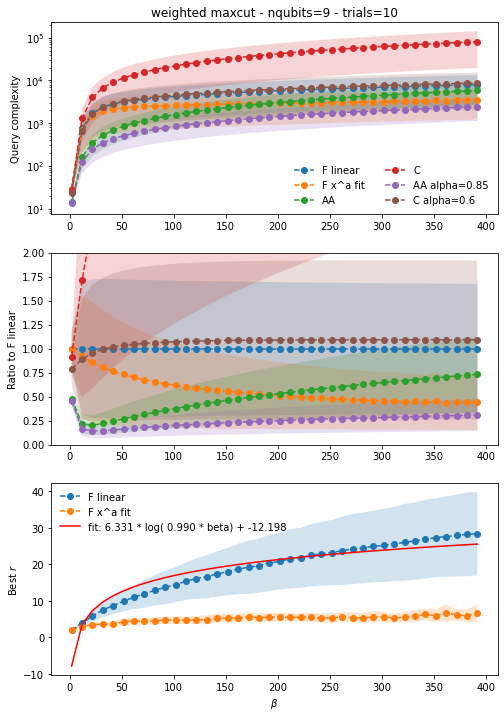

In [14]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'$\beta$')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], beta_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

def func(x, a, b, c):
    return a * np.log(np.abs(b) * x) + c

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * log( %5.3f * beta) + %5.3f' % tuple(popt))
axs[2].legend(loc='upper left', frameon=False)
plt.savefig('weighted_maxcut_nqubits_%d.png' % (nqubits), bbox_inches='tight')

x= [0.5 1. ] DeltaBeta= [0.3491114780474007, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5091312697878505, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5058079320058007, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5799122149354219, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.5984966091459504, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.6160914495507542, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.6196595171570078, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.524464980240965, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.6089743597275633, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.639725242989232, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.10697062512344609, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.12245148643693807, 0.4606750285015428, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.123464310192611, 0.4620776610992793, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.15282129357073979, 0.49992693979415886, 1.0] 

x= [0.33333333 0.66666667 1.        ] DeltaBeta= [0.1582639776808745, 0.5064257101461618, 1.0] 

x= [0.33333333 0.66666667 1.        ] D

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.021390143473734465, 0.11203443157468768, 0.29513463006535073, 0.5867989559619347, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.022335991216086034, 0.11482857491475143, 0.2992157755601879, 0.5903298174408582, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.022333412848309454, 0.11482102817328962, 0.29920481230104834, 0.5903203688714032, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.017394297639810513, 0.0995915286063529, 0.27638600530729035, 0.5702140308010768, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.019441621520965797, 0.08927731627429877, 0.21776664367052292, 0.4099678204591047, 0.6696824998425759, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.023218195772231092, 0.11738911788483884, 0.3029173011721543, 0.5935088640376477, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.019868903764016104, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.01523894917653726, 0.09236633215091944, 0.26502154362622066, 0.5598508936659

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.013537432877283723, 0.07150834677162904, 0.18931262556687586, 0.37772624280871464, 0.6454659840640897, 1.0] 

x= [0.5 1. ] DeltaBeta= [0.013324910520091958, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.008983964200755142, 0.05561278662268975, 0.1615449386075131, 0.344255828143311, 0.6190901770122954, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.008720038749779568, 0.05460528114714059, 0.15969222329031435, 0.3419407659436883, 0.6172146405355344, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.012683931955281233, 0.08320280807923962, 0.25002563465558125, 0.5457855889386384, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.012033126780307376, 0.06652570129540106, 0.18087936761275797, 0.36779043499214886, 0.6377754017414811, 1.0] 

x= [0.16666667 0.33333333 0.5        0.666

<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeW

x= [0.5 1. ] DeltaBeta= [0.010174727067890285, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.0003120828071693571, 0.010094984140560787, 0.07714414403339592, 0.32654379689321145, 1.0] 

x= [0.25 0.5  0.75 1.  ] DeltaBeta= [0.009588006249957806, 0.09791836523327892, 0.381215703340396, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.008384892499507298, 0.05330872809805342, 0.15728929949490716, 0.33892151766992573, 0.6147580801435456, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.00934773814633476, 0.056982882001554894, 0.16404467127653682, 0.3473619810880447, 0.6215957403392464, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.009827572507378979, 0.05875895425702142, 0.16725233850132093, 0.3513191790532564, 0.6247700002579434, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.00976461938081839, 0.05852788124559276, 0

<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


x= [0.5 1. ] DeltaBeta= [0.009621759241072633, 1.0] 

x= [0.2 0.4 0.6 0.8 1. ] DeltaBeta= [0.0002806997200295329, 0.009503879010302446, 0.07459230121632424, 0.321780571184625, 1.0] 

x= [0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] DeltaBeta= [0.00523072034249548, 0.030132904896212204, 0.0839253170720096, 0.17358832016069572, 0.30502835803475226, 0.4834732947142844, 0.7136698792173192, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.007936898733677401, 0.051543844511183094, 0.15398344475362893, 0.3347362737185964, 0.6113328236227243, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.0088750077895548, 0.055198264688429144, 0.16078418116313015, 0.3433065634263205, 0.6183219769180884, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.009338500793937877, 0.05694834909204978, 0.16398194052725523, 0.34728427355440683, 0.6215332086528345, 1.0] 

x= [0.16666667 0.

<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-15-2bcde376520b>:4: RuntimeW

x= [0.5 1. ] DeltaBeta= [0.007934350078634125, 1.0] 

x= [0.25 0.5  0.75 1.  ] DeltaBeta= [0.007917384381706066, 0.08897968521918959, 0.3663669661436997, 1.0] 

x= [0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] DeltaBeta= [0.0004792422067342967, 0.006124021492136886, 0.027182348573422707, 0.07825612750537102, 0.1777157348552021, 0.34735105658732063, 0.6121273113413954, 1.0] 

x= [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ] DeltaBeta= [0.006583236191023313, 0.04596023756399406, 0.1432376449720686, 0.32086702886630347, 0.599810411099681, 1.0] 

x= [0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286
 1.        ] DeltaBeta= [0.006652420412060924, 0.03966888277389265, 0.11273817612780074, 0.23654852866422016, 0.420306321111193, 0.6722662152933147, 1.0] 

x= [0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286
 1.        ] DeltaBeta= [0.006990110028759374, 0.040953808836841216, 0.11519523744346427, 0.23994106692798522, 0.4239203729295926

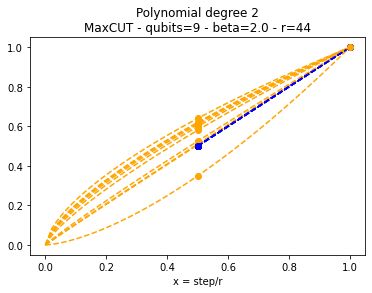

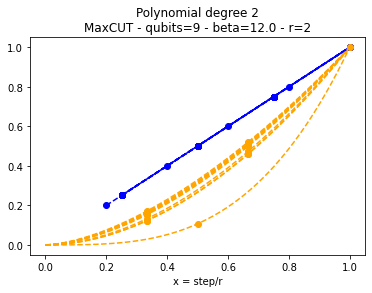

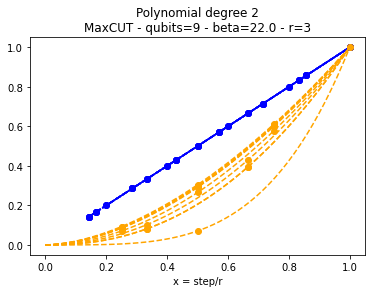

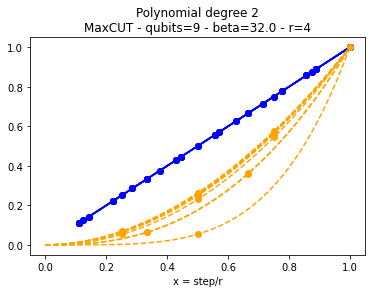

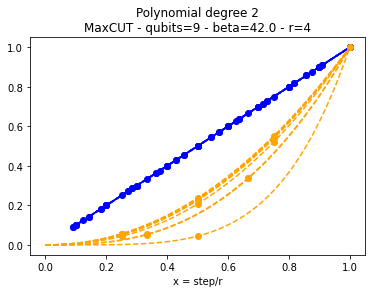

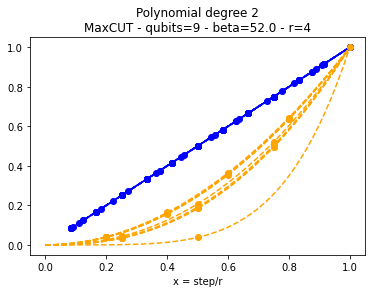

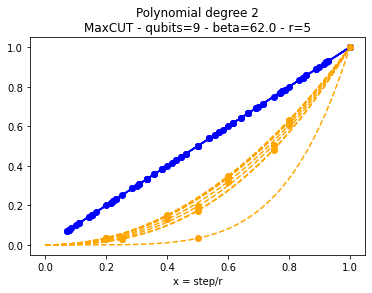

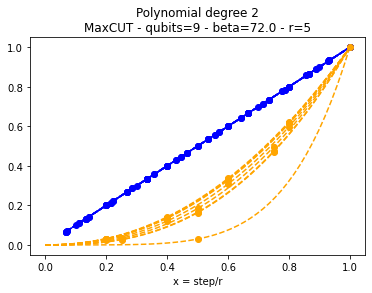

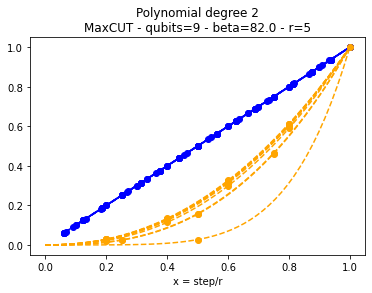

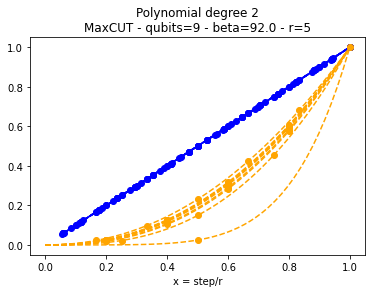

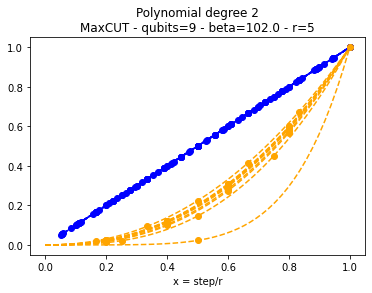

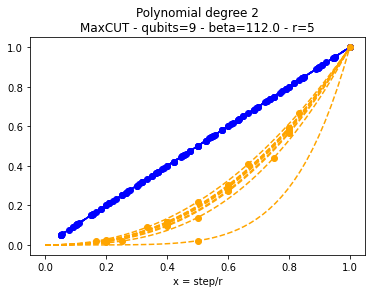

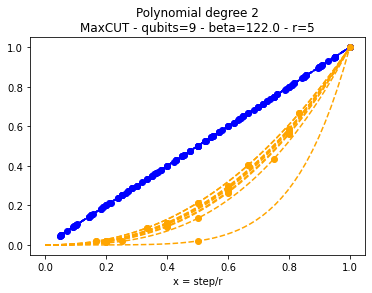

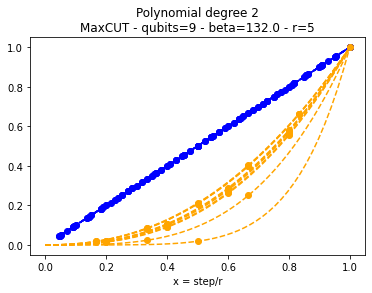

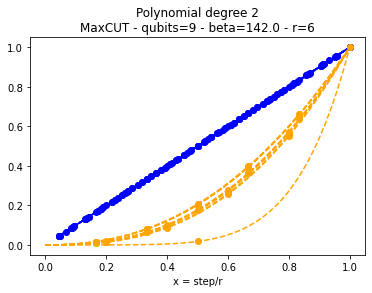

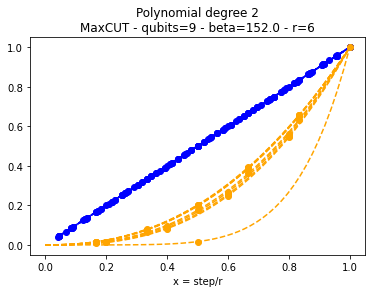

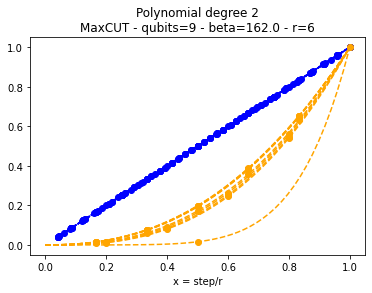

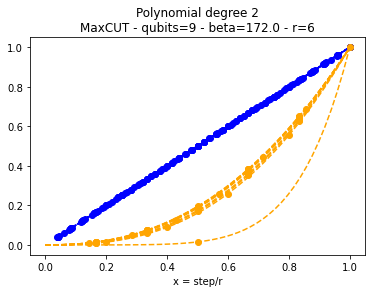

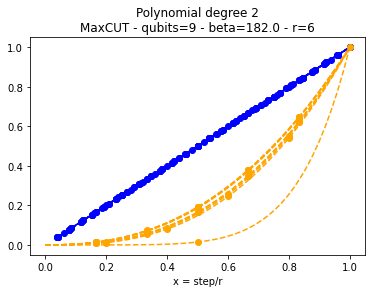

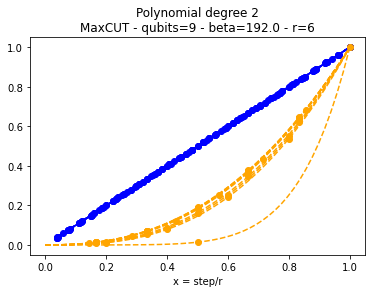

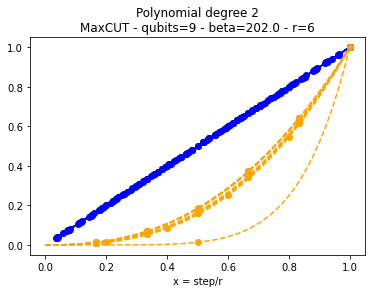

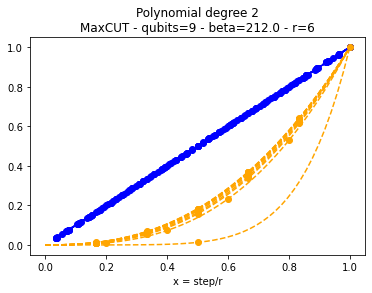

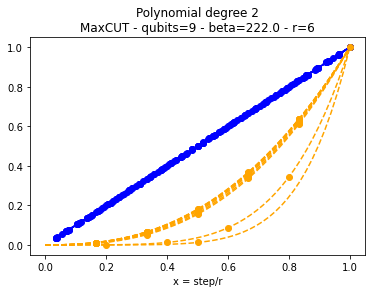

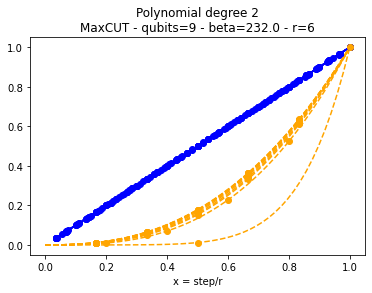

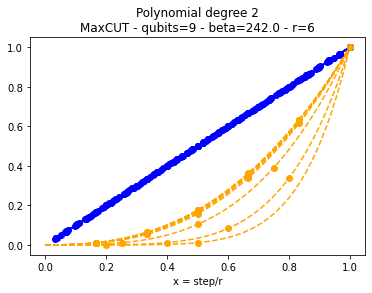

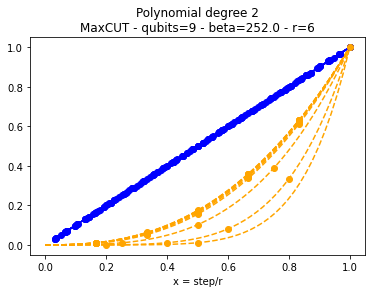

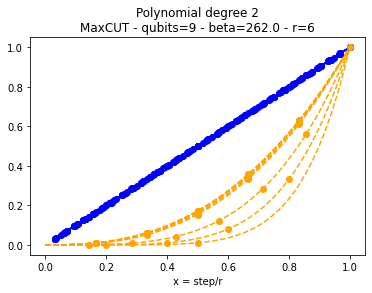

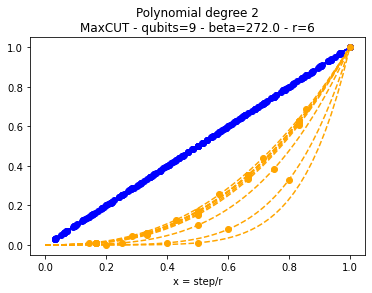

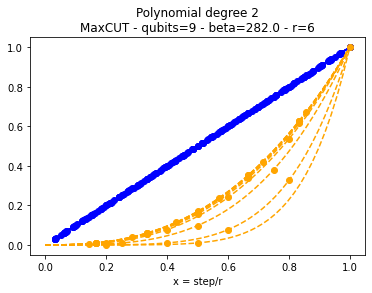

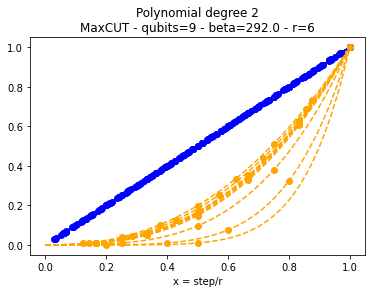

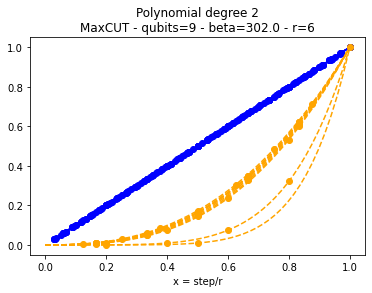

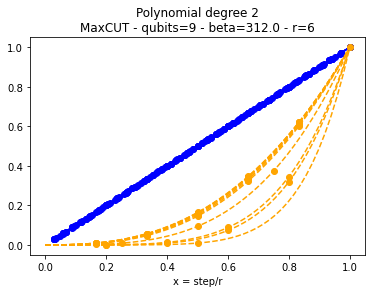

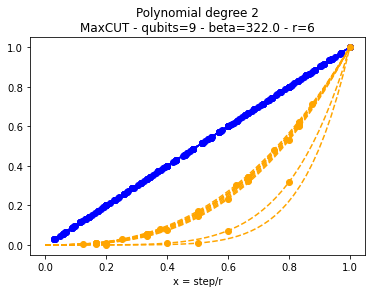

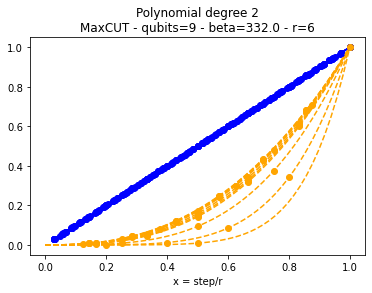

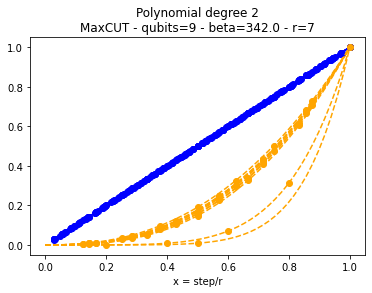

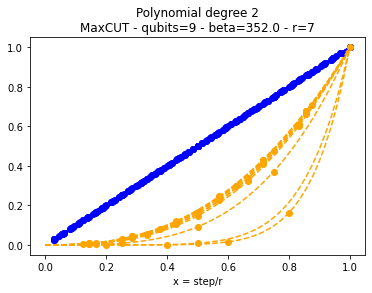

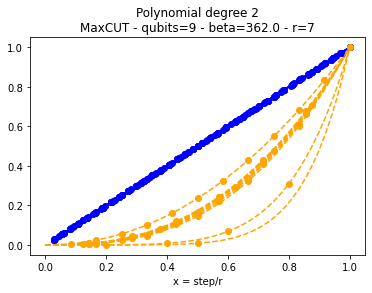

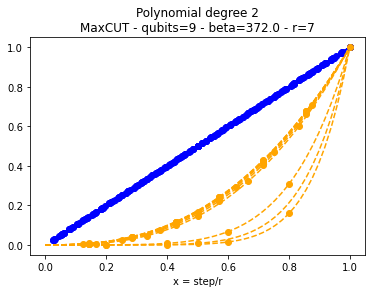

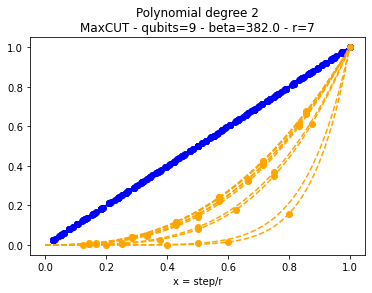

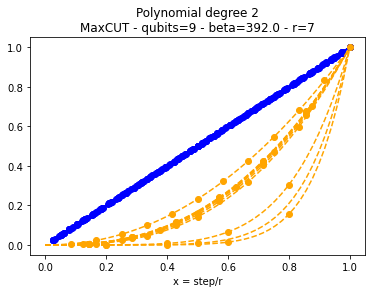

In [15]:
# plot
xx = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')